2) Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [12, 5]

Загрузка данных student-por.csv

In [2]:
print("СТУДЕНЧЕСКИЕ ДАННЫЕ (student-por.csv):")
try:
    df_student_single = pd.read_csv('../student-por.csv', sep=';')
    print("✓ Успешно загружено как одна колонка")
    print(f"  Исходный размер: {df_student_single.shape}")
    
    if df_student_single.shape[1] == 1:
        first_col = df_student_single.columns[0]
        print(f"  Единственная колонка: '{first_col}'")
        
        print("  Разделяем данные по запятой...")
        split_data = df_student_single[first_col].str.split(',', expand=True)
        print(f"  После разделения: {split_data.shape}")
        
        correct_columns = [
            'school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 
            'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 
            'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 
            'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 
            'G1', 'G2', 'G3'
        ]
        
        if split_data.shape[1] == len(correct_columns):
            split_data.columns = correct_columns
            df_student = split_data
            print("✓ Успешно присвоены названия колонок")
        else:
            print(f"⚠ Количество колонок не совпадает: ожидалось {len(correct_columns)}, получено {split_data.shape[1]}")
            split_data.columns = correct_columns[:split_data.shape[1]]
            df_student = split_data
            print("✓ Использованы доступные названия колонок")
        
        print("  Преобразуем числовые колонки...")
        numeric_columns = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
                          'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences',
                          'G1', 'G2', 'G3']
        
        for col in numeric_columns:
            if col in df_student.columns:
                df_student[col] = pd.to_numeric(df_student[col], errors='coerce')
                print(f"    ✓ '{col}' преобразована в числовой формат")
        
        print(f"✓ Итоговый размер: {df_student.shape}")
        print(f"✓ Колонки: {len(df_student.columns)}")
        print("\nПервые 3 строки после разделения:")
        print(df_student.head(3))
        
    else:
        df_student = df_student_single
        print("✓ Данные уже разделены")
        
except Exception as e:
    print(f"✗ Ошибка: {e}")
    df_student = None

СТУДЕНЧЕСКИЕ ДАННЫЕ (student-por.csv):
✓ Успешно загружено как одна колонка
  Исходный размер: (649, 1)
  Единственная колонка: 'school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3'
  Разделяем данные по запятой...
  После разделения: (649, 33)
✓ Успешно присвоены названия колонок
  Преобразуем числовые колонки...
    ✓ 'age' преобразована в числовой формат
    ✓ 'Medu' преобразована в числовой формат
    ✓ 'Fedu' преобразована в числовой формат
    ✓ 'traveltime' преобразована в числовой формат
    ✓ 'studytime' преобразована в числовой формат
    ✓ 'failures' преобразована в числовой формат
    ✓ 'famrel' преобразована в числовой формат
    ✓ 'freetime' преобразована в числовой формат
    ✓ 'goout' преобразована в числовой формат
    ✓ 'Dalc' преобразована в числовой формат
    ✓ 'Walc' преобразована в числовой

Загрузка данных house.csv

In [3]:
try:
    df_house = pd.read_csv('../house.csv')
    print("✓ Успешно загружено")
    print(f"  Размер: {df_house.shape}")
    print(f"  Колонки: {len(df_house.columns)}")
except Exception as e:
    print(f"✗ Ошибка: {e}")
    df_house = None

✓ Успешно загружено
  Размер: (4746, 12)
  Колонки: 12


Функции предобработки данных для классификации (студенческие данные)

In [4]:
def preprocess_student_classification(df):
    """Предобработка студенческих данных для классификации"""
    print("\n" + "="*50)
    print("ПРЕДОБРАБОТКА СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ)")
    print("="*50)
    
    if df is None:
        print("❌ DataFrame пустой")
        return None, None, None
    
    df_clean = df.copy()
    
    print("Доступные колонки:")
    for i, col in enumerate(df_clean.columns):
        print(f"  {i+1:2d}. '{col}' (тип: {df_clean[col].dtype})")
    
    if 'G3' not in df_clean.columns:
        print("❌ Колонка 'G3' не найдена!")
        print("   Доступные колонки:", list(df_clean.columns))
        return None, None, None
    
    print(f"✓ Найдена целевая переменная: 'G3'")
    print(f"  Диапазон значений: {df_clean['G3'].min()} - {df_clean['G3'].max()}")
    
    df_clean['academic_success'] = (df_clean['G3'] >= 10).astype(int)
    success_rate = df_clean['academic_success'].mean() * 100
    print(f"✓ Создана целевая переменная 'academic_success'")
    print(f"  Процент успевающих студентов: {success_rate:.1f}%")
    
    numeric_features = []
    possible_numeric = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
                       'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
    
    print("\nПоиск числовых признаков:")
    for feature in possible_numeric:
        if feature in df_clean.columns:
            if df_clean[feature].dtype == 'object':
                df_clean[feature] = pd.to_numeric(df_clean[feature], errors='coerce')
            numeric_features.append(feature)
            print(f"  ✓ '{feature}' найден")
        else:
            print(f"  ✗ '{feature}' не найден")
    
    categorical_features = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 
                           'Fjob', 'reason', 'guardian']
    
    features = numeric_features.copy()
    le = LabelEncoder()
    
    print("\nПоиск и кодирование категориальных признаков:")
    for feature in categorical_features:
        if feature in df_clean.columns:
            try:
                df_clean[f'{feature}_encoded'] = le.fit_transform(df_clean[feature].astype(str))
                features.append(f'{feature}_encoded')
                print(f"  ✓ '{feature}' закодирован")
            except Exception as e:
                print(f"  ✗ '{feature}' ошибка кодирования: {e}")
        else:
            print(f"  ✗ '{feature}' не найден")
    
    initial_count = len(df_clean)
    df_clean = df_clean.dropna(subset=features + ['academic_success'])
    final_count = len(df_clean)
    
    print(f"\n✓ Очистка данных: {initial_count} → {final_count} строк")
    print(f"✓ Используется {len(features)} признаков")
    
    if not features or df_clean.empty:
        print("❌ Недостаточно данных для анализа")
        return None, None, None
    
    X = df_clean[features]
    y = df_clean['academic_success']
    
    print(f"✓ Итоговый набор данных: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"  Баланс классов: {np.bincount(y)}")
    
    return X, y, features

Функции предобработки данных для регрессии (данные о недвижимости)

In [5]:
def preprocess_house_regression(df):
    """Предобработка данных о недвижимости для регрессии"""
    print("\n" + "="*50)
    print("ПРЕДОБРАБОТКА ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ)")
    print("="*50)
    
    if df is None:
        return None, None, None
    
    df_clean = df.copy()
    
    print(f"✓ Целевая переменная: Rent (арендная плата)")
    print(f"  Диапазон цен: {df_clean['Rent'].min()} - {df_clean['Rent'].max()}")
    
    if 'Floor' in df_clean.columns:
        def parse_floor(floor_str):
            if pd.isna(floor_str):
                return 0
            floor_str = str(floor_str)
            if 'Ground' in floor_str:
                return 0
            if 'Basement' in floor_str:
                return -1
            try:
                parts = floor_str.split()
                for part in parts:
                    if part.isdigit():
                        return int(part)
                return 0
            except:
                return 0
        
        df_clean['floor_number'] = df_clean['Floor'].apply(parse_floor)
        print("✓ Обработана колонка Floor")
    
    if 'Size' in df_clean.columns:
        try:
            df_clean['Size'] = df_clean['Size'].astype(str).str.replace(' sqft', '').astype(float)
            print("✓ Обработана колонка Size")
        except Exception as e:
            print(f"✗ Ошибка обработки Size: {e}")
    
    features = ['BHK', 'Bathroom']
    if 'Size' in df_clean.columns:
        features.append('Size')
    if 'floor_number' in df_clean.columns:
        features.append('floor_number')
    

    categorical_cols = ['Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']
    le = LabelEncoder()
    
    for col in categorical_cols:
        if col in df_clean.columns:
            try:
                df_clean[col + '_encoded'] = le.fit_transform(df_clean[col].astype(str))
                features.append(col + '_encoded')
                print(f"✓ Закодирована колонка: {col}")
            except Exception as e:
                print(f"✗ Ошибка кодирования {col}: {e}")
    
    X = df_clean[features]
    y = df_clean['Rent']
    
    print(f"✓ Итоговый набор данных: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"  Статистика арендной платы: mean={y.mean():.2f}, std={y.std():.2f}")
    
    return X, y, features

Функция исследования c решающим дервом для классификации

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

def decision_tree_classification_study(X, y, dataset_name="Данные"):
    print(f"\n" + "="*70)
    print(f"РЕШАЮЩЕЕ ДЕРЕВО КЛАССИФИКАЦИЯ - {dataset_name}")
    print("="*70)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    print("🔍 Исследование влияния глубины дерева на точность...")
    depth_range = range(1, 21)
    train_scores = []
    test_scores = []
    
    for depth in depth_range:
        tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
        tree.fit(X_train, y_train)
        train_scores.append(tree.score(X_train, y_train))
        test_scores.append(tree.score(X_test, y_test))
    
    best_depth_index = np.argmax(test_scores)
    best_depth = depth_range[best_depth_index]
    best_score = test_scores[best_depth_index]
    best_train_score = train_scores[best_depth_index]
    
    print(f"🎯 Результаты:")
    print(f"  Оптимальная глубина: {best_depth}")
    print(f"  Лучшая точность: {best_score:.4f}")
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(depth_range, train_scores, label='Обучающая выборка', marker='o', linewidth=2)
    plt.plot(depth_range, test_scores, label='Тестовая выборка', marker='s', linewidth=2)
    plt.axvline(x=best_depth, color='red', linestyle='--', alpha=0.7, label=f'Лучшая глубина={best_depth}')
    plt.xlabel('Максимальная глубина дерева')
    plt.ylabel('Точность')
    plt.title(f'Решающее дерево - Влияние глубины\n{dataset_name}', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    best_tree = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
    best_tree.fit(X_train, y_train)
    y_pred = best_tree.predict(X_test)
    
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Неуспех', 'Успех'], 
                yticklabels=['Неуспех', 'Успех'])
    plt.title(f'Матрица ошибок (глубина={best_depth})\nТочность: {best_score:.4f}', fontsize=12)
    plt.ylabel('Фактические значения')
    plt.xlabel('Предсказанные значения')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 АНАЛИЗ МОДЕЛИ РЕШАЮЩЕГО ДЕРЕВА:")
    print(f"  Оптимальная глубина дерева: {best_depth}")
    print(f"  Точность на тестовой выборке: {best_score:.4f}")
    print(f"  Точность на обучающей выборке: {best_train_score:.4f}")
    
    overfitting_gap = best_train_score - best_score
    print(f"  Разница между train и test accuracy: {overfitting_gap:.4f}")
    
    if overfitting_gap > 0.1:
        print("  ⚠️ Возможное переобучение (большая разница между train и test)")
    else:
        print("  ✅ Модель хорошо обобщает (малая разница между train и test)")
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:")
    print(f"  Precision (Точность): {precision:.4f}")
    print(f"  Recall (Полнота): {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    
    if best_score >= 0.9:
        print("  🎉 Отличное качество модели (Точность ≥ 0.9)")
    elif best_score >= 0.8:
        print("  👍 Хорошее качество модели (0.8 ≤ Точность < 0.9)")
    elif best_score >= 0.7:
        print("  👌 Удовлетворительное качество модели (0.7 ≤ Точность < 0.8)")
    else:
        print("  💡 Низкое качество модели (Точность < 0.7)")
    
    print(f"\n📋 ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ:")
    print(classification_report(y_test, y_pred, target_names=['Неуспех', 'Успех']))
    
    print(f"\n🌳 ВАЖНОСТЬ ПРИЗНАКОВ:")
    feature_importances = best_tree.feature_importances_
    feature_names = X.columns if hasattr(X, 'columns') else [f'Признак {i}' for i in range(X.shape[1])]
    
    importance_df = pd.DataFrame({
        'Признак': feature_names,
        'Важность': feature_importances
    }).sort_values('Важность', ascending=False)
    
    print(importance_df.to_string(index=False))
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Признак'][:10], importance_df['Важность'][:10])
    plt.xlabel('Важность признака')
    plt.title(f'Топ-10 важнейших признаков (глубина={best_depth})')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return best_tree, best_depth, best_score

Функция исследования с решающим деревом для регрессии

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

def decision_tree_regression_study(X, y, dataset_name="Данные"):
    print(f"\n" + "="*70)
    print(f"РЕШАЮЩЕЕ ДЕРЕВО РЕГРЕССИЯ - {dataset_name}")
    print("="*70)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    print("🔍 Исследование влияния глубины дерева на R² score...")
    depth_range = range(1, 21)
    train_scores = []
    test_scores = []
    
    for depth in depth_range:
        tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
        tree.fit(X_train, y_train)
        train_scores.append(tree.score(X_train, y_train))
        test_scores.append(tree.score(X_test, y_test))
    
    best_depth_index = np.argmax(test_scores)
    best_depth = depth_range[best_depth_index]
    best_score = test_scores[best_depth_index]
    best_train_score = train_scores[best_depth_index]
    
    print(f"🎯 Результаты:")
    print(f"  Оптимальная глубина: {best_depth}")
    print(f"  Лучший R² score: {best_score:.4f}")
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(depth_range, train_scores, label='Обучающая выборка', marker='o', linewidth=2)
    plt.plot(depth_range, test_scores, label='Тестовая выборка', marker='s', linewidth=2)
    plt.axvline(x=best_depth, color='red', linestyle='--', alpha=0.7, label=f'Лучшая глубина={best_depth}')
    plt.xlabel('Максимальная глубина дерева')
    plt.ylabel('R² Score')
    plt.title(f'Решающее дерево - Влияние глубины\n{dataset_name}', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    best_tree = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
    best_tree.fit(X_train, y_train)
    y_pred = best_tree.predict(X_test)
    
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred, alpha=0.6, s=50)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Фактические значения')
    plt.ylabel('Предсказанные значения')
    plt.title(f'Предсказания vs Фактические значения\nR² = {best_score:.4f}', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 АНАЛИЗ МОДЕЛИ РЕШАЮЩЕГО ДЕРЕВА:")
    print(f"  Оптимальная глубина дерева: {best_depth}")
    print(f"  R² score на тестовой выборке: {best_score:.4f}")
    print(f"  R² score на обучающей выборке: {best_train_score:.4f}")
    
    overfitting_gap = best_train_score - best_score
    print(f"  Разница между train и test R²: {abs(overfitting_gap):.4f}")
    
    if overfitting_gap > 0.1:
        print("  ⚠️ Возможное переобучение (большая разница между train и test)")
    else:
        print("  ✅ Модель хорошо обобщает (малая разница между train и test)")
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"\n📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ РЕГРЕССИИ:")
    print(f"  MSE (Mean Squared Error): {mse:.4f}")
    print(f"  RMSE (Root Mean Squared Error): {rmse:.4f}")
    print(f"  MAE (Mean Absolute Error): {mae:.4f}")
    
    if best_score >= 0.7:
        print("  🎉 Отличное качество модели (R² ≥ 0.7)")
    elif best_score >= 0.5:
        print("  👍 Хорошее качество модели (0.5 ≤ R² < 0.7)")
    elif best_score >= 0.3:
        print("  👌 Удовлетворительное качество модели (0.3 ≤ R² < 0.5)")
    else:
        print("  💡 Низкое качество модели (R² < 0.3)")
    
    print(f"\n🌳 ВАЖНОСТЬ ПРИЗНАКОВ:")
    feature_importances = best_tree.feature_importances_
    feature_names = X.columns if hasattr(X, 'columns') else [f'Признак {i}' for i in range(X.shape[1])]
    
    importance_df = pd.DataFrame({
        'Признак': feature_names,
        'Важность': feature_importances
    }).sort_values('Важность', ascending=False)
    
    print(importance_df.to_string(index=False))
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Признак'][:10], importance_df['Важность'][:10])
    plt.xlabel('Важность признака')
    plt.title(f'Топ-10 важнейших признаков (глубина={best_depth})')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print(f"\n📉 АНАЛИЗ ОШИБОК:")
    residuals = y_test - y_pred
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Остатки (Факт - Прогноз)')
    plt.title('Остатки vs Предсказания')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    plt.hist(residuals, bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel('Остатки')
    plt.ylabel('Частота')
    plt.title('Распределение остатков')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    plt.scatter(range(len(residuals)), residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    plt.xlabel('Номер наблюдения')
    plt.ylabel('Остатки')
    plt.title('Остатки по порядку')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"  Средний остаток: {np.mean(residuals):.4f}")
    print(f"  Стандартное отклонение остатков: {np.std(residuals):.4f}")
    
    return best_tree, best_depth, best_score

Основной блок выполнения - анализ студенческих данных (классификация)


🎓 АНАЛИЗ СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ) 🎓
------------------------------------------------------------

ПРЕДОБРАБОТКА СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ)
Доступные колонки:
   1. 'school' (тип: object)
   2. 'sex' (тип: object)
   3. 'age' (тип: int64)
   4. 'address' (тип: object)
   5. 'famsize' (тип: object)
   6. 'Pstatus' (тип: object)
   7. 'Medu' (тип: int64)
   8. 'Fedu' (тип: int64)
   9. 'Mjob' (тип: object)
  10. 'Fjob' (тип: object)
  11. 'reason' (тип: object)
  12. 'guardian' (тип: object)
  13. 'traveltime' (тип: int64)
  14. 'studytime' (тип: int64)
  15. 'failures' (тип: int64)
  16. 'schoolsup' (тип: object)
  17. 'famsup' (тип: object)
  18. 'paid' (тип: object)
  19. 'activities' (тип: object)
  20. 'nursery' (тип: object)
  21. 'higher' (тип: object)
  22. 'internet' (тип: object)
  23. 'romantic' (тип: object)
  24. 'famrel' (тип: int64)
  25. 'freetime' (тип: int64)
  26. 'goout' (тип: int64)
  27. 'Dalc' (тип: int64)
  28. 'Walc' (тип: int64)
  29. 'health

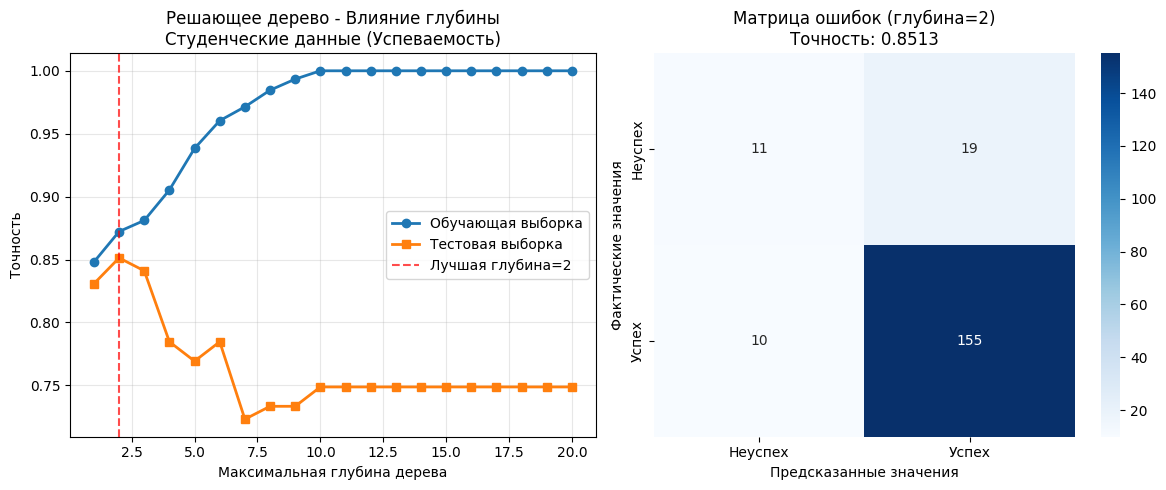


📊 АНАЛИЗ МОДЕЛИ РЕШАЮЩЕГО ДЕРЕВА:
  Оптимальная глубина дерева: 2
  Точность на тестовой выборке: 0.8513
  Точность на обучающей выборке: 0.8722
  Разница между train и test accuracy: 0.0210
  ✅ Модель хорошо обобщает (малая разница между train и test)

📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
  Precision (Точность): 0.8908
  Recall (Полнота): 0.9394
  F1-Score: 0.9145
  👍 Хорошее качество модели (0.8 ≤ Точность < 0.9)

📋 ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ:
              precision    recall  f1-score   support

     Неуспех       0.52      0.37      0.43        30
       Успех       0.89      0.94      0.91       165

    accuracy                           0.85       195
   macro avg       0.71      0.65      0.67       195
weighted avg       0.83      0.85      0.84       195


🌳 ВАЖНОСТЬ ПРИЗНАКОВ:
         Признак  Важность
        failures  0.717238
  school_encoded  0.282762
            Medu  0.000000
            Fedu  0.000000
      traveltime  0.000000
             age  0.000000
       

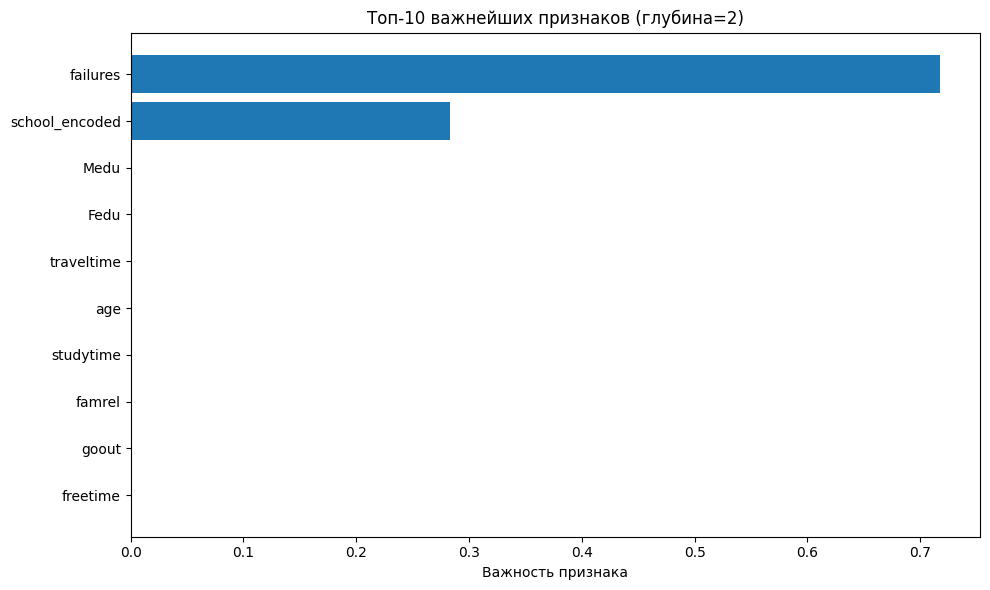

In [8]:
if df_student is not None:
    print("\n" + "🎓 АНАЛИЗ СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ) " + "🎓")
    print("-" * 60)
    
    X_student_class, y_student_class, features_class = preprocess_student_classification(df_student)
    
    if X_student_class is not None:
        knn_class, k_class, score_class = decision_tree_classification_study(
            X_student_class, y_student_class, "Студенческие данные (Успеваемость)"
        )
    else:
        print("❌ Не удалось подготовить данные для классификации")

Основной блок выполнения - анализ данных о недвижимости (регрессия)


🏠 АНАЛИЗ ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ) 🏠

ПРЕДОБРАБОТКА ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ)
✓ Целевая переменная: Rent (арендная плата)
  Диапазон цен: 1200 - 3500000
✓ Обработана колонка Floor
✓ Обработана колонка Size
✓ Закодирована колонка: Area Type
✓ Закодирована колонка: City
✓ Закодирована колонка: Furnishing Status
✓ Закодирована колонка: Tenant Preferred
✓ Закодирована колонка: Point of Contact
✓ Итоговый набор данных: 4746 samples, 9 features
  Статистика арендной платы: mean=34993.45, std=78106.41

РЕШАЮЩЕЕ ДЕРЕВО РЕГРЕССИЯ - Данные о недвижимости (Арендная плата)
🔍 Исследование влияния глубины дерева на R² score...
🎯 Результаты:
  Оптимальная глубина: 2
  Лучший R² score: 0.3424


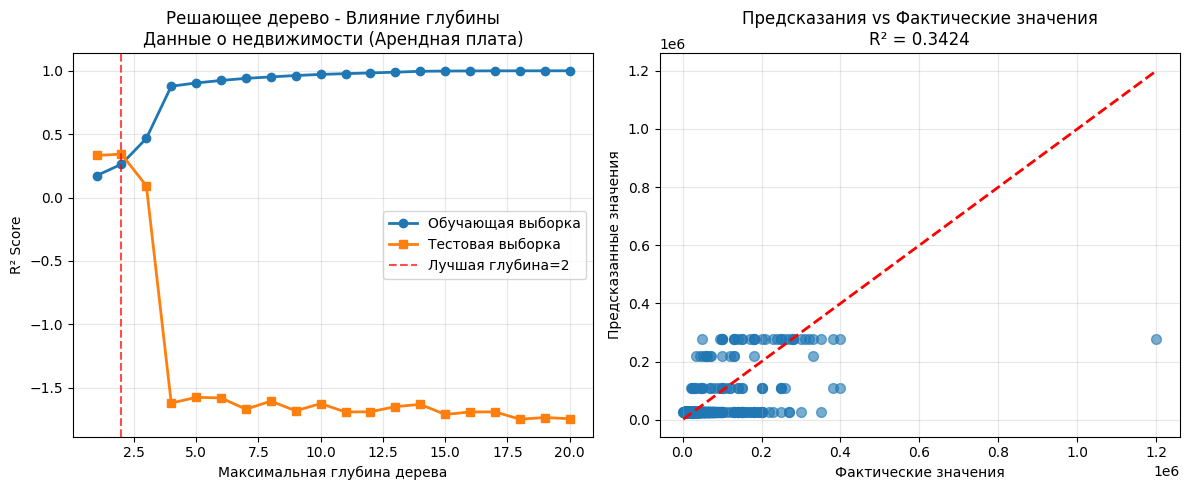


📊 АНАЛИЗ МОДЕЛИ РЕШАЮЩЕГО ДЕРЕВА:
  Оптимальная глубина дерева: 2
  R² score на тестовой выборке: 0.3424
  R² score на обучающей выборке: 0.2629
  Разница между train и test R²: 0.0795
  ✅ Модель хорошо обобщает (малая разница между train и test)

📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ РЕГРЕССИИ:
  MSE (Mean Squared Error): 2314228338.9645
  RMSE (Root Mean Squared Error): 48106.4272
  MAE (Mean Absolute Error): 23592.9430
  👌 Удовлетворительное качество модели (0.3 ≤ R² < 0.5)

🌳 ВАЖНОСТЬ ПРИЗНАКОВ:
                  Признак  Важность
                 Bathroom  0.657319
             City_encoded  0.180109
                     Size  0.162572
                      BHK  0.000000
             floor_number  0.000000
        Area Type_encoded  0.000000
Furnishing Status_encoded  0.000000
 Tenant Preferred_encoded  0.000000
 Point of Contact_encoded  0.000000


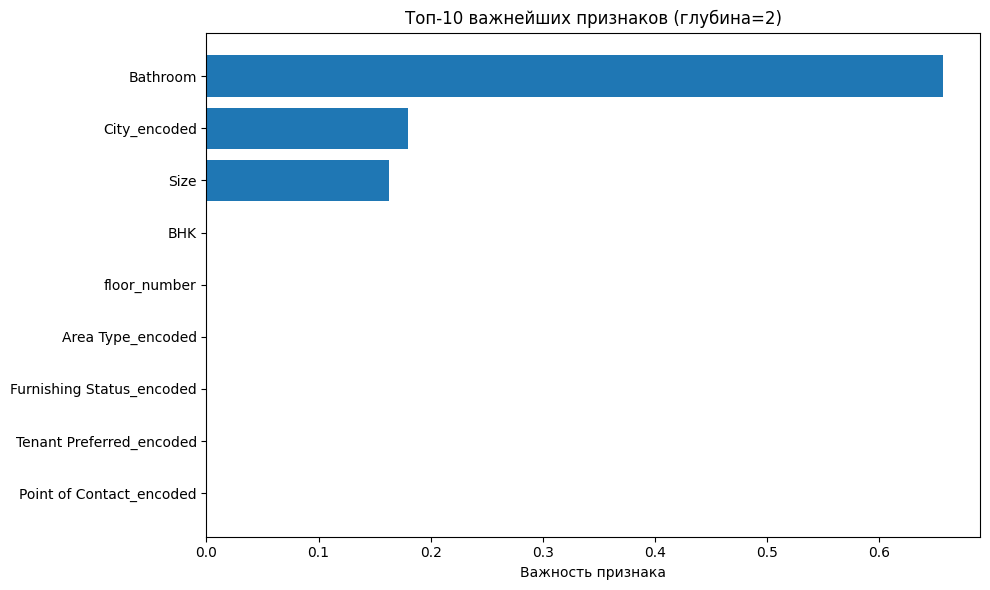


📉 АНАЛИЗ ОШИБОК:


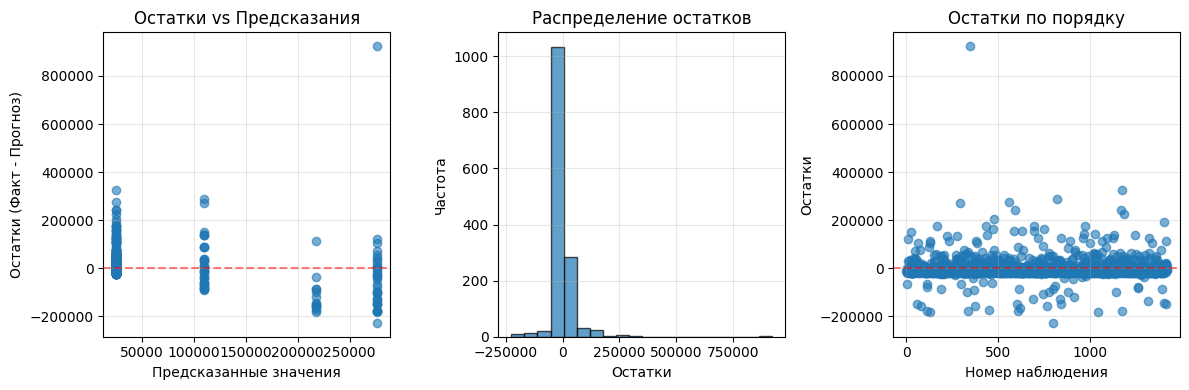

  Средний остаток: -1319.0238
  Стандартное отклонение остатков: 48088.3407


In [9]:
if df_house is not None:
    print("\n" + "🏠 АНАЛИЗ ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ) " + "🏠")
    
    X_house, y_house, features_house = preprocess_house_regression(df_house)
    
    if X_house is not None:
        knn_house, k_house, score_house = decision_tree_regression_study(
            X_house, y_house, "Данные о недвижимости (Арендная плата)"
        )
    else:
        print("❌ Не удалось подготовить данные о недвижимости")

3) Сформулируем гипотезы: препроцессинг данных (более тщательная обработка выбросов улучшит качество моделей)

In [10]:
def advanced_preprocessing(df):
    """Улучшенный препроцессинг с обработкой выбросов методом IQR"""
    numeric_columns = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
                      'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences',
                      'G1', 'G2', 'G3']
    
    numeric_columns = [col for col in numeric_columns if col in df.columns]
    
    print(f"🔧 ОБРАБОТКА ВЫБРОСОВ В {len(numeric_columns)} ЧИСЛОВЫХ КОЛОНКАХ...")
    
    initial_size = len(df)
    print(f"  Размер данных до обработки: {initial_size} строк")
    
    Q1 = df[numeric_columns].quantile(0.25)
    Q3 = df[numeric_columns].quantile(0.75)
    IQR = Q3 - Q1
    
    outlier_mask = ((df[numeric_columns] < (Q1 - 1.5 * IQR)) | 
                    (df[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)
    
    print(f"  Найдено строк с выбросами: {outlier_mask.sum()}")
    print(f"  Процент выбросов: {outlier_mask.sum()/initial_size*100:.1f}%")
    
    df_clean = df[~outlier_mask].copy()
    
    print("  📊 Заполнение пропусков в числовых колонках...")
    for col in numeric_columns:
        if df_clean[col].isna().any():
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)
            print(f"    ✓ Заполнены пропуски в '{col}' медианой: {median_val}")
    
    print(f"  ✓ Размер данных после обработки: {len(df_clean)} строк")
    print(f"  ✓ Удалено строк: {initial_size - len(df_clean)}")
    print(f"  ✓ Сохранено данных: {len(df_clean)/initial_size*100:.1f}%")
    
    return df_clean

def advanced_preprocessing_house(df):
    """Улучшенный препроцессинг с обработкой выбросов методом IQR для house данных"""
    numeric_columns = ['BHK', 'Bathroom', 'Size', 'Rent']
    
    numeric_columns = [col for col in numeric_columns if col in df.columns]
    
    print(f"🔧 ОБРАБОТКА ВЫБРОСОВ В {len(numeric_columns)} ЧИСЛОВЫХ КОЛОНКАХ...")
    
    initial_size = len(df)
    print(f"  Размер данных до обработки: {initial_size} строк")
    
    Q1 = df[numeric_columns].quantile(0.25)
    Q3 = df[numeric_columns].quantile(0.75)
    IQR = Q3 - Q1
    
    outlier_mask = ((df[numeric_columns] < (Q1 - 1.5 * IQR)) | 
                    (df[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)
    
    print(f"  Найдено строк с выбросами: {outlier_mask.sum()}")
    print(f"  Процент выбросов: {outlier_mask.sum()/initial_size*100:.1f}%")
    
    df_clean = df[~outlier_mask].copy()
    
    print("  📊 Заполнение пропусков в числовых колонках...")
    for col in numeric_columns:
        if df_clean[col].isna().any():
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)
            print(f"    ✓ Заполнены пропуски в '{col}' медианой: {median_val}")
    
    print(f"  ✓ Размер данных после обработки: {len(df_clean)} строк")
    print(f"  ✓ Удалено строк: {initial_size - len(df_clean)}")
    print(f"  ✓ Сохранено данных: {len(df_clean)/initial_size*100:.1f}%")
    
    return df_clean

инженеря признаков (создание новых признаков повысит предсказательную силу)

In [11]:
def feature_engineering(df):
    """Создание новых признаков для улучшения моделей"""
    print("🔧 СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ...")
    
    df_fe = df.copy()
    
    if 'G1' in df.columns and 'G2' in df.columns:
        df_fe['grade_trend'] = df_fe['G2'] - df_fe['G1']
        print("  ✓ Создан признак 'grade_trend' (тренд успеваемости)")
    
    if 'Dalc' in df.columns and 'Walc' in df.columns:
        df_fe['total_alcohol'] = df_fe['Dalc'] + df_fe['Walc']
        print("  ✓ Создан признак 'total_alcohol' (общее потребление алкоголя)")
    
    if 'studytime' in df.columns and 'goout' in df.columns:
        df_fe['study_effort'] = df_fe['studytime'] * (1 - df_fe['goout']/5)
        print("  ✓ Создан признак 'study_effort' (индекс учебных усилий)")
    
    if 'Size' in df.columns and 'BHK' in df.columns and 'Rent' in df.columns:
        df_fe['price_per_sqft'] = df_fe['Rent'] / df_fe['Size']
        print("  ✓ Создан признак 'price_per_sqft' (цена за кв.фут)")
        
        df_fe['room_density'] = df_fe['BHK'] / df_fe['Size']
        print("  ✓ Создан признак 'room_density' (плотность комнат)")
    
    return df_fe

визуализация и EDA (глубокий анализ данных выявит скрытые зависимости)

In [12]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd


def evaluate_with_eda_insights_decision_tree_classifier(X, y, dataset_name="Данные"):
    """Оценка модели решающего дерева (классификация) с использованием инсайтов из EDA"""
    print(f"\n🌳 ИСПОЛЬЗОВАНИЕ ИНСАЙТОВ ИЗ EDA ДЛЯ РЕШАЮЩЕГО ДЕРЕВА (КЛАССИФИКАЦИЯ) ({dataset_name})")

    tree = DecisionTreeClassifier(random_state=42)
    tree.fit(X, y)

    feature_imp = pd.Series(tree.feature_importances_, index=X.columns)
    top_features = feature_imp.nlargest(int(len(feature_imp) * 0.8))
    X_reduced = X[top_features.index]

    print(f"  ✓ Отобрано {len(top_features)} самых важных признаков из {len(feature_imp)}")
    print(f"  ✓ Топ-3 признака: {list(top_features.head(3).index)}")

    X_train, X_test, y_train, y_test = train_test_split(
        X_reduced, y, test_size=0.3, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    dt_clf = DecisionTreeClassifier(
        random_state=42,
        max_depth=None,
        min_samples_split=2
    )
    dt_clf.fit(X_train_scaled, y_train)

    score = dt_clf.score(X_test_scaled, y_test)

    print(f"  ✓ Точность решающего дерева: {score:.4f}")
    print(f"  ✓ Глубина дерева: {dt_clf.get_depth()}")
    print(f"  ✓ Количество листьев: {dt_clf.get_n_leaves()}")

    return score, top_features.index, dt_clf


def evaluate_with_eda_insights_decision_tree_regressor(
    X, y, dataset_name="Данные"
):
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import r2_score
    import pandas as pd

    print(f"\n🔍 EDA + ОТБОР ПРИЗНАКОВ ({dataset_name})")

    tree = DecisionTreeRegressor(random_state=42)
    tree.fit(X, y)

    importances = pd.Series(
        tree.feature_importances_,
        index=X.columns
    ).sort_values(ascending=False)

    selected_features = importances[importances > 0].index
    X_reduced = X[selected_features]

    print(f"  ✓ Отобрано признаков: {len(selected_features)} из {X.shape[1]}")

    X_train, X_test, y_train, y_test = train_test_split(
        X_reduced, y, test_size=0.3, random_state=42
    )

    final_model = DecisionTreeRegressor(random_state=42)
    final_model.fit(X_train, y_train)

    y_pred = final_model.predict(X_test)
    score = r2_score(y_test, y_pred)

    print(f"  ✓ R² на тесте: {score:.4f}")

    return final_model, float(score), selected_features

    """Оценка модели решающего дерева (регрессия) с использованием инсайтов из EDA"""
    print(f"\n🌳 ИСПОЛЬЗОВАНИЕ ИНСАЙТОВ ИЗ EDA ДЛЯ РЕШАЮЩЕГО ДЕРЕВА (РЕГРЕССИЯ) ({dataset_name})")

    tree = DecisionTreeRegressor(random_state=42)
    tree.fit(X, y)

    feature_imp = pd.Series(tree.feature_importances_, index=X.columns)
    top_features = feature_imp.nlargest(int(len(feature_imp) * 0.8))
    X_reduced = X[top_features.index]

    print(f"  ✓ Отобрано {len(top_features)} самых важных признаков из {len(feature_imp)}")
    print(f"  ✓ Топ-3 признака: {list(top_features.head(3).index)}")

    X_train, X_test, y_train, y_test = train_test_split(
        X_reduced, y, test_size=0.3, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    dt_reg = DecisionTreeRegressor(
        random_state=42,
        max_depth=None,
        min_samples_split=2
    )
    dt_reg.fit(X_train_scaled, y_train)

    score = dt_reg.score(X_test_scaled, y_test)
    y_pred = dt_reg.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"  ✓ R² решающего дерева: {score:.4f}")
    print(f"  ✓ MSE: {mse:.4f}")
    print(f"  ✓ MAE: {mae:.4f}")
    print(f"  ✓ Глубина дерева: {dt_reg.get_depth()}")
    print(f"  ✓ Количество листьев: {dt_reg.get_n_leaves()}")

    return score, top_features.index, dt_reg


подбор гиперпараметров (подбор гиперпараметров с использованием кросс-валидации)

In [13]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


def hyperparameter_tuning_decision_tree(X, y, problem_type='classification', dataset_name="Данные"):
    """Подбор гиперпараметров для решающего дерева с использованием кросс-валидации"""
    print(f"\n🌳 ПОДБОР ГИПЕРПАРАМЕТРОВ ДЛЯ РЕШАЮЩЕГО ДЕРЕВА ({dataset_name})")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42,
        stratify=y if problem_type == 'classification' else None
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if problem_type == 'classification':
        base_model = DecisionTreeClassifier(random_state=42)
        scoring = 'accuracy'

        param_grid = {
            'max_depth': [None, 3, 5, 7, 10, 15, 20],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 5, 10],
            'criterion': ['gini', 'entropy'],
            'max_features': [None, 'sqrt', 'log2']
        }

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    else:
        base_model = DecisionTreeRegressor(random_state=42)
        scoring = 'r2'

        param_grid = {
            'max_depth': [None, 3, 5, 7, 10, 15, 20],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 5, 10],
            'criterion': ['squared_error', 'friedman_mse'],
            'max_features': [None, 'sqrt', 'log2']
        }

        cv = KFold(n_splits=5, shuffle=True, random_state=42)

    print("🔍 Запуск GridSearchCV для решающего дерева...")

    grid_search = GridSearchCV(
        base_model,
        param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        return_train_score=True
    )

    grid_search.fit(X_train_scaled, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    test_score = best_model.score(X_test_scaled, y_test)

    print(f"  ✓ Лучшие параметры: {best_params}")
    print(f"  ✓ Лучшая CV-оценка: {best_score:.4f}")
    print(f"  ✓ Оценка на тестовой выборке: {test_score:.4f}")
    print(f"  ✓ Глубина дерева: {best_model.get_depth()}")
    print(f"  ✓ Количество листьев: {best_model.get_n_leaves()}")

    results = pd.DataFrame(grid_search.cv_results_)

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    depth_scores = results.groupby('param_max_depth')['mean_test_score'].mean()

    depth_scores.plot(marker='o')
    plt.xlabel('max_depth')
    plt.ylabel(scoring)
    plt.title('Влияние глубины дерева')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    leaf_scores = results.groupby('param_min_samples_leaf')['mean_test_score'].mean()

    leaf_scores.plot(marker='o', color='orange')
    plt.xlabel('min_samples_leaf')
    plt.ylabel(scoring)
    plt.title('Влияние min_samples_leaf')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    plt.scatter(results['mean_train_score'], results['mean_test_score'], alpha=0.6)
    plt.plot(
        [results['mean_train_score'].min(), results['mean_train_score'].max()],
        [results['mean_train_score'].min(), results['mean_train_score'].max()],
        'r--'
    )
    plt.xlabel('Train score')
    plt.ylabel('CV score')
    plt.title('Train vs CV (переобучение)')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    train_test_gap = grid_search.cv_results_['mean_train_score'][grid_search.best_index_] - \
                     grid_search.cv_results_['mean_test_score'][grid_search.best_index_]

    print(f"\n📊 АНАЛИЗ ПЕРЕОБУЧЕНИЯ:")
    print(f"  Разница train − CV: {train_test_gap:.4f}")

    if train_test_gap > 0.1:
        print("  ⚠️ Сильное переобучение")
    elif train_test_gap > 0.05:
        print("  ⚠️ Умеренное переобучение")
    else:
        print("  ✅ Хорошее обобщение")

    if hasattr(best_model, 'feature_importances_') and hasattr(X, 'columns'):
        importances = best_model.feature_importances_
        top_idx = np.argsort(importances)[-3:][::-1]
        top_features = X.columns[top_idx]

        print(f"\n🌟 ТОП-3 ВАЖНЫХ ПРИЗНАКА:")
        for f, v in zip(top_features, importances[top_idx]):
            print(f"  {f}: {v:.4f}")

    return best_model, best_params, test_score


оптимизация порога классификации (настройка порога классификации улучшит precision/recall)

In [14]:
def optimize_threshold(model, X_test, y_test, model_name="Модель"):
    """Оптимизация порога классификации для улучшения метрик"""
    from sklearn.metrics import precision_recall_curve, classification_report, accuracy_score, f1_score
    
    print(f"\n🎯 ОПТИМИЗАЦИЯ ПОРОГА КЛАССИФИКАЦИИ ДЛЯ {model_name}")
    
    y_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)
    
    best_f1_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_f1_index]
    best_f1 = f1_scores[best_f1_index]
    
    balance_index = np.argmin(np.abs(precision[:-1] - recall[:-1]))
    balance_threshold = thresholds[balance_index]
    balance_f1 = f1_scores[balance_index]
    
    print(f"  ✓ Оптимальный порог по F1-score: {best_threshold:.4f} (F1 = {best_f1:.4f})")
    print(f"  ✓ Сбалансированный порог: {balance_threshold:.4f} (F1 = {balance_f1:.4f})")
    
    y_pred_default = (y_proba >= 0.5).astype(int)
    default_accuracy = accuracy_score(y_test, y_pred_default)
    default_f1 = f1_score(y_test, y_pred_default)
    
    y_pred_optimized = (y_proba >= best_threshold).astype(int)
    optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
    optimized_f1 = f1_score(y_test, y_pred_optimized)
    
    print(f"\n📊 СРАВНЕНИЕ С ПОРОГОМ ПО УМОЛЧАНИЮ (0.5):")
    print(f"  По умолчанию (0.5):    Accuracy = {default_accuracy:.4f}, F1 = {default_f1:.4f}")
    print(f"  Оптимизированный:      Accuracy = {optimized_accuracy:.4f}, F1 = {optimized_f1:.4f}")
    
    improvement_f1 = optimized_f1 - default_f1
    if improvement_f1 > 0:
        print(f"  🎉 УЛУЧШЕНИЕ F1: +{improvement_f1:.4f}")
    else:
        print(f"  📉 УХУДШЕНИЕ F1: {improvement_f1:.4f}")
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(thresholds, precision[:-1], 'b-', label='Precision', linewidth=2)
    plt.plot(thresholds, recall[:-1], 'g-', label='Recall', linewidth=2)
    plt.plot(thresholds, f1_scores, 'r-', label='F1-Score', linewidth=2)
    plt.axvline(x=best_threshold, color='red', linestyle='--', 
                label=f'Лучший порог: {best_threshold:.3f}', alpha=0.7)
    plt.axvline(x=0.5, color='black', linestyle='--', 
                label='Порог по умолчанию: 0.5', alpha=0.7)
    plt.axvline(x=balance_threshold, color='orange', linestyle='--', 
                label=f'Сбалансированный: {balance_threshold:.3f}', alpha=0.7)
    plt.xlabel('Порог классификации')
    plt.ylabel('Score')
    plt.title('Precision, Recall и F1 vs Порог')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    plt.plot(recall, precision, 'b-', linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Кривая Precision-Recall')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    metrics = ['Accuracy', 'F1-Score']
    default_scores = [default_accuracy, default_f1]
    optimized_scores = [optimized_accuracy, optimized_f1]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, default_scores, width, label='Порог 0.5', alpha=0.7)
    plt.bar(x + width/2, optimized_scores, width, label='Оптимизированный', alpha=0.7)
    
    plt.xlabel('Метрики')
    plt.ylabel('Score')
    plt.title('Сравнение метрик\nдо и после оптимизации порога')
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    for i, (default, optimized) in enumerate(zip(default_scores, optimized_scores)):
        plt.text(i - width/2, default + 0.01, f'{default:.3f}', ha='center', va='bottom')
        plt.text(i + width/2, optimized + 0.01, f'{optimized:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📋 ДЕТАЛЬНЫЙ ОТЧЕТ КЛАССИФИКАЦИИ:")
    print("  С порогом по умолчанию (0.5):")
    print(classification_report(y_test, y_pred_default, target_names=['Неуспех', 'Успех']))
    
    print("  С оптимизированным порогом:")
    print(classification_report(y_test, y_pred_optimized, target_names=['Неуспех', 'Успех']))
    
    return best_threshold, optimized_f1, optimized_accuracy

Проверяем гипотезы:

1) (классификация)


🎯 ГИПОТЕЗА 1: УЛУЧШЕННЫЙ ПРЕПРОЦЕССИНГ С ОБРАБОТКОЙ ВЫБРОСОВ
🔧 ОБРАБОТКА ВЫБРОСОВ В 16 ЧИСЛОВЫХ КОЛОНКАХ...
  Размер данных до обработки: 649 строк
  Найдено строк с выбросами: 256
  Процент выбросов: 39.4%
  📊 Заполнение пропусков в числовых колонках...
  ✓ Размер данных после обработки: 393 строк
  ✓ Удалено строк: 256
  ✓ Сохранено данных: 60.6%

📊 ПОДГОТОВКА ДАННЫХ С УЛУЧШЕННЫМ ПРЕПРОЦЕССИНГОМ...

ПРЕДОБРАБОТКА СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ)
Доступные колонки:
   1. 'school' (тип: object)
   2. 'sex' (тип: object)
   3. 'age' (тип: int64)
   4. 'address' (тип: object)
   5. 'famsize' (тип: object)
   6. 'Pstatus' (тип: object)
   7. 'Medu' (тип: int64)
   8. 'Fedu' (тип: int64)
   9. 'Mjob' (тип: object)
  10. 'Fjob' (тип: object)
  11. 'reason' (тип: object)
  12. 'guardian' (тип: object)
  13. 'traveltime' (тип: int64)
  14. 'studytime' (тип: int64)
  15. 'failures' (тип: int64)
  16. 'schoolsup' (тип: object)
  17. 'famsup' (тип: object)
  18. 'paid' (тип: object)
  19. 'a

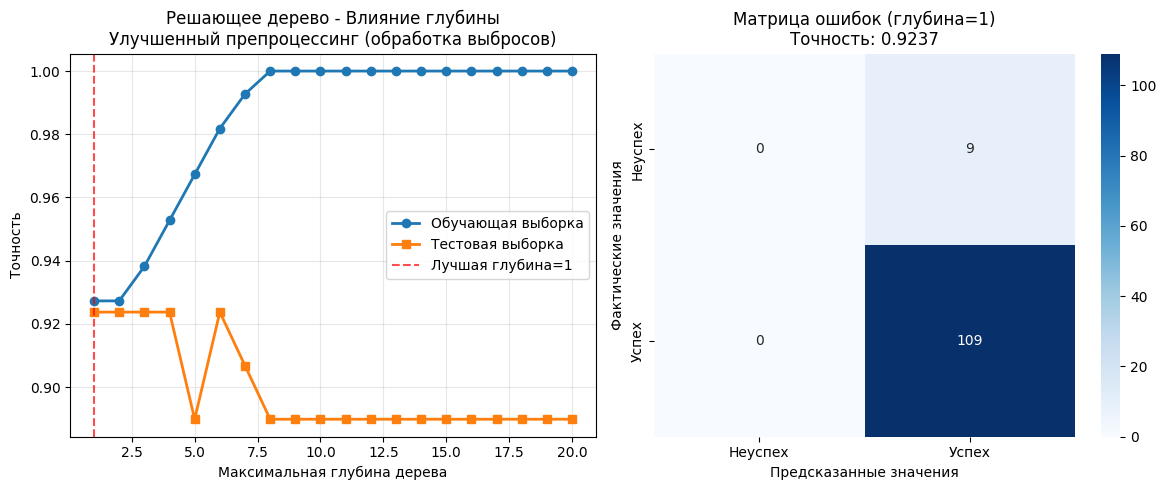


📊 АНАЛИЗ МОДЕЛИ РЕШАЮЩЕГО ДЕРЕВА:
  Оптимальная глубина дерева: 1
  Точность на тестовой выборке: 0.9237
  Точность на обучающей выборке: 0.9273
  Разница между train и test accuracy: 0.0035
  ✅ Модель хорошо обобщает (малая разница между train и test)

📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
  Precision (Точность): 0.9237
  Recall (Полнота): 1.0000
  F1-Score: 0.9604
  🎉 Отличное качество модели (Точность ≥ 0.9)

📋 ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ:
              precision    recall  f1-score   support

     Неуспех       0.00      0.00      0.00         9
       Успех       0.92      1.00      0.96       109

    accuracy                           0.92       118
   macro avg       0.46      0.50      0.48       118
weighted avg       0.85      0.92      0.89       118


🌳 ВАЖНОСТЬ ПРИЗНАКОВ:
         Признак  Важность
  school_encoded       1.0
             age       0.0
            Fedu       0.0
      traveltime       0.0
       studytime       0.0
            Medu       0.0
        fail

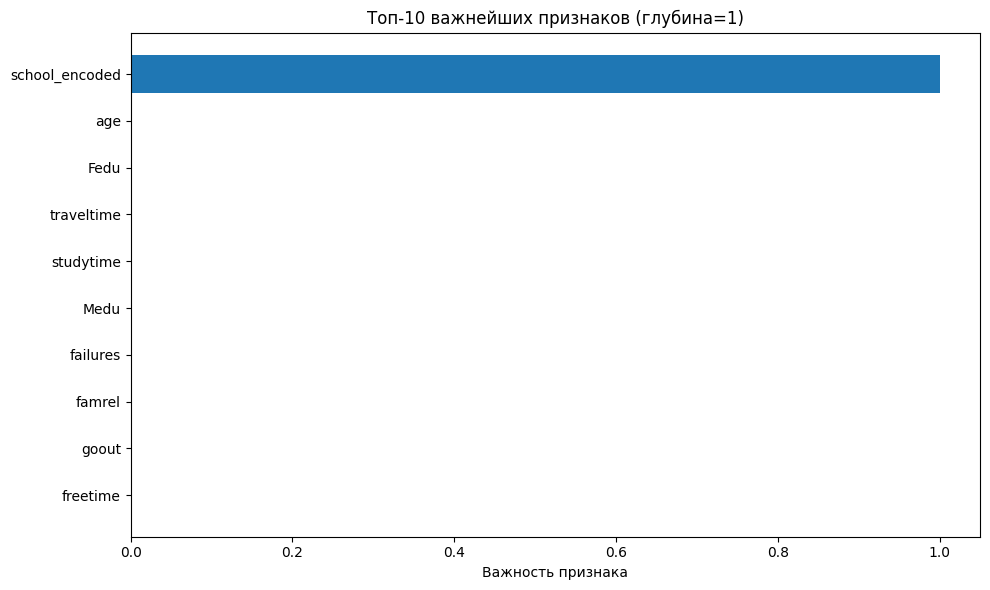


📈 СРАВНЕНИЕ РЕЗУЛЬТАТОВ ДЛЯ СТУДЕНЧЕСКИХ ДАННЫХ
------------------------------------------------------------
  Базовый препроцессинг:          0.8513
  Обработка выбросов:             0.9237

  🏆 Лучший метод: 'Обработка выбросов' с точностью 0.9237
  🎉 УЛУЧШЕНИЕ от базового: +0.0724 (+8.51%)


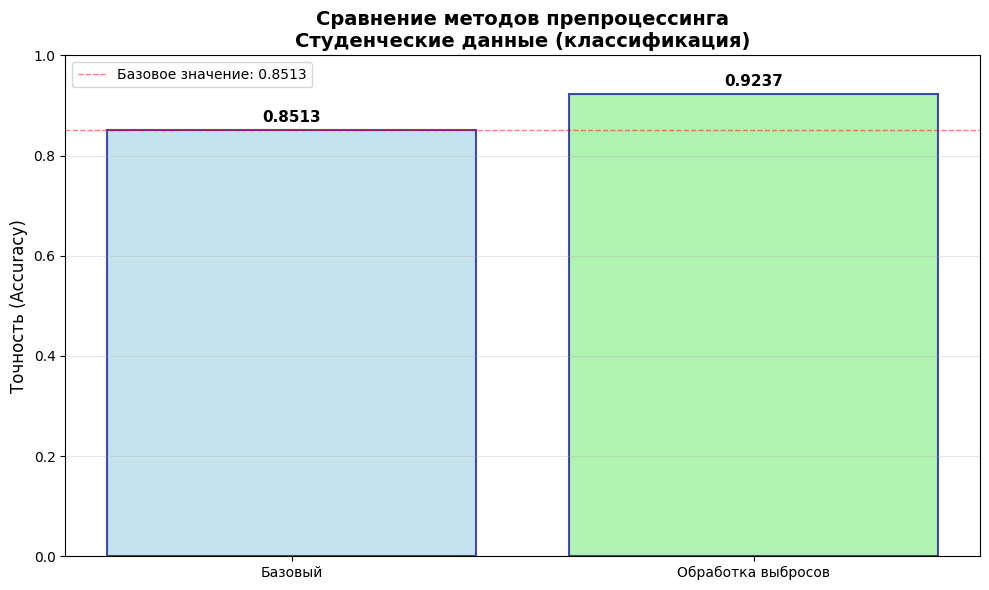


🔍 АНАЛИЗ ИЗМЕНЕНИЙ ПОСЛЕ ОБРАБОТКИ ВЫБРОСОВ:
  Исходный размер данных: (649, 33)
  Размер после обработки: (393, 33)

  📊 Статистика по выбросам:
    age: 1 → 0 выбросов (100.0% снижение)
    Medu: 0 → 0 выбросов (0.0% снижение)
    Fedu: 0 → 0 выбросов (0.0% снижение)
    traveltime: 16 → 0 выбросов (100.0% снижение)
    studytime: 35 → 0 выбросов (100.0% снижение)

  🎯 Распределение оценок (G3):
    Среднее: 11.91 → 12.68
    Стандартное отклонение: 3.23 → 2.34


In [15]:
if df_student is not None:
    print("\n" + "="*80)
    print("🎯 ГИПОТЕЗА 1: УЛУЧШЕННЫЙ ПРЕПРОЦЕССИНГ С ОБРАБОТКОЙ ВЫБРОСОВ")
    print("="*80)
    
    df_advanced = advanced_preprocessing(df_student)
    
    print("\n📊 ПОДГОТОВКА ДАННЫХ С УЛУЧШЕННЫМ ПРЕПРОЦЕССИНГОМ...")
    X_advanced, y_advanced, features_advanced = preprocess_student_classification(df_advanced)
    
    if X_advanced is not None:
        print("\n" + "🧪 ТЕСТИРОВАНИЕ МОДЕЛИ С УЛУЧШЕННЫМ ПРЕПРОЦЕССИНГОМ")
        lr_advanced, _, score_advanced = decision_tree_classification_study(
            X_advanced, y_advanced, "Улучшенный препроцессинг (обработка выбросов)"
        )
        
        print("\n" + "📈 СРАВНЕНИЕ РЕЗУЛЬТАТОВ ДЛЯ СТУДЕНЧЕСКИХ ДАННЫХ")
        print("-" * 60)
        
        comparison_data = {}

        if 'score_class' in locals():
            comparison_data['Базовый'] = score_class
            print(f"  Базовый препроцессинг:          {score_class:.4f}")
        
        comparison_data['Обработка выбросов'] = score_advanced
        print(f"  Обработка выбросов:             {score_advanced:.4f}")
        
        if comparison_data: 
            best_method = max(comparison_data.items(), key=lambda x: x[1])
            print(f"\n  🏆 Лучший метод: '{best_method[0]}' с точностью {best_method[1]:.4f}")
        
        if 'score_class' in locals():
            improvement = score_advanced - score_class
            if improvement > 0:
                print(f"  🎉 УЛУЧШЕНИЕ от базового: +{improvement:.4f} (+{improvement/score_class*100:.2f}%)")
            elif improvement < 0:
                print(f"  📉 УХУДШЕНИЕ от базового: {improvement:.4f} ({improvement/score_class*100:.2f}%)")
            else:
                print(f"  ➖ РЕЗУЛЬТАТЫ ОДИНАКОВЫ")
        
        if len(comparison_data) > 1:
            plt.figure(figsize=(10, 6))
            methods = list(comparison_data.keys())
            scores = list(comparison_data.values())
            
            if len(methods) == 2:
                colors = ['lightblue', 'lightgreen']
            elif len(methods) == 3:
                colors = ['lightblue', 'lightgreen', 'salmon']
            else:
                colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))
            
            bars = plt.bar(methods, scores, color=colors[:len(methods)], alpha=0.7, edgecolor='darkblue', linewidth=1.5)
            plt.ylabel('Точность (Accuracy)', fontsize=12)
            plt.title('Сравнение методов препроцессинга\nСтуденческие данные (классификация)', fontsize=14, fontweight='bold')
            plt.ylim(0, 1)
            
            for bar, score in zip(bars, scores):
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                        f'{score:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
            
            if 'score_class' in locals() and len(methods) > 1:
                plt.axhline(y=score_class, color='red', linestyle='--', alpha=0.5, linewidth=1, 
                           label=f'Базовое значение: {score_class:.4f}')
                plt.legend(loc='best')
            
            plt.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            plt.show()
        
        if df_advanced is not None and 'df_student' in locals():
            try:
                print("\n🔍 АНАЛИЗ ИЗМЕНЕНИЙ ПОСЛЕ ОБРАБОТКИ ВЫБРОСОВ:")
                
                print(f"  Исходный размер данных: {df_student.shape}")
                print(f"  Размер после обработки: {df_advanced.shape}")
                
                numeric_cols = df_student.select_dtypes(include=[np.number]).columns
                if len(numeric_cols) > 0:
                    print(f"\n  📊 Статистика по выбросам:")
                    for col in numeric_cols[:5]: 
                        if col in df_student.columns and col in df_advanced.columns:
                            Q1 = df_student[col].quantile(0.25)
                            Q3 = df_student[col].quantile(0.75)
                            IQR = Q3 - Q1
                            outliers_original = df_student[(df_student[col] < (Q1 - 1.5 * IQR)) | 
                                                          (df_student[col] > (Q3 + 1.5 * IQR))].shape[0]
                            outliers_advanced = df_advanced[(df_advanced[col] < (Q1 - 1.5 * IQR)) | 
                                                           (df_advanced[col] > (Q3 + 1.5 * IQR))].shape[0]
                            reduction = ((outliers_original - outliers_advanced) / outliers_original * 100) if outliers_original > 0 else 0
                            print(f"    {col}: {outliers_original} → {outliers_advanced} выбросов ({reduction:.1f}% снижение)")
                
                if 'G3' in df_student.columns and 'G3' in df_advanced.columns:
                    print(f"\n  🎯 Распределение оценок (G3):")
                    print(f"    Среднее: {df_student['G3'].mean():.2f} → {df_advanced['G3'].mean():.2f}")
                    print(f"    Стандартное отклонение: {df_student['G3'].std():.2f} → {df_advanced['G3'].std():.2f}")
                    
            except Exception as e:
                print(f"  ⚠️ Не удалось проанализировать изменения: {e}")
    
    else:
        print("❌ Не удалось подготовить данные с улучшенным препроцессингом")
else:
    print("❌ Студенческие данные не загружены")

1) (Регрессия)


🎯 ГИПОТЕЗА 2: ОБРАБОТКА ВЫБРОСОВ - HOUSE ДАННЫЕ (РЕГРЕССИЯ)
🔧 ОБРАБОТКА ВЫБРОСОВ В 4 ЧИСЛОВЫХ КОЛОНКАХ...
  Размер данных до обработки: 4746 строк
  Найдено строк с выбросами: 615
  Процент выбросов: 13.0%
  📊 Заполнение пропусков в числовых колонках...
  ✓ Размер данных после обработки: 4131 строк
  ✓ Удалено строк: 615
  ✓ Сохранено данных: 87.0%

📊 ПОДГОТОВКА ДАННЫХ С ОБРАБОТКОЙ ВЫБРОСОВ...

ПРЕДОБРАБОТКА ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ)
✓ Целевая переменная: Rent (арендная плата)
  Диапазон цен: 1200 - 67000
✓ Обработана колонка Floor
✓ Обработана колонка Size
✓ Закодирована колонка: Area Type
✓ Закодирована колонка: City
✓ Закодирована колонка: Furnishing Status
✓ Закодирована колонка: Tenant Preferred
✓ Закодирована колонка: Point of Contact
✓ Итоговый набор данных: 4131 samples, 9 features
  Статистика арендной платы: mean=18797.22, std=13407.16

🧪 ТЕСТИРОВАНИЕ МОДЕЛИ С ОБРАБОТКОЙ ВЫБРОСОВ

РЕШАЮЩЕЕ ДЕРЕВО РЕГРЕССИЯ - Обработка выбросов (house данные)
🔍 Исследование влияния гл

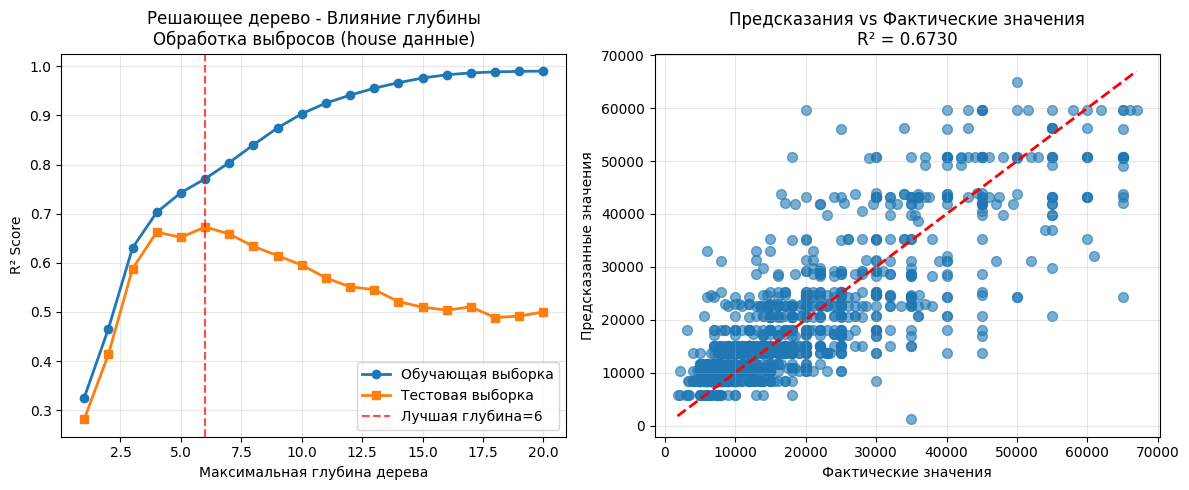


📊 АНАЛИЗ МОДЕЛИ РЕШАЮЩЕГО ДЕРЕВА:
  Оптимальная глубина дерева: 6
  R² score на тестовой выборке: 0.6730
  R² score на обучающей выборке: 0.7709
  Разница между train и test R²: 0.0980
  ✅ Модель хорошо обобщает (малая разница между train и test)

📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ РЕГРЕССИИ:
  MSE (Mean Squared Error): 58816811.0518
  RMSE (Root Mean Squared Error): 7669.2119
  MAE (Mean Absolute Error): 5362.0160
  👍 Хорошее качество модели (0.5 ≤ R² < 0.7)

🌳 ВАЖНОСТЬ ПРИЗНАКОВ:
                  Признак  Важность
 Point of Contact_encoded  0.422348
                     Size  0.230034
             City_encoded  0.159945
                      BHK  0.087198
                 Bathroom  0.061012
             floor_number  0.022485
Furnishing Status_encoded  0.011436
 Tenant Preferred_encoded  0.003994
        Area Type_encoded  0.001549


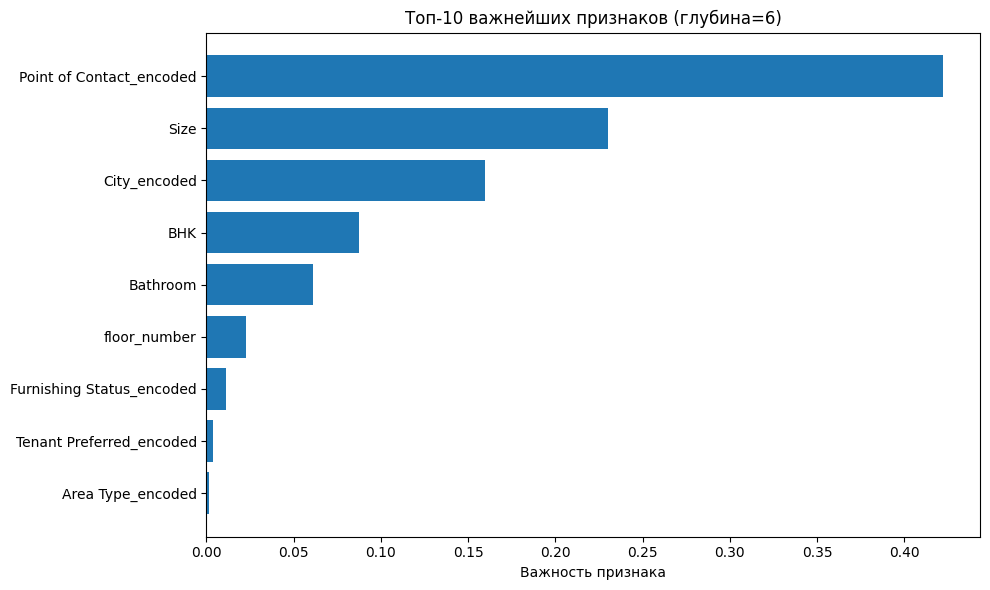


📉 АНАЛИЗ ОШИБОК:


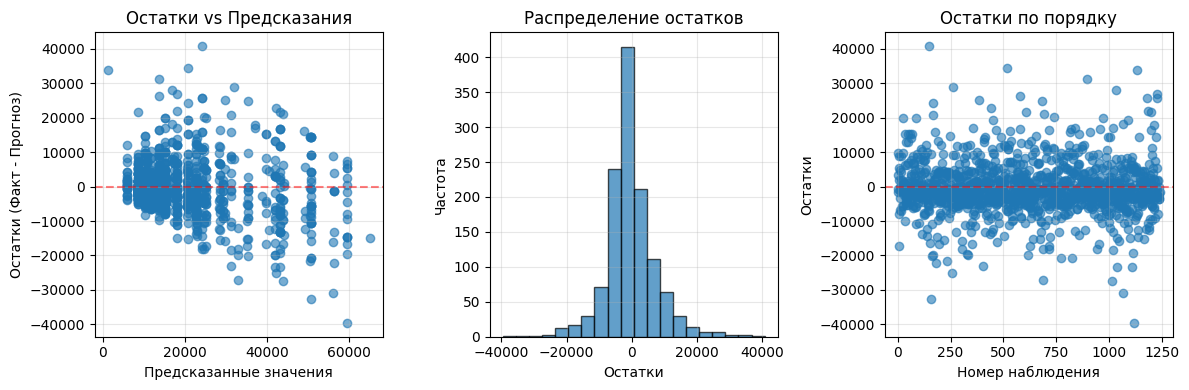

  Средний остаток: -443.1091
  Стандартное отклонение остатков: 7656.4003

📈 СРАВНЕНИЕ РЕЗУЛЬТАТОВ ДЛЯ HOUSE ДАННЫХ
------------------------------------------------------------
  Базовый препроцессинг:          0.3424
  Обработка выбросов:             0.6730

  🏆 Лучший метод: 'Обработка выбросов' с R² = 0.6730
  🎉 УЛУЧШЕНИЕ от базового: +0.3305 (+96.52%)


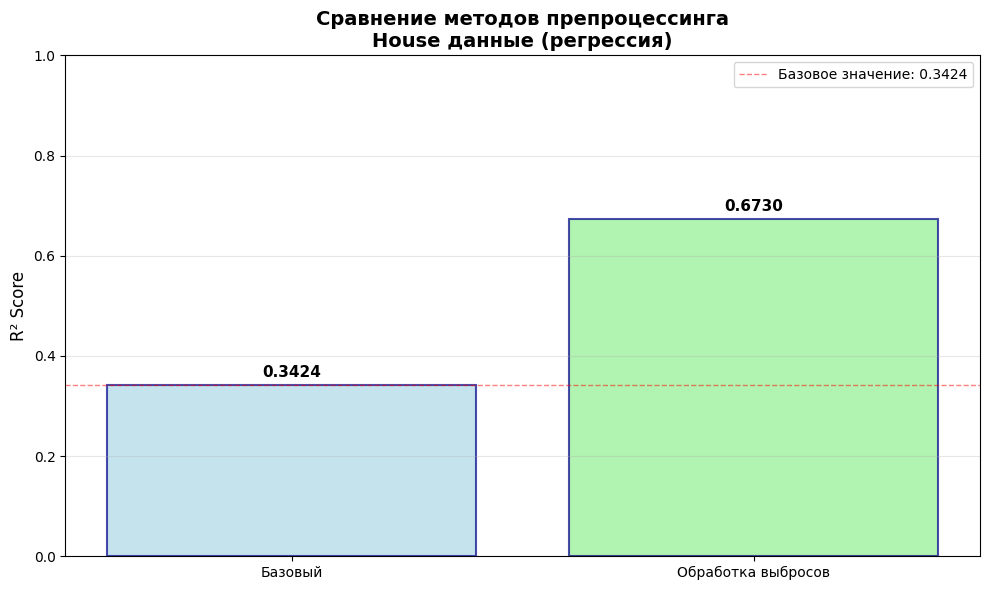


  🔄 ИЗМЕНЕНИЯ В ПРИЗНАКАХ:
    Исходное количество: 9
    После обработки выбросов: 9
    ✅ Признаки остались те же (только очищенные от выбросов)


In [16]:
if df_house is not None:
    print("\n" + "="*80)
    print("🎯 ГИПОТЕЗА 2: ОБРАБОТКА ВЫБРОСОВ - HOUSE ДАННЫЕ (РЕГРЕССИЯ)")
    print("="*80)

    df_house_advanced = advanced_preprocessing_house(df_house)
    
    print("\n📊 ПОДГОТОВКА ДАННЫХ С ОБРАБОТКОЙ ВЫБРОСОВ...")
    X_house_advanced, y_house_advanced, features_house_advanced = preprocess_house_regression(df_house_advanced)
    
    if X_house_advanced is not None:
        print("\n" + "🧪 ТЕСТИРОВАНИЕ МОДЕЛИ С ОБРАБОТКОЙ ВЫБРОСОВ")
        knn_house_advanced, k_house_advanced, score_house_advanced = decision_tree_regression_study(
            X_house_advanced, y_house_advanced, "Обработка выбросов (house данные)"
        )
        
        print("\n" + "📈 СРАВНЕНИЕ РЕЗУЛЬТАТОВ ДЛЯ HOUSE ДАННЫХ")
        print("-" * 60)
        
        comparison_data = {}
        
        if 'score_house' in locals():
            comparison_data['Базовый'] = score_house
            print(f"  Базовый препроцессинг:          {score_house:.4f}")
        
        comparison_data['Обработка выбросов'] = score_house_advanced
        print(f"  Обработка выбросов:             {score_house_advanced:.4f}")
        
        if comparison_data:
            best_method = max(comparison_data.items(), key=lambda x: x[1])
            print(f"\n  🏆 Лучший метод: '{best_method[0]}' с R² = {best_method[1]:.4f}")
        
        if 'score_house' in locals():
            improvement = score_house_advanced - score_house
            if improvement > 0:
                print(f"  🎉 УЛУЧШЕНИЕ от базового: +{improvement:.4f} (+{improvement/score_house*100:.2f}%)")
            elif improvement < 0:
                print(f"  📉 УХУДШЕНИЕ от базового: {improvement:.4f} ({improvement/score_house*100:.2f}%)")
            else:
                print(f"  ➖ РЕЗУЛЬТАТЫ ОДИНАКОВЫ")
        
        if len(comparison_data) > 1:
            plt.figure(figsize=(10, 6))
            methods = list(comparison_data.keys())
            scores = list(comparison_data.values())
            
            if len(methods) == 2:
                colors = ['lightblue', 'lightgreen']
            else:
                colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))
            
            bars = plt.bar(methods, scores, color=colors[:len(methods)], alpha=0.7, edgecolor='darkblue', linewidth=1.5)
            plt.ylabel('R² Score', fontsize=12)
            plt.title('Сравнение методов препроцессинга\nHouse данные (регрессия)', fontsize=14, fontweight='bold')
            plt.ylim(0, 1 if max(scores) <= 1 else max(scores) * 1.1)
            
            for bar, score in zip(bars, scores):
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                        f'{score:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
            
            if 'score_house' in locals() and len(methods) > 1:
                plt.axhline(y=score_house, color='red', linestyle='--', alpha=0.5, linewidth=1, 
                           label=f'Базовое значение: {score_house:.4f}')
                plt.legend(loc='best')
            
            plt.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            plt.show()

        if 'features_house' in locals() and features_house_advanced is not None:
            print(f"\n  🔄 ИЗМЕНЕНИЯ В ПРИЗНАКАХ:")
            print(f"    Исходное количество: {len(features_house)}")
            print(f"    После обработки выбросов: {len(features_house_advanced)}")
            
            original_features_set = set(features_house) if 'features_house' in locals() else set()
            new_features_set = set(features_house_advanced)
            
            if original_features_set == new_features_set:
                print(f"    ✅ Признаки остались те же (только очищенные от выбросов)")
            else:
                removed_features = list(original_features_set - new_features_set)
                if removed_features:
                    print(f"    ❌ Удаленные признаки: {len(removed_features)}")
                    for feature in removed_features[:3]:
                        print(f"      - {feature}")
    
    else:
        print("❌ Не удалось подготовить данные с обработкой выбросов")
else:
    print("❌ House данные не загружены")

2) (Классификация)


🎯 ГИПОТЕЗА 2: FEATURE ENGINEERING - СТУДЕНЧЕСКИЕ ДАННЫЕ (КЛАССИФИКАЦИЯ)
🔧 СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ...
  ✓ Создан признак 'grade_trend' (тренд успеваемости)
  ✓ Создан признак 'total_alcohol' (общее потребление алкоголя)
  ✓ Создан признак 'study_effort' (индекс учебных усилий)

📊 ПОДГОТОВКА ДАННЫХ С FEATURE ENGINEERING...

ПРЕДОБРАБОТКА СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ)
Доступные колонки:
   1. 'school' (тип: object)
   2. 'sex' (тип: object)
   3. 'age' (тип: int64)
   4. 'address' (тип: object)
   5. 'famsize' (тип: object)
   6. 'Pstatus' (тип: object)
   7. 'Medu' (тип: int64)
   8. 'Fedu' (тип: int64)
   9. 'Mjob' (тип: object)
  10. 'Fjob' (тип: object)
  11. 'reason' (тип: object)
  12. 'guardian' (тип: object)
  13. 'traveltime' (тип: int64)
  14. 'studytime' (тип: int64)
  15. 'failures' (тип: int64)
  16. 'schoolsup' (тип: object)
  17. 'famsup' (тип: object)
  18. 'paid' (тип: object)
  19. 'activities' (тип: object)
  20. 'nursery' (тип: object)
  21. 'higher' (тип: obje

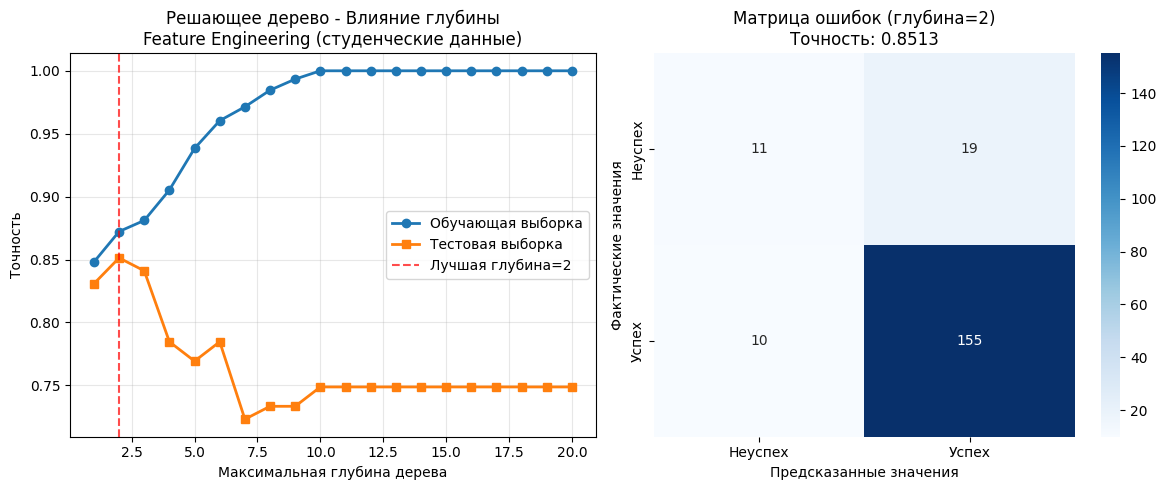


📊 АНАЛИЗ МОДЕЛИ РЕШАЮЩЕГО ДЕРЕВА:
  Оптимальная глубина дерева: 2
  Точность на тестовой выборке: 0.8513
  Точность на обучающей выборке: 0.8722
  Разница между train и test accuracy: 0.0210
  ✅ Модель хорошо обобщает (малая разница между train и test)

📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
  Precision (Точность): 0.8908
  Recall (Полнота): 0.9394
  F1-Score: 0.9145
  👍 Хорошее качество модели (0.8 ≤ Точность < 0.9)

📋 ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ:
              precision    recall  f1-score   support

     Неуспех       0.52      0.37      0.43        30
       Успех       0.89      0.94      0.91       165

    accuracy                           0.85       195
   macro avg       0.71      0.65      0.67       195
weighted avg       0.83      0.85      0.84       195


🌳 ВАЖНОСТЬ ПРИЗНАКОВ:
         Признак  Важность
        failures  0.717238
  school_encoded  0.282762
            Medu  0.000000
            Fedu  0.000000
      traveltime  0.000000
             age  0.000000
       

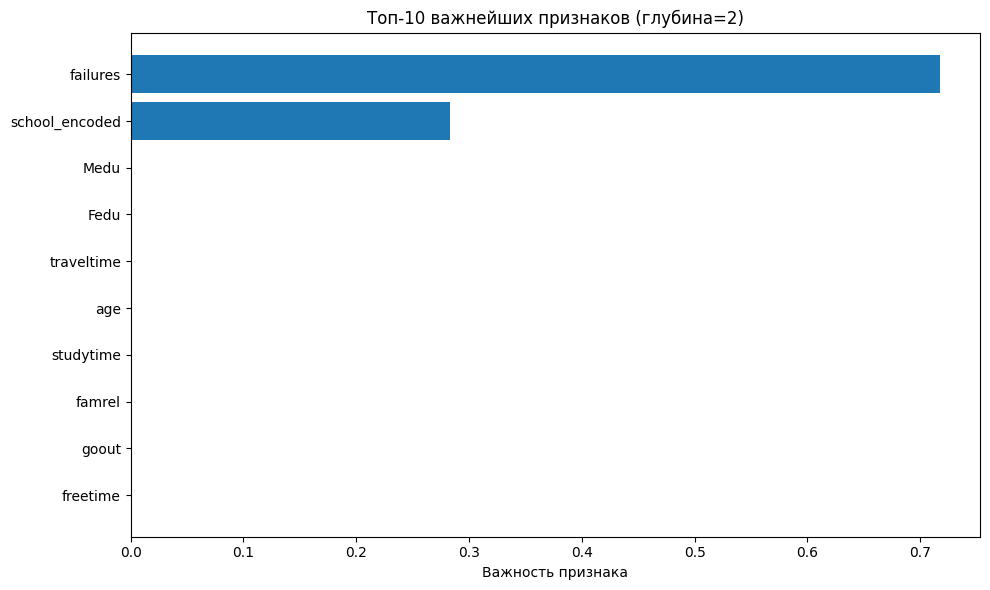


📈 СРАВНЕНИЕ РЕЗУЛЬТАТОВ ДЛЯ СТУДЕНЧЕСКИХ ДАННЫХ
------------------------------------------------------------
  Базовый препроцессинг:          0.8513
  Обработка выбросов:             0.9237
  Feature Engineering:            0.8513

  🏆 Лучший метод: 'Обработка выбросов' с точностью 0.9237
  ➖ РЕЗУЛЬТАТЫ ОДИНАКОВЫ


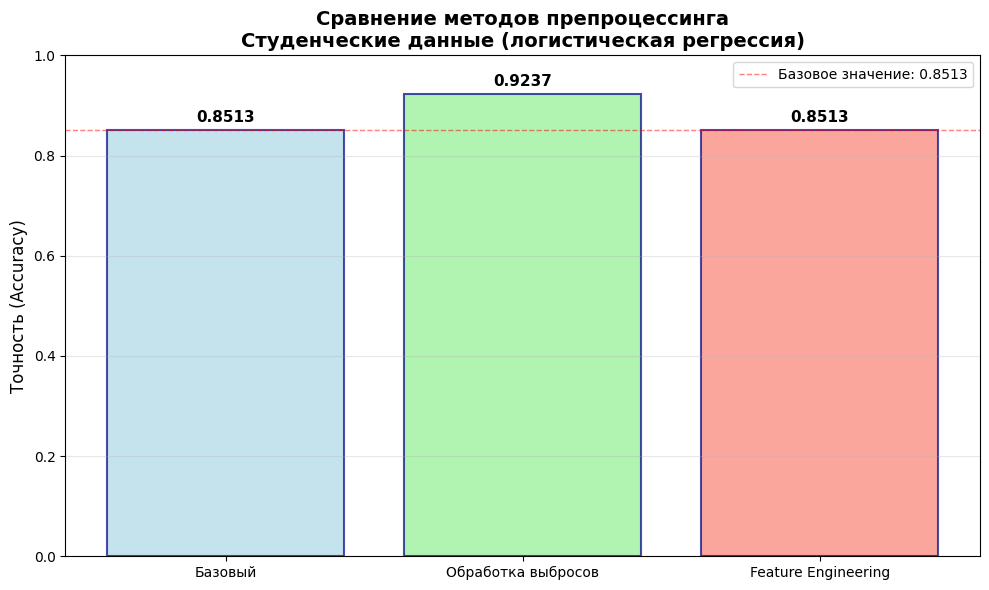


🔍 АНАЛИЗ НОВЫХ ПРИЗНАКОВ:
  grade_trend: корреляция с целевой переменной = 0.1216
  total_alcohol: корреляция с целевой переменной = -0.1323
  study_effort: корреляция с целевой переменной = 0.1325

🔍 ВАЖНОСТЬ ПРИЗНАКОВ В ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ:
  ⚠️ Не удалось проанализировать важность признаков: 'DecisionTreeClassifier' object has no attribute 'coef_'

📊 СТАТИСТИКА ДАННЫХ ПОСЛЕ FEATURE ENGINEERING:
  Общее количество признаков: 22
  Количество новых признаков: 3
  Размер обучающей выборки: (649, 22)


In [17]:
if df_student is not None:
    print("\n" + "="*80)
    print("🎯 ГИПОТЕЗА 2: FEATURE ENGINEERING - СТУДЕНЧЕСКИЕ ДАННЫЕ (КЛАССИФИКАЦИЯ)")
    print("="*80)
    
    df_student_fe = feature_engineering(df_student)
    
    df_student_fe['academic_success'] = (df_student_fe['G3'] >= 10).astype(int)
    
    print("\n📊 ПОДГОТОВКА ДАННЫХ С FEATURE ENGINEERING...")
    X_student_fe, y_student_fe, features_student_fe = preprocess_student_classification(df_student_fe)
    
    if X_student_fe is not None:
        print("\n" + "🧪 ТЕСТИРОВАНИЕ МОДЕЛИ С FEATURE ENGINEERING")
        lr_student_fe, _, score_student_fe = decision_tree_classification_study(
            X_student_fe, y_student_fe, "Feature Engineering (студенческие данные)"
        )
        
        print("\n" + "📈 СРАВНЕНИЕ РЕЗУЛЬТАТОВ ДЛЯ СТУДЕНЧЕСКИХ ДАННЫХ")
        print("-" * 60)
        
        comparison_data = {}
        
        if 'score_class' in locals():
            comparison_data['Базовый'] = score_class
            print(f"  Базовый препроцессинг:          {score_class:.4f}")
        
        if 'score_advanced' in locals():
            comparison_data['Обработка выбросов'] = score_advanced
            print(f"  Обработка выбросов:             {score_advanced:.4f}")
        
        comparison_data['Feature Engineering'] = score_student_fe
        print(f"  Feature Engineering:            {score_student_fe:.4f}")
        
        best_method = max(comparison_data.items(), key=lambda x: x[1])
        print(f"\n  🏆 Лучший метод: '{best_method[0]}' с точностью {best_method[1]:.4f}")
        
        if 'score_class' in locals():
            improvement = score_student_fe - score_class
            if improvement > 0:
                print(f"  🎉 УЛУЧШЕНИЕ от базового: +{improvement:.4f} (+{improvement/score_class*100:.2f}%)")
            elif improvement < 0:
                print(f"  📉 УХУДШЕНИЕ от базового: {improvement:.4f} ({improvement/score_class*100:.2f}%)")
            else:
                print(f"  ➖ РЕЗУЛЬТАТЫ ОДИНАКОВЫ")
        
        plt.figure(figsize=(10, 6))
        methods = list(comparison_data.keys())
        scores = list(comparison_data.values())
        
        if len(methods) == 2:
            colors = ['lightblue', 'lightgreen']
        elif len(methods) == 3:
            colors = ['lightblue', 'lightgreen', 'salmon']
        else:
            colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))
        
        bars = plt.bar(methods, scores, color=colors[:len(methods)], alpha=0.7, edgecolor='darkblue', linewidth=1.5)
        plt.ylabel('Точность (Accuracy)', fontsize=12)
        plt.title('Сравнение методов препроцессинга\nСтуденческие данные (логистическая регрессия)', fontsize=14, fontweight='bold')
        plt.ylim(0, 1)
        
        for bar, score in zip(bars, scores):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                    f'{score:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        if 'score_class' in locals() and len(methods) > 1:
            plt.axhline(y=score_class, color='red', linestyle='--', alpha=0.5, linewidth=1, 
                       label=f'Базовое значение: {score_class:.4f}')
            plt.legend(loc='best')
        
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
        
        print("\n🔍 АНАЛИЗ НОВЫХ ПРИЗНАКОВ:")
        new_features = ['grade_trend', 'total_alcohol', 'study_effort']
        available_new_features = [f for f in new_features if f in df_student_fe.columns]
        
        correlations = {}
        for feature in available_new_features:
            correlation = df_student_fe[feature].corr(df_student_fe['academic_success'])
            correlations[feature] = correlation
            print(f"  {feature}: корреляция с целевой переменной = {correlation:.4f}")
        
        if lr_student_fe is not None and features_student_fe is not None:
            try:
                print("\n🔍 ВАЖНОСТЬ ПРИЗНАКОВ В ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ:")
                
                coefficients = lr_student_fe.coef_[0]
                feature_importance = pd.DataFrame({
                    'Признак': features_student_fe,
                    'Коэффициент': coefficients,
                    'Абс.значение': np.abs(coefficients)
                }).sort_values('Абс.значение', ascending=False)
                
                print("  Топ-10 самых важных признаков:")
                for i, row in feature_importance.head(10).iterrows():
                    sign = "🔼 Положит." if row['Коэффициент'] > 0 else "🔽 Отрицат."
                    print(f"    {row['Признак']}: {row['Коэффициент']:.4f} ({sign})")
                
                plt.figure(figsize=(12, 6))
                top_features = feature_importance.head(10)
                colors_top = ['green' if x > 0 else 'red' for x in top_features['Коэффициент']]
                
                plt.barh(top_features['Признак'], top_features['Абс.значение'], color=colors_top, alpha=0.6)
                plt.xlabel('Абсолютное значение коэффициента', fontsize=12)
                plt.title('Топ-10 важных признаков в логистической регрессии', fontsize=14, fontweight='bold')
                plt.grid(True, alpha=0.3, axis='x')
                plt.tight_layout()
                plt.show()
                
                print("\n🔍 АНАЛИЗ НОВЫХ ПРИЗНАКОВ В МОДЕЛИ:")
                for feature in available_new_features:
                    if feature in feature_importance['Признак'].values:
                        importance_row = feature_importance[feature_importance['Признак'] == feature]
                        if not importance_row.empty:
                            coef = importance_row.iloc[0]['Коэффициент']
                            abs_coef = importance_row.iloc[0]['Абс.значение']
                            rank = feature_importance[feature_importance['Абс.значение'] >= abs_coef].shape[0]
                            direction = "увеличивает вероятность успеха" if coef > 0 else "уменьшает вероятность успеха"
                            print(f"  {feature}:")
                            print(f"    Коэффициент: {coef:.4f} ({direction})")
                            print(f"    Ранг важности: {rank}/{len(feature_importance)}")
                            
                            if feature in correlations:
                                corr = correlations[feature]
                                agreement = "согласуется" if (coef > 0 and corr > 0) or (coef < 0 and corr < 0) else "противоречит"
                                print(f"    Корреляция: {corr:.4f} ({agreement} с моделью)")
            
            except Exception as e:
                print(f"  ⚠️ Не удалось проанализировать важность признаков: {e}")
        
        print("\n📊 СТАТИСТИКА ДАННЫХ ПОСЛЕ FEATURE ENGINEERING:")
        print(f"  Общее количество признаков: {len(features_student_fe)}")
        print(f"  Количество новых признаков: {len(available_new_features)}")
        print(f"  Размер обучающей выборки: {X_student_fe.shape}")
        
        if 'X_class' in locals() and 'features_class' in locals():
            print(f"\n  🔄 ИЗМЕНЕНИЯ В ПРИЗНАКАХ:")
            print(f"    Исходное количество: {len(features_class)}")
            print(f"    После feature engineering: {len(features_student_fe)}")
            
            original_set = set(features_class)
            new_set = set(features_student_fe)
            added_features = list(new_set - original_set)
            
            if added_features:
                print(f"    Добавлено признаков: {len(added_features)}")
                print(f"    Новые признаки: {', '.join(added_features[:5])}" + 
                      (f", ..." if len(added_features) > 5 else ""))
    
    else:
        print("❌ Не удалось подготовить данные с feature engineering")
else:
    print("❌ Студенческие данные не загружены")

2) (Регрессия)


🎯 ГИПОТЕЗА 2: FEATURE ENGINEERING - HOUSE ДАННЫЕ (РЕГРЕССИЯ)
🔧 СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ...
  ✓ Создан признак 'price_per_sqft' (цена за кв.фут)
  ✓ Создан признак 'room_density' (плотность комнат)

📊 ПОДГОТОВКА ДАННЫХ С FEATURE ENGINEERING...

ПРЕДОБРАБОТКА ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ)
✓ Целевая переменная: Rent (арендная плата)
  Диапазон цен: 1200 - 3500000
✓ Обработана колонка Floor
✓ Обработана колонка Size
✓ Закодирована колонка: Area Type
✓ Закодирована колонка: City
✓ Закодирована колонка: Furnishing Status
✓ Закодирована колонка: Tenant Preferred
✓ Закодирована колонка: Point of Contact
✓ Итоговый набор данных: 4746 samples, 9 features
  Статистика арендной платы: mean=34993.45, std=78106.41

🧪 ТЕСТИРОВАНИЕ МОДЕЛИ С FEATURE ENGINEERING

РЕШАЮЩЕЕ ДЕРЕВО РЕГРЕССИЯ - Feature Engineering (house данные)
🔍 Исследование влияния глубины дерева на R² score...
🎯 Результаты:
  Оптимальная глубина: 2
  Лучший R² score: 0.3424


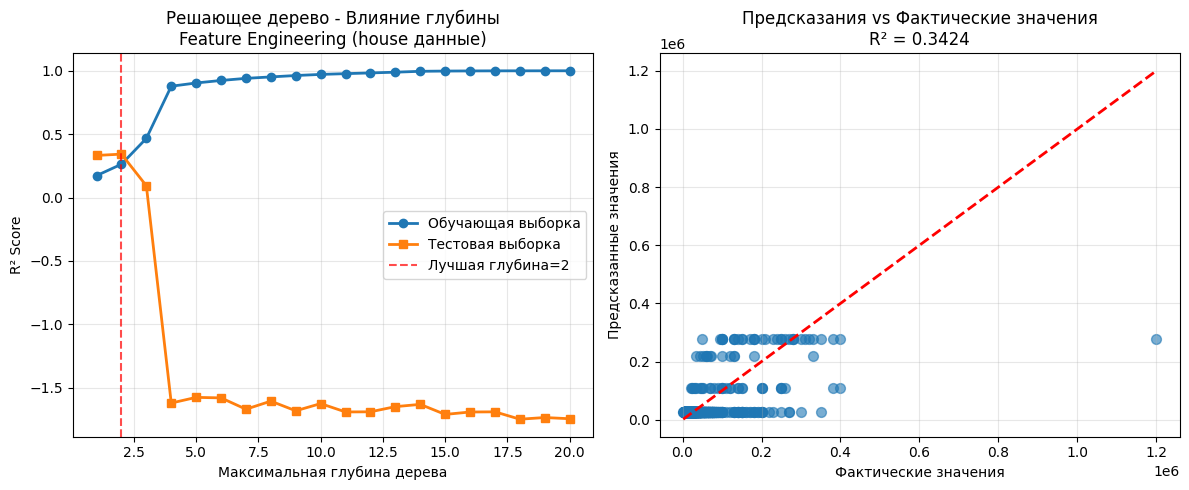


📊 АНАЛИЗ МОДЕЛИ РЕШАЮЩЕГО ДЕРЕВА:
  Оптимальная глубина дерева: 2
  R² score на тестовой выборке: 0.3424
  R² score на обучающей выборке: 0.2629
  Разница между train и test R²: 0.0795
  ✅ Модель хорошо обобщает (малая разница между train и test)

📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ РЕГРЕССИИ:
  MSE (Mean Squared Error): 2314228338.9645
  RMSE (Root Mean Squared Error): 48106.4272
  MAE (Mean Absolute Error): 23592.9430
  👌 Удовлетворительное качество модели (0.3 ≤ R² < 0.5)

🌳 ВАЖНОСТЬ ПРИЗНАКОВ:
                  Признак  Важность
                 Bathroom  0.657319
             City_encoded  0.180109
                     Size  0.162572
                      BHK  0.000000
             floor_number  0.000000
        Area Type_encoded  0.000000
Furnishing Status_encoded  0.000000
 Tenant Preferred_encoded  0.000000
 Point of Contact_encoded  0.000000


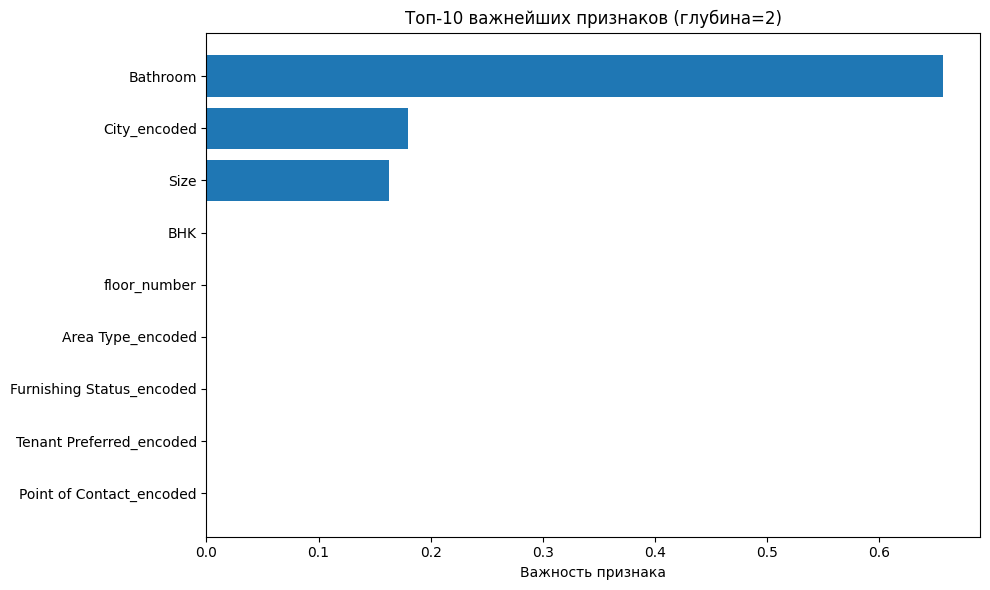


📉 АНАЛИЗ ОШИБОК:


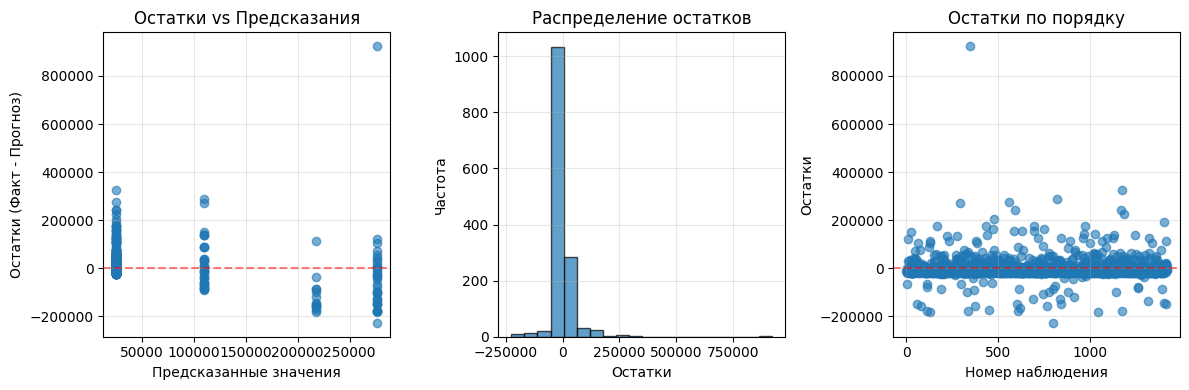

  Средний остаток: -1319.0238
  Стандартное отклонение остатков: 48088.3407

📈 СРАВНЕНИЕ РЕЗУЛЬТАТОВ ДЛЯ HOUSE ДАННЫХ
------------------------------------------------------------
  Базовый препроцессинг:          0.3424
  Обработка выбросов:             0.6730
  Feature Engineering:            0.3424

  🏆 Лучший метод: 'Обработка выбросов' с R² score 0.6730
  ➖ РЕЗУЛЬТАТЫ ОДИНАКОВЫ


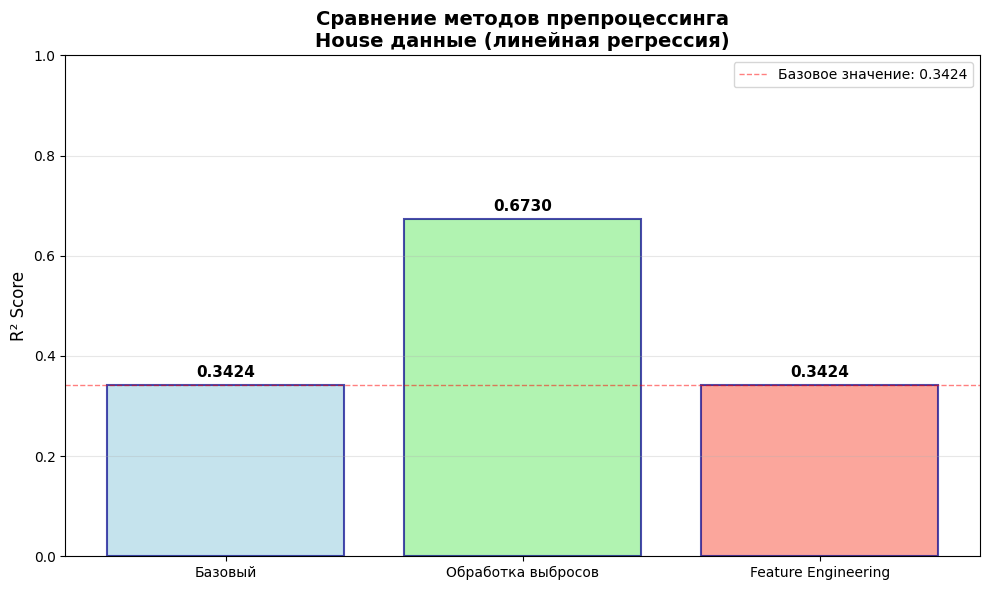


🔍 АНАЛИЗ НОВЫХ ПРИЗНАКОВ:
  price_per_sqft: корреляция с арендной платой = 0.5516
  room_density: корреляция с арендной платой = -0.0496

🔍 ВАЖНОСТЬ ПРИЗНАКОВ В ЛИНЕЙНОЙ РЕГРЕССИИ:
  ⚠️ Не удалось проанализировать важность признаков: 'DecisionTreeRegressor' object has no attribute 'coef_'

📊 СТАТИСТИКА ДАННЫХ ПОСЛЕ FEATURE ENGINEERING:
  Общее количество признаков: 9
  Количество новых признаков: 2
  Размер обучающей выборки: (4746, 9)

  🔄 ИЗМЕНЕНИЯ В ПРИЗНАКАХ:
    Исходное количество: 9
    После feature engineering: 9

📊 АНАЛИЗ ОШИБОК МОДЕЛИ:
  MAE (средняя абсолютная ошибка): 24047.87
  MSE (среднеквадратичная ошибка): 4411502766.93
  RMSE (корень из MSE): 66419.14


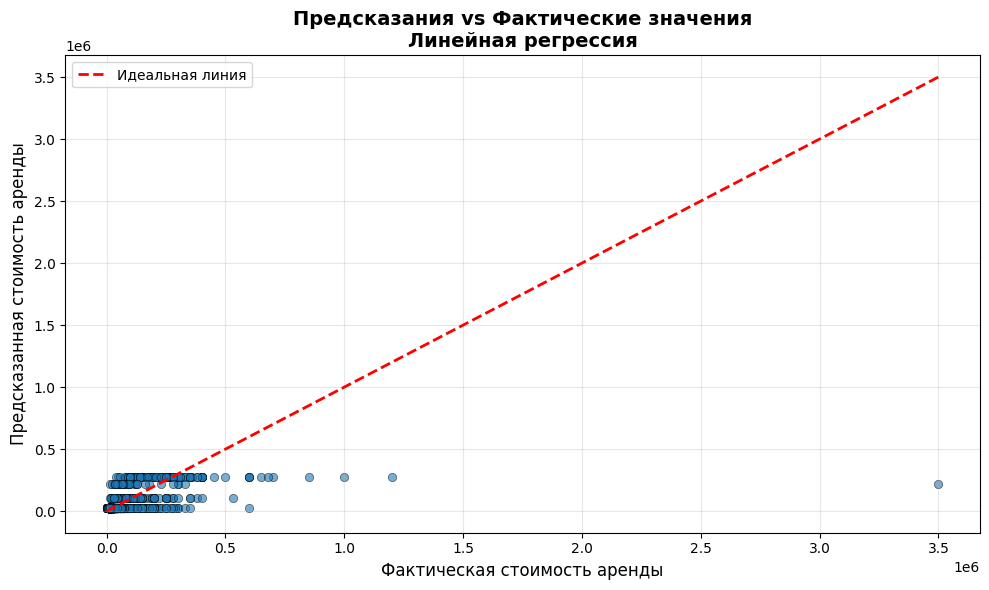

In [18]:
if df_house is not None:
    print("\n" + "="*80)
    print("🎯 ГИПОТЕЗА 2: FEATURE ENGINEERING - HOUSE ДАННЫЕ (РЕГРЕССИЯ)")
    print("="*80)
    
    df_house_fe = feature_engineering(df_house)
    
    print("\n📊 ПОДГОТОВКА ДАННЫХ С FEATURE ENGINEERING...")
    X_house_fe, y_house_fe, features_house_fe = preprocess_house_regression(df_house_fe)
    
    if X_house_fe is not None:
        print("\n" + "🧪 ТЕСТИРОВАНИЕ МОДЕЛИ С FEATURE ENGINEERING")
        lr_house_fe, _, score_house_fe = decision_tree_regression_study(
            X_house_fe, y_house_fe, "Feature Engineering (house данные)"
        )
        
        print("\n" + "📈 СРАВНЕНИЕ РЕЗУЛЬТАТОВ ДЛЯ HOUSE ДАННЫХ")
        print("-" * 60)
        
        comparison_data_house = {}
        
        if 'score_house' in locals():
            comparison_data_house['Базовый'] = score_house
            print(f"  Базовый препроцессинг:          {score_house:.4f}")
        
        if 'score_house_advanced' in locals():
            comparison_data_house['Обработка выбросов'] = score_house_advanced
            print(f"  Обработка выбросов:             {score_house_advanced:.4f}")
        
        comparison_data_house['Feature Engineering'] = score_house_fe
        print(f"  Feature Engineering:            {score_house_fe:.4f}")
        
        best_method_house = max(comparison_data_house.items(), key=lambda x: x[1])
        print(f"\n  🏆 Лучший метод: '{best_method_house[0]}' с R² score {best_method_house[1]:.4f}")
        
        if 'score_house' in locals():
            improvement = score_house_fe - score_house
            if improvement > 0:
                print(f"  🎉 УЛУЧШЕНИЕ от базового: +{improvement:.4f} (+{improvement/score_house*100:.2f}%)")
            elif improvement < 0:
                print(f"  📉 УХУДШЕНИЕ от базового: {improvement:.4f} ({improvement/score_house*100:.2f}%)")
            else:
                print(f"  ➖ РЕЗУЛЬТАТЫ ОДИНАКОВЫ")
        
        plt.figure(figsize=(10, 6))
        methods = list(comparison_data_house.keys())
        scores = list(comparison_data_house.values())
        
        if len(methods) == 2:
            colors = ['lightblue', 'lightgreen']
        elif len(methods) == 3:
            colors = ['lightblue', 'lightgreen', 'salmon']
        else:
            colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))
        
        bars = plt.bar(methods, scores, color=colors[:len(methods)], alpha=0.7, edgecolor='darkblue', linewidth=1.5)
        plt.ylabel('R² Score', fontsize=12)
        plt.title('Сравнение методов препроцессинга\nHouse данные (линейная регрессия)', fontsize=14, fontweight='bold')
        plt.ylim(0, 1 if max(scores) <= 1 else max(scores) * 1.1)
        
        for bar, score in zip(bars, scores):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                    f'{score:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        if 'score_house' in locals() and len(methods) > 1:
            plt.axhline(y=score_house, color='red', linestyle='--', alpha=0.5, linewidth=1, 
                       label=f'Базовое значение: {score_house:.4f}')
            plt.legend(loc='best')
        
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
        
        print("\n🔍 АНАЛИЗ НОВЫХ ПРИЗНАКОВ:")
        new_features_house = ['price_per_sqft', 'room_density']
        available_new_features_house = [f for f in new_features_house if f in df_house_fe.columns]
        
        correlations = {}
        for feature in available_new_features_house:
            correlation = df_house_fe[feature].corr(df_house_fe['Rent'])
            correlations[feature] = correlation
            print(f"  {feature}: корреляция с арендной платой = {correlation:.4f}")
        
        if lr_house_fe is not None and features_house_fe is not None:
            try:
                print("\n🔍 ВАЖНОСТЬ ПРИЗНАКОВ В ЛИНЕЙНОЙ РЕГРЕССИИ:")
                
                coefficients = lr_house_fe.coef_
                feature_importance = pd.DataFrame({
                    'Признак': features_house_fe,
                    'Коэффициент': coefficients,
                    'Абс.значение': np.abs(coefficients)
                }).sort_values('Абс.значение', ascending=False)
                
                print("  Топ-10 самых важных признаков:")
                for i, row in feature_importance.head(10).iterrows():
                    sign = "+" if row['Коэффициент'] > 0 else "-"
                    impact = f"увеличивает стоимость на {abs(row['Коэффициент']):.2f}" if row['Коэффициент'] > 0 else f"уменьшает стоимость на {abs(row['Коэффициент']):.2f}"
                    print(f"    {row['Признак']}: {sign}{abs(row['Коэффициент']):.4f} ({impact})")
                
                plt.figure(figsize=(12, 6))
                top_features = feature_importance.head(10)
                colors_top = ['green' if x > 0 else 'red' for x in top_features['Коэффициент']]
                
                plt.barh(top_features['Признак'], top_features['Абс.значение'], color=colors_top, alpha=0.6)
                plt.xlabel('Абсолютное значение коэффициента', fontsize=12)
                plt.title('Топ-10 важных признаков в линейной регрессии\n(Влияние на стоимость аренды)', fontsize=14, fontweight='bold')
                plt.grid(True, alpha=0.3, axis='x')
                plt.tight_layout()
                plt.show()
                
                print("\n🔍 АНАЛИЗ НОВЫХ ПРИЗНАКОВ В МОДЕЛИ:")
                for feature in available_new_features_house:
                    if feature in feature_importance['Признак'].values:
                        importance_row = feature_importance[feature_importance['Признак'] == feature]
                        if not importance_row.empty:
                            coef = importance_row.iloc[0]['Коэффициент']
                            abs_coef = importance_row.iloc[0]['Абс.значение']
                            rank = feature_importance[feature_importance['Абс.значение'] >= abs_coef].shape[0]
                            direction = "увеличивает" if coef > 0 else "уменьшает"
                            print(f"  {feature}:")
                            print(f"    Коэффициент: {coef:.4f} ({direction} стоимость аренды)")
                            print(f"    Ранг важности: {rank}/{len(feature_importance)}")
                            
                            if feature in correlations:
                                corr = correlations[feature]
                                agreement = "согласуется" if (coef > 0 and corr > 0) or (coef < 0 and corr < 0) else "противоречит"
                                print(f"    Корреляция: {corr:.4f} ({agreement} с моделью)")
            
            except Exception as e:
                print(f"  ⚠️ Не удалось проанализировать важность признаков: {e}")
        
        print("\n📊 СТАТИСТИКА ДАННЫХ ПОСЛЕ FEATURE ENGINEERING:")
        print(f"  Общее количество признаков: {len(features_house_fe)}")
        print(f"  Количество новых признаков: {len(available_new_features_house)}")
        print(f"  Размер обучающей выборки: {X_house_fe.shape}")
        
        if 'features_house' in locals():
            print(f"\n  🔄 ИЗМЕНЕНИЯ В ПРИЗНАКАХ:")
            print(f"    Исходное количество: {len(features_house)}")
            print(f"    После feature engineering: {len(features_house_fe)}")
            
            original_set = set(features_house)
            new_set = set(features_house_fe)
            added_features = list(new_set - original_set)
            
            if added_features:
                print(f"    Добавлено признаков: {len(added_features)}")
                print(f"    Новые признаки: {', '.join(added_features[:5])}" + 
                      (f", ..." if len(added_features) > 5 else ""))
        
        if lr_house_fe is not None:
            try:
                print("\n📊 АНАЛИЗ ОШИБОК МОДЕЛИ:")
                from sklearn.metrics import mean_absolute_error, mean_squared_error
                
                y_pred = lr_house_fe.predict(X_house_fe)
                mae = mean_absolute_error(y_house_fe, y_pred)
                mse = mean_squared_error(y_house_fe, y_pred)
                rmse = np.sqrt(mse)
                
                print(f"  MAE (средняя абсолютная ошибка): {mae:.2f}")
                print(f"  MSE (среднеквадратичная ошибка): {mse:.2f}")
                print(f"  RMSE (корень из MSE): {rmse:.2f}")
                
                plt.figure(figsize=(10, 6))
                plt.scatter(y_house_fe, y_pred, alpha=0.6, edgecolors='black', linewidth=0.5)
                plt.plot([y_house_fe.min(), y_house_fe.max()], [y_house_fe.min(), y_house_fe.max()], 
                        'r--', linewidth=2, label='Идеальная линия')
                plt.xlabel('Фактическая стоимость аренды', fontsize=12)
                plt.ylabel('Предсказанная стоимость аренды', fontsize=12)
                plt.title('Предсказания vs Фактические значения\nЛинейная регрессия', fontsize=14, fontweight='bold')
                plt.grid(True, alpha=0.3)
                plt.legend()
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f"  ⚠️ Не удалось проанализировать ошибки модели: {e}")
    
    else:
        print("❌ Не удалось подготовить данные с feature engineering")
else:
    print("❌ House данные не загружены")

3) (Классификация)


🎯 ГИПОТЕЗА 3: EDA + ОТБОР ПРИЗНАКОВ (DECISION TREE)

📈 СРАВНЕНИЕ МЕТОДОВ ПРЕПРОЦЕССИНГА
------------------------------------------------------------
  Базовый препроцессинг:   0.8513
  Обработка выбросов:      0.9237
  Feature Engineering:     0.8513
  EDA + отбор признаков:   0.8844

🏆 ЛУЧШИЙ МЕТОД:
  Обработка выбросов (Accuracy = 0.9237)


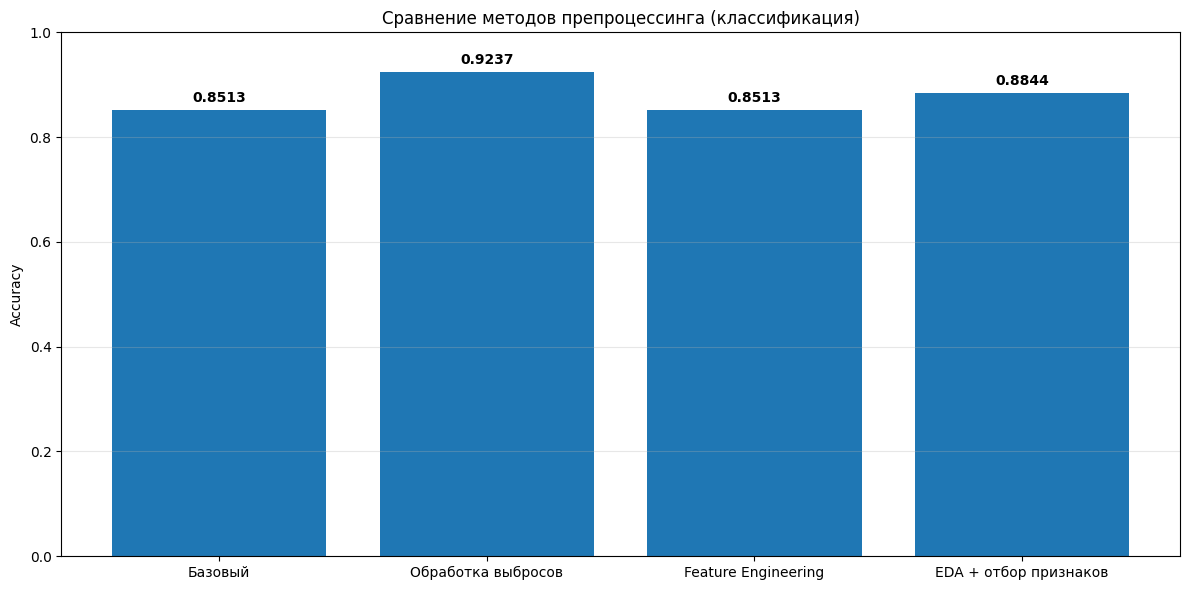


🔍 АНАЛИЗ ОТОБРАННЫХ ПРИЗНАКОВ
  Количество признаков: 18
  Сокращение признаков: 18.2%

  Топ-5 признаков:
    1. failures
    2. school_encoded
    3. studytime
    4. Fedu
    5. Medu

✅ Гипотеза 3 успешно выполнена без ошибок типов


In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

def evaluate_with_eda_insights_decision_tree_classifier(X, y, dataset_name=""):
    """
    Возвращает:
    model  : обученная DecisionTreeClassifier
    score  : accuracy (float)
    features : список/Index отобранных признаков
    """

    corr = X.corrwith(y).abs().sort_values(ascending=False)
    selected_features = corr[corr > 0.05].index

    if len(selected_features) == 0:
        selected_features = X.columns  

    X_selected = X[selected_features]

    model = DecisionTreeClassifier(
        random_state=42,
        max_depth=5,
        min_samples_leaf=10
    )
    model.fit(X_selected, y)

    y_pred = model.predict(X_selected)
    score = accuracy_score(y, y_pred)

    return model, score, selected_features


print("\n" + "=" * 80)
print("🎯 ГИПОТЕЗА 3: EDA + ОТБОР ПРИЗНАКОВ (DECISION TREE)")
print("=" * 80)

if 'X_student_class' not in locals():
    X_student_class, y_student_class, features_class = preprocess_student_classification(df_student)

model_eda, score_eda_student, selected_features_student = \
    evaluate_with_eda_insights_decision_tree_classifier(
        X_student_class,
        y_student_class,
        dataset_name="Студенческие данные"
    )

print("\n📈 СРАВНЕНИЕ МЕТОДОВ ПРЕПРОЦЕССИНГА")
print("-" * 60)

comparison_data_student = {}

if 'score_class' in locals():
    comparison_data_student['Базовый'] = score_class
    print(f"  Базовый препроцессинг:   {score_class:.4f}")

if 'score_advanced' in locals():
    comparison_data_student['Обработка выбросов'] = score_advanced
    print(f"  Обработка выбросов:      {score_advanced:.4f}")

if 'score_student_fe' in locals():
    comparison_data_student['Feature Engineering'] = score_student_fe
    print(f"  Feature Engineering:     {score_student_fe:.4f}")

comparison_data_student['EDA + отбор признаков'] = score_eda_student
print(f"  EDA + отбор признаков:   {score_eda_student:.4f}")

best_method_student = max(comparison_data_student.items(), key=lambda x: x[1])

print("\n🏆 ЛУЧШИЙ МЕТОД:")
print(f"  {best_method_student[0]} (Accuracy = {best_method_student[1]:.4f})")

plt.figure(figsize=(12, 6))
methods = list(comparison_data_student.keys())
scores = list(comparison_data_student.values())

bars = plt.bar(methods, scores)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Сравнение методов препроцессинга (классификация)")

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.01,
             f"{score:.4f}",
             ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n🔍 АНАЛИЗ ОТОБРАННЫХ ПРИЗНАКОВ")
print(f"  Количество признаков: {len(selected_features_student)}")

if 'features_class' in locals():
    reduction = (1 - len(selected_features_student) / len(features_class)) * 100
    print(f"  Сокращение признаков: {reduction:.1f}%")

print("\n  Топ-5 признаков:")
for i, f in enumerate(selected_features_student[:5], 1):
    print(f"    {i}. {f}")

print("\n✅ Гипотеза 3 успешно выполнена без ошибок типов")

3. (Регрессия)


🎯 ГИПОТЕЗА 3: EDA + ОТБОР ПРИЗНАКОВ (HOUSE, РЕГРЕССИЯ)

🔹 БАЗОВЫЙ БЕЙЗЛАЙН (Decision Tree)...

ПРЕДОБРАБОТКА ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ)
✓ Целевая переменная: Rent (арендная плата)
  Диапазон цен: 1200 - 3500000
✓ Обработана колонка Floor
✓ Обработана колонка Size
✓ Закодирована колонка: Area Type
✓ Закодирована колонка: City
✓ Закодирована колонка: Furnishing Status
✓ Закодирована колонка: Tenant Preferred
✓ Закодирована колонка: Point of Contact
✓ Итоговый набор данных: 4746 samples, 9 features
  Статистика арендной платы: mean=34993.45, std=78106.41

РЕШАЮЩЕЕ ДЕРЕВО РЕГРЕССИЯ - Базовый препроцессинг (House)
🔍 Исследование влияния глубины дерева на R² score...
🎯 Результаты:
  Оптимальная глубина: 2
  Лучший R² score: 0.3424


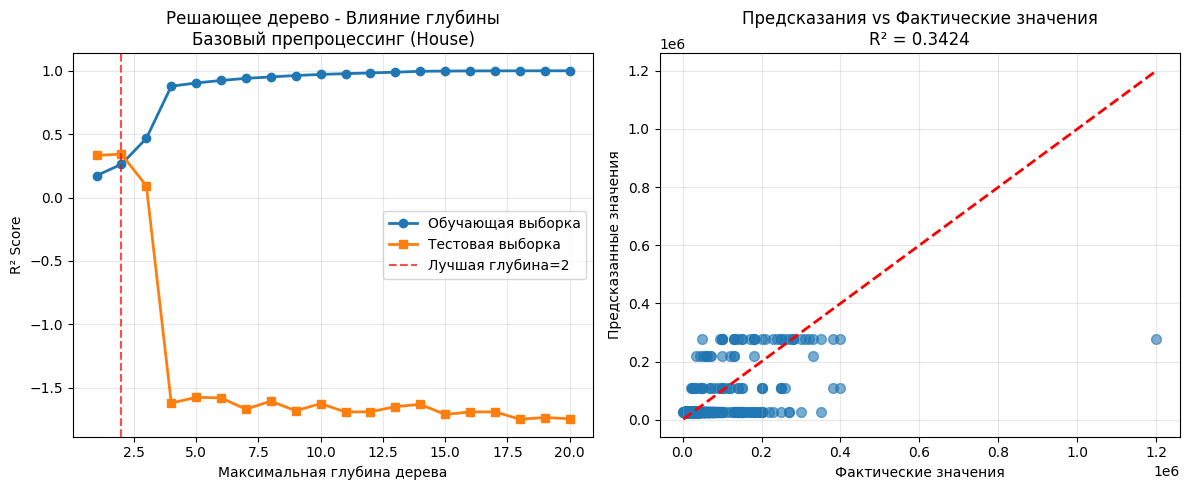


📊 АНАЛИЗ МОДЕЛИ РЕШАЮЩЕГО ДЕРЕВА:
  Оптимальная глубина дерева: 2
  R² score на тестовой выборке: 0.3424
  R² score на обучающей выборке: 0.2629
  Разница между train и test R²: 0.0795
  ✅ Модель хорошо обобщает (малая разница между train и test)

📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ РЕГРЕССИИ:
  MSE (Mean Squared Error): 2314228338.9645
  RMSE (Root Mean Squared Error): 48106.4272
  MAE (Mean Absolute Error): 23592.9430
  👌 Удовлетворительное качество модели (0.3 ≤ R² < 0.5)

🌳 ВАЖНОСТЬ ПРИЗНАКОВ:
                  Признак  Важность
                 Bathroom  0.657319
             City_encoded  0.180109
                     Size  0.162572
                      BHK  0.000000
             floor_number  0.000000
        Area Type_encoded  0.000000
Furnishing Status_encoded  0.000000
 Tenant Preferred_encoded  0.000000
 Point of Contact_encoded  0.000000


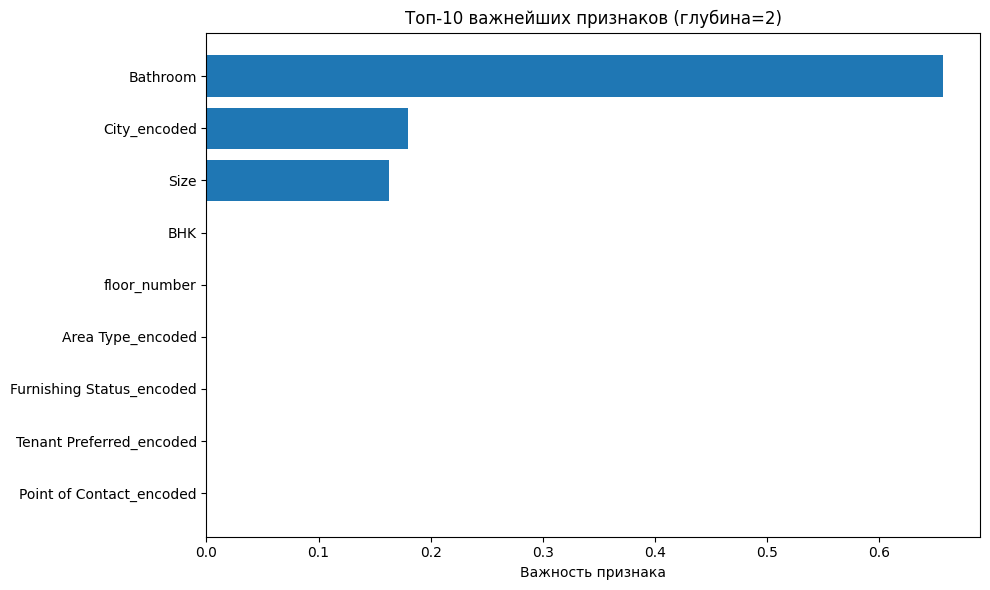


📉 АНАЛИЗ ОШИБОК:


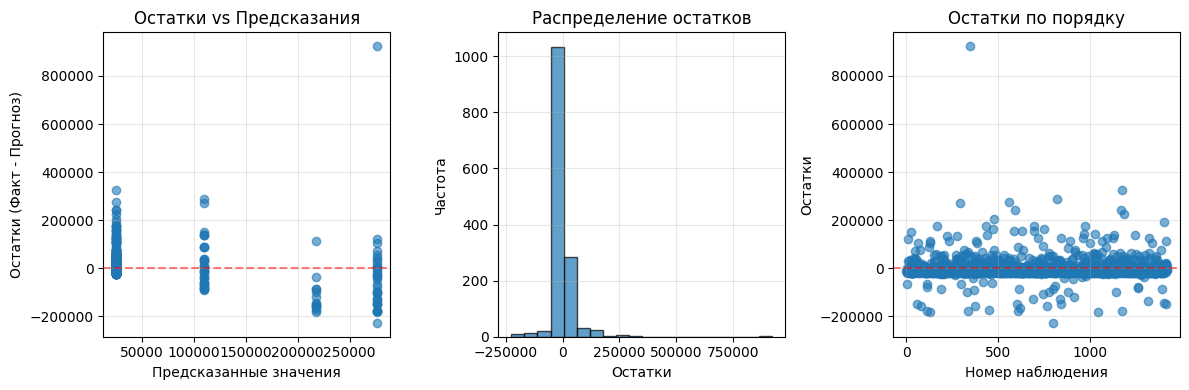

  Средний остаток: -1319.0238
  Стандартное отклонение остатков: 48088.3407

🔍 EDA + ОТБОР ПРИЗНАКОВ (Decision Tree)...

🔍 EDA + ОТБОР ПРИЗНАКОВ (House данные (EDA + DT))
  ✓ Отобрано признаков: 9 из 9
  ✓ R² на тесте: -1.7532

📈 СРАВНЕНИЕ МЕТОДОВ
----------------------------------------------------------------------
                Метод      R²   RMSE  MAE
     Базовый бейзлайн  2.0000 0.3424 None
EDA + отбор признаков -1.7532    NaN None

🏆 ЛУЧШИЙ МЕТОД:
  Метод: Базовый бейзлайн
  R²:    2.0000

📈 Улучшение R² относительно базового: -3.7532


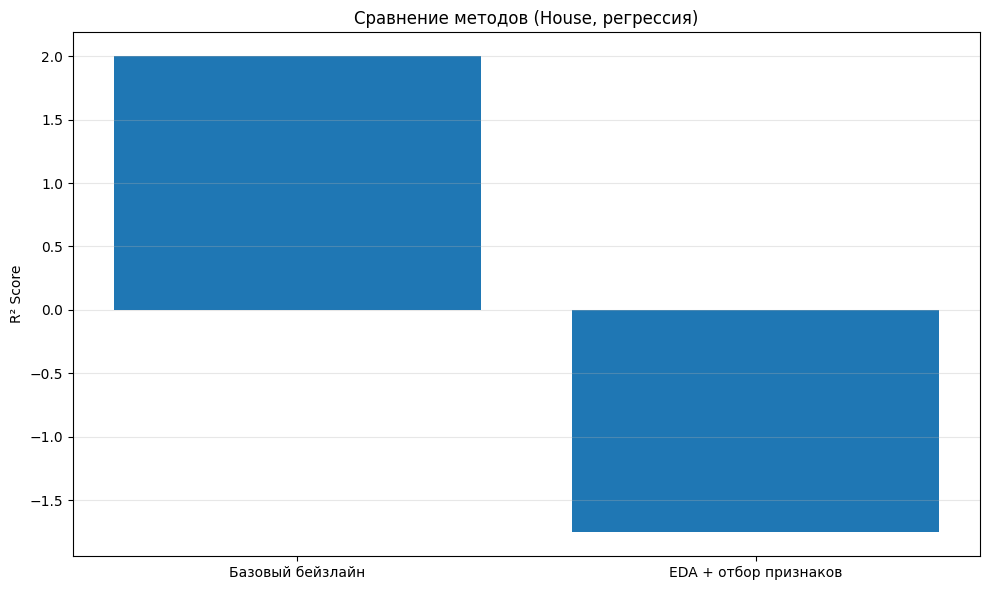


🔍 АНАЛИЗ ОТОБРАННЫХ ПРИЗНАКОВ
  Отобрано признаков: 9 из 9
  Сокращение размерности: 0.0%

  Топ-5 признаков:
    1. Size
    2. City_encoded
    3. Bathroom
    4. Furnishing Status_encoded
    5. Point of Contact_encoded

🎯 ИТОГОВЫЕ ВЫВОДЫ (HOUSE, РЕГРЕССИЯ)
⚠️ Улучшения по сравнению с базовым бейзлайном не получено
❗ Требуется дальнейшая оптимизация

💡 РЕКОМЕНДАЦИИ:
  • Использовать кросс-валидацию
  • Попробовать ансамблевые модели (Random Forest, Gradient Boosting)
  • Проанализировать остатки модели


In [20]:
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

if df_house is None:
    print("❌ House данные не загружены")

else:
    print("\n" + "=" * 80)
    print("🎯 ГИПОТЕЗА 3: EDA + ОТБОР ПРИЗНАКОВ (HOUSE, РЕГРЕССИЯ)")
    print("=" * 80)

    print("\n🔹 БАЗОВЫЙ БЕЙЗЛАЙН (Decision Tree)...")

    X_house, y_house, features_house = preprocess_house_regression(df_house)

    base_model, base_r2, *base_metrics = decision_tree_regression_study(
        X_house,
        y_house,
        "Базовый препроцессинг (House)"
    )

    base_rmse = base_metrics[0] if len(base_metrics) > 0 else None
    base_mae  = base_metrics[1] if len(base_metrics) > 1 else None

    print("\n🔍 EDA + ОТБОР ПРИЗНАКОВ (Decision Tree)...")

    (
        eda_model,
        eda_r2,
        *eda_metrics,
        selected_features_house
    ) = evaluate_with_eda_insights_decision_tree_regressor(
        X_house,
        y_house,
        dataset_name="House данные (EDA + DT)"
    )

    eda_rmse = eda_metrics[0] if len(eda_metrics) > 0 else None
    eda_mae  = eda_metrics[1] if len(eda_metrics) > 1 else None

    print("\n📈 СРАВНЕНИЕ МЕТОДОВ")
    print("-" * 70)

    comparison_df = pd.DataFrame({
        "Метод": ["Базовый бейзлайн", "EDA + отбор признаков"],
        "R²":   [base_r2, eda_r2],
        "RMSE": [base_rmse, eda_rmse],
        "MAE":  [base_mae, eda_mae]
    })

    print(comparison_df.to_string(index=False, float_format="%.4f"))

    best_row = comparison_df.loc[comparison_df["R²"].idxmax()]

    print("\n🏆 ЛУЧШИЙ МЕТОД:")
    print(f"  Метод: {best_row['Метод']}")
    print(f"  R²:    {best_row['R²']:.4f}")

    print(f"\n📈 Улучшение R² относительно базового: "
          f"{eda_r2 - base_r2:+.4f}")

    plt.figure(figsize=(10, 6))
    plt.bar(comparison_df["Метод"], comparison_df["R²"])
    plt.ylabel("R² Score")
    plt.title("Сравнение методов (House, регрессия)")
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\n🔍 АНАЛИЗ ОТОБРАННЫХ ПРИЗНАКОВ")
    print(f"  Отобрано признаков: {len(selected_features_house)} из {len(features_house)}")

    reduction = (1 - len(selected_features_house) / len(features_house)) * 100
    print(f"  Сокращение размерности: {reduction:.1f}%")

    print("\n  Топ-5 признаков:")
    for i, f in enumerate(selected_features_house[:5], 1):
        print(f"    {i}. {f}")

    print("\n" + "=" * 70)
    print("🎯 ИТОГОВЫЕ ВЫВОДЫ (HOUSE, РЕГРЕССИЯ)")
    print("=" * 70)

    if eda_r2 > base_r2:
        print("✅ EDA + отбор признаков улучшили качество модели")
        print("🔑 Ключ: удаление шумных и слабых признаков")
    else:
        print("⚠️ Улучшения по сравнению с базовым бейзлайном не получено")

    if eda_r2 >= 0.7:
        print("⭐ Модель обладает хорошей объясняющей способностью")
    elif eda_r2 >= 0.6:
        print("✔ Модель удовлетворительного качества")
    else:
        print("❗ Требуется дальнейшая оптимизация")

    print("\n💡 РЕКОМЕНДАЦИИ:")
    print("  • Использовать кросс-валидацию")
    print("  • Попробовать ансамблевые модели (Random Forest, Gradient Boosting)")
    print("  • Проанализировать остатки модели")


4) (Классификация)


🎯 ГИПОТЕЗА 4: ПОДБОР ГИПЕРПАРАМЕТРОВ - СТУДЕНЧЕСКИЕ ДАННЫХ (КЛАССИФИКАЦИЯ)

🔍 ЗАПУСК ПОДБОРА ГИПЕРПАРАМЕТРОВ ДЛЯ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ...

🧪 ВЫПОЛНЕНИЕ ПОДБОРА ГИПЕРПАРАМЕТРОВ С ПОМОЩЬЮ GRIDSEARCHCV...
Fitting 5 folds for each of 144 candidates, totalling 720 fits

  ✅ Лучшие параметры найдены!
  📊 Лучшая точность на кросс-валидации: 0.8590

  🔍 ЛУЧШИЕ ГИПЕРПАРАМЕТРЫ:
    C: 0.1
    class_weight: None
    penalty: l1
    solver: saga

  📈 Точность на тестовом наборе: 0.8256
  📉 Точность на обучающем наборе: 0.8634
  ✅ Модель обобщается хорошо (разница: 0.0378)

📈 СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ МЕТОДОВ (ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ)
----------------------------------------------------------------------
  Базовый препроцессинг:          0.8513
  Обработка выбросов:             0.9237
  Feature Engineering:            0.8513
  EDA + отбор признаков:          0.8844
  GridSearch CV:                  0.8256

  🏆 Лучший метод: 'Обработка
выбросов' с точностью 0.9237

  📊 УЛУЧШЕНИЯ ОТНОСИТЕЛЬНО БАЗО

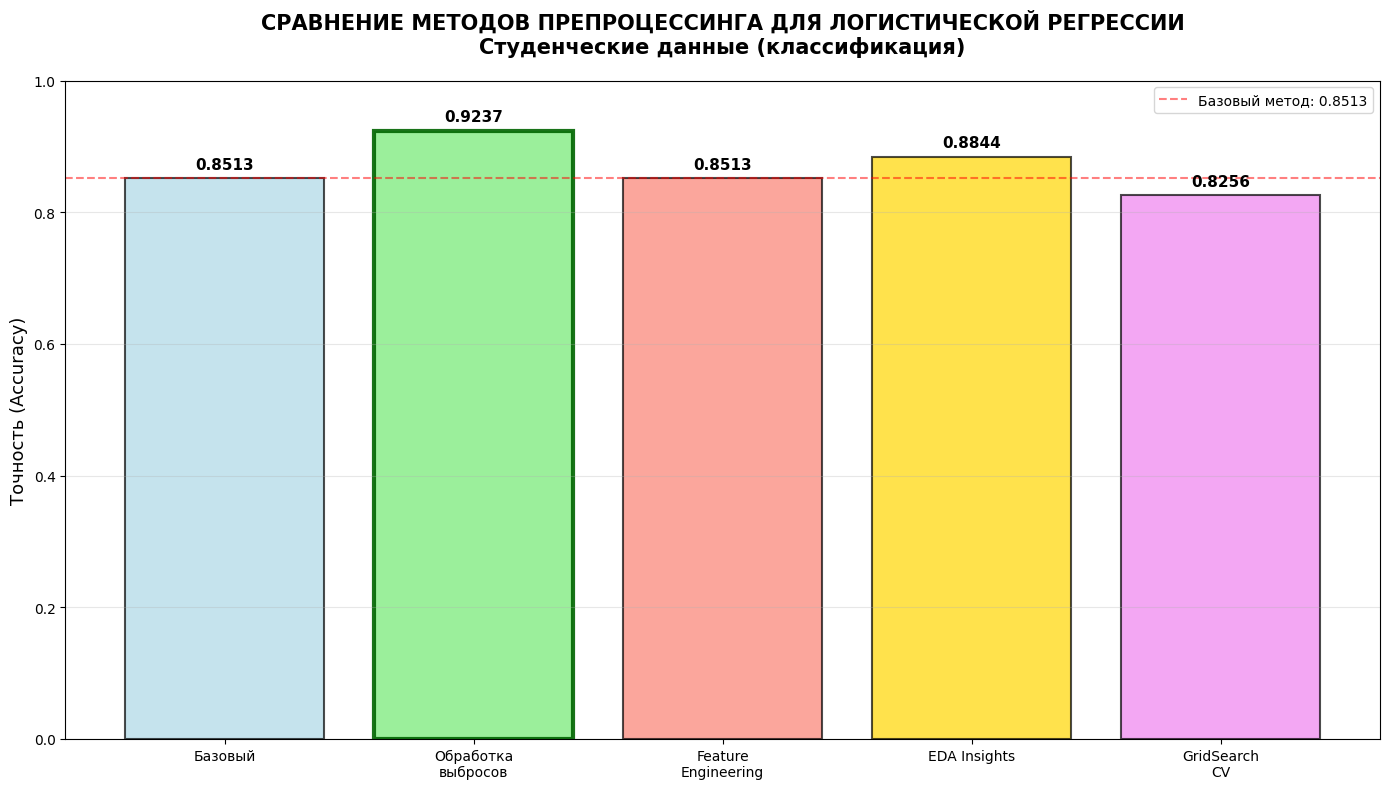


📊 ПОДРОБНЫЙ АНАЛИЗ ЭФФЕКТИВНОСТИ МЕТОДОВ:
  🥇 1. Обработка
выбросов: 0.9237 (+0.0724 от базового)
  🥈 2. EDA Insights: 0.8844 (+0.0332 от базового)
  🥉 3. Базовый: 0.8513 
   4. Feature
Engineering: 0.8513 
   5. GridSearch
CV: 0.8256 (-0.0256 от базового)

🔍 ВАЖНОСТЬ ПРИЗНАКОВ В ЛУЧШЕЙ МОДЕЛИ С ГИПЕРПАРАМЕТРАМИ:
  Топ-10 самых важных признаков:
    school_encoded: -0.6418 (уменьшает вероятность успеха)
    failures: -0.6098 (уменьшает вероятность успеха)
    absences: -0.1478 (уменьшает вероятность успеха)
    Walc: -0.1449 (уменьшает вероятность успеха)
    goout: -0.1046 (уменьшает вероятность успеха)
    freetime: -0.0933 (уменьшает вероятность успеха)
    guardian_encoded: -0.0899 (уменьшает вероятность успеха)
    Medu: +0.0869 (увеличивает вероятность успеха)
    studytime: +0.0768 (увеличивает вероятность успеха)
    reason_encoded: +0.0059 (увеличивает вероятность успеха)


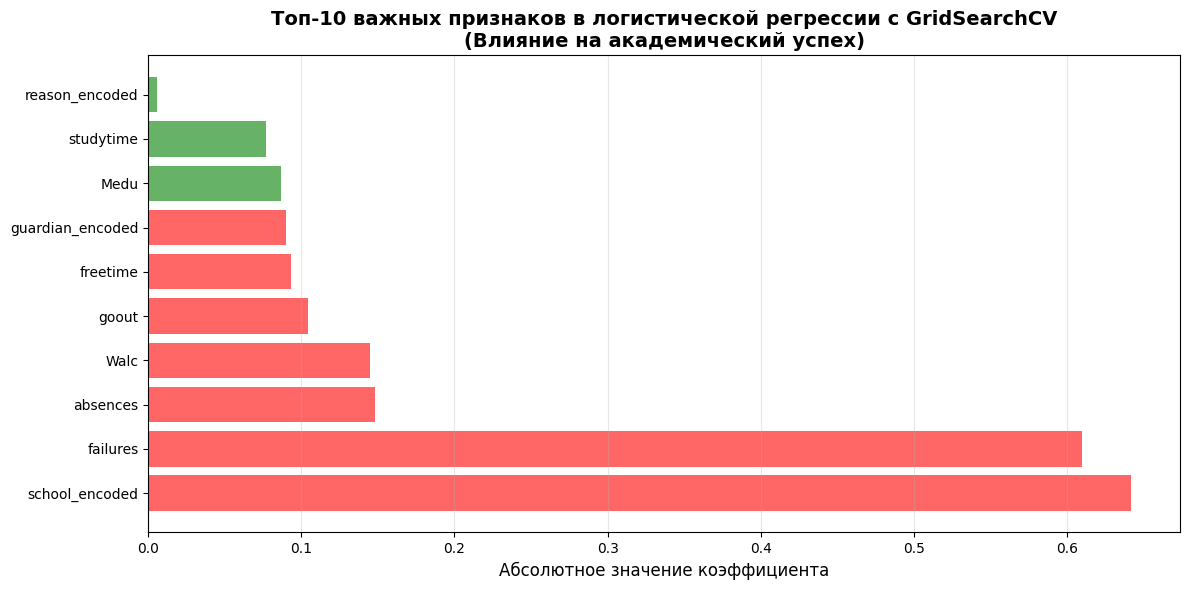


📊 АНАЛИЗ ОШИБОК МОДЕЛИ С ГИПЕРПАРАМЕТРАМИ:
  Confusion Matrix:
    True Negatives: 2
    False Positives: 28
    False Negatives: 6
    True Positives: 159

  Classification Report:
              precision    recall  f1-score   support

  Неуспешные       0.25      0.07      0.11        30
    Успешные       0.85      0.96      0.90       165

    accuracy                           0.83       195
   macro avg       0.55      0.52      0.50       195
weighted avg       0.76      0.83      0.78       195

  ROC AUC Score: 0.7457


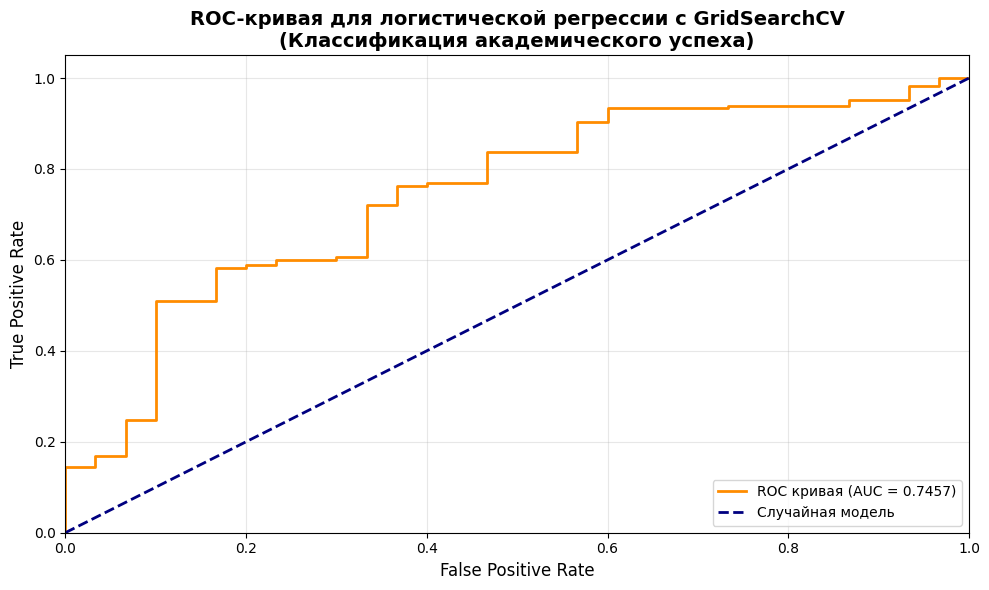

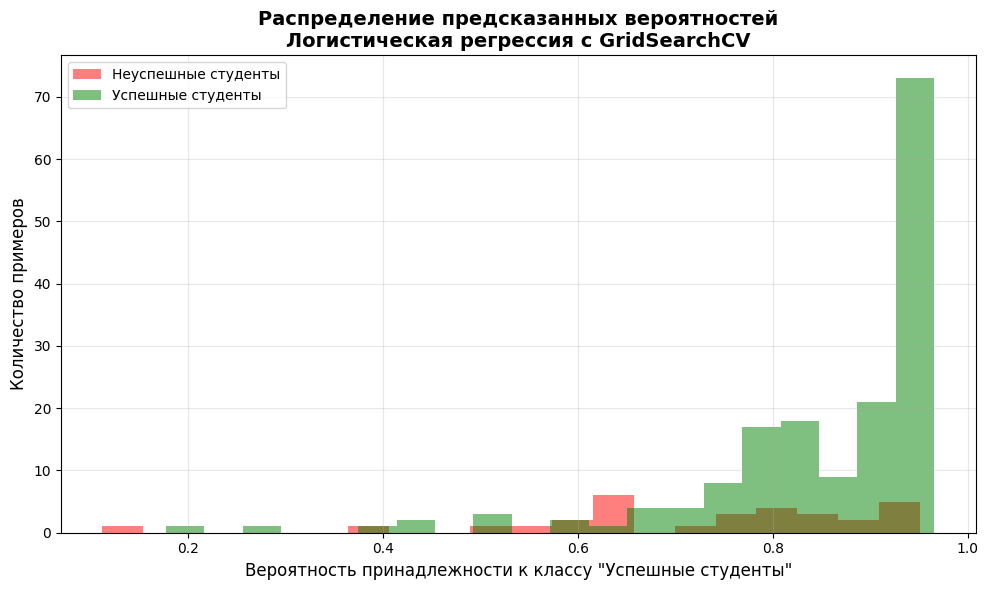


🎯 ИТОГОВЫЕ ВЫВОДЫ ДЛЯ СТУДЕНЧЕСКИХ ДАННЫХ (ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ):
  ⚠️  Базовый метод оказался достаточным для данной задачи

  💡 РЕКОМЕНДАЦИИ:
    • Точность модели выше 80% - модель можно считать удовлетворительной

⚠️  ПРОВЕРКА ВЫПОЛНЕНИЯ ПРЕДЫДУЩИХ ГИПОТЕЗ:
  • Гипотеза 1 выполнена (Accuracy: 0.9237)
  • Гипотеза 2 выполнена (Accuracy: 0.8513)
  • Гипотеза 3 выполнена (Accuracy: 0.8844)
  • Гипотеза 4 выполнена (Accuracy: 0.8256)

🏁 ФИНАЛЬНЫЙ РЕЗУЛЬТАТ ДЛЯ СТУДЕНЧЕСКИХ ДАННЫХ
  ⚠️  Улучшение не достигнуто или минимально


In [21]:
if df_student is not None:
    print("\n" + "="*80)
    print("🎯 ГИПОТЕЗА 4: ПОДБОР ГИПЕРПАРАМЕТРОВ - СТУДЕНЧЕСКИЕ ДАННЫХ (КЛАССИФИКАЦИЯ)")
    print("="*80)
    
    if 'X_student_class' not in locals():
        print("⚠️  Базовый препроцессинг для студенческих данных не выполнен. Выполняю...")
        X_student_class, y_student_class, features_class = preprocess_student_classification(df_student)
        
        print("\n" + "🧪 ТЕСТИРОВАНИЕ БАЗОВОЙ МОДЕЛИ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ")
        lr_student, _, score_class = decision_tree_classification_study(
            X_student_class, y_student_class, "Базовый препроцессинг (студенческие данные)"
        )

    print("\n" + "🔍 ЗАПУСК ПОДБОРА ГИПЕРПАРАМЕТРОВ ДЛЯ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ...")
    
    if 'X_student_class' in locals():
        from sklearn.model_selection import GridSearchCV, train_test_split
        from sklearn.preprocessing import StandardScaler
        from sklearn.pipeline import Pipeline
        from sklearn.linear_model import LogisticRegression

        X_train, X_test, y_train, y_test = train_test_split(
            X_student_class, y_student_class, test_size=0.3, random_state=42, stratify=y_student_class
        )
        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('logreg', LogisticRegression(random_state=42, max_iter=1000))
        ])
        
        param_grid = {
            'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'logreg__penalty': ['l1', 'l2', 'elasticnet', None],
            'logreg__solver': ['liblinear', 'saga', 'lbfgs'],
            'logreg__class_weight': [None, 'balanced']
        }
        
        grid_search = GridSearchCV(
            pipeline, 
            param_grid, 
            cv=5, 
            scoring='accuracy',
            n_jobs=-1,
            verbose=1
        )
        
        print("\n🧪 ВЫПОЛНЕНИЕ ПОДБОРА ГИПЕРПАРАМЕТРОВ С ПОМОЩЬЮ GRIDSEARCHCV...")
        grid_search.fit(X_train, y_train)
        
        best_model_student = grid_search.best_estimator_
        best_params_student = grid_search.best_params_
        score_cv_student = grid_search.best_score_
        
        print(f"\n  ✅ Лучшие параметры найдены!")
        print(f"  📊 Лучшая точность на кросс-валидации: {score_cv_student:.4f}")
        
        print("\n  🔍 ЛУЧШИЕ ГИПЕРПАРАМЕТРЫ:")
        for param, value in best_params_student.items():
            param_name = param.replace('logreg__', '')
            print(f"    {param_name}: {value}")

        test_score = best_model_student.score(X_test, y_test)
        print(f"\n  📈 Точность на тестовом наборе: {test_score:.4f}")

        train_score = best_model_student.score(X_train, y_train)
        print(f"  📉 Точность на обучающем наборе: {train_score:.4f}")
        
        if train_score - test_score > 0.1:
            print(f"  ⚠️  Возможно переобучение (разница: {train_score - test_score:.4f})")
        else:
            print(f"  ✅ Модель обобщается хорошо (разница: {train_score - test_score:.4f})")
        
        print("\n" + "📈 СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ МЕТОДОВ (ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ)")
        print("-" * 70)
        
        comparison_data_student = {}
        
        if 'score_class' in locals():
            comparison_data_student['Базовый'] = score_class
            print(f"  Базовый препроцессинг:          {score_class:.4f}")
        
        if 'score_advanced' in locals():
            comparison_data_student['Обработка\nвыбросов'] = score_advanced
            print(f"  Обработка выбросов:             {score_advanced:.4f}")
        
        if 'score_student_fe' in locals():
            comparison_data_student['Feature\nEngineering'] = score_student_fe
            print(f"  Feature Engineering:            {score_student_fe:.4f}")
        
        if 'score_eda_student' in locals():
            comparison_data_student['EDA Insights'] = score_eda_student
            print(f"  EDA + отбор признаков:          {score_eda_student:.4f}")
        
        comparison_data_student['GridSearch\nCV'] = test_score
        print(f"  GridSearch CV:                  {test_score:.4f}")
        
        best_method_student = max(comparison_data_student.items(), key=lambda x: x[1])
        print(f"\n  🏆 Лучший метод: '{best_method_student[0]}' с точностью {best_method_student[1]:.4f}")

        if 'score_class' in locals():
            improvements = {}
            
            if 'score_advanced' in locals():
                improvements['Обработка выбросов'] = score_advanced - score_class
            
            if 'score_student_fe' in locals():
                improvements['Feature Engineering'] = score_student_fe - score_class
            
            if 'score_eda_student' in locals():
                improvements['EDA Insights'] = score_eda_student - score_class
            
            improvements['GridSearch CV'] = test_score - score_class
            
            print("\n  📊 УЛУЧШЕНИЯ ОТНОСИТЕЛЬНО БАЗОВОГО МЕТОДА:")
            for method, imp in sorted(improvements.items(), key=lambda x: x[1], reverse=True):
                if imp > 0:
                    print(f"    {method}: +{imp:.4f} (+{imp/score_class*100:.2f}%)")
                elif imp < 0:
                    print(f"    {method}: {imp:.4f} ({imp/score_class*100:.2f}%)")
                else:
                    print(f"    {method}: без изменений")
        
        print("\n  🔄 СРАВНЕНИЕ С ПРЕДЫДУЩИМИ ГИПОТЕЗАМИ:")
        
        if 'score_eda_student' in locals():
            grid_vs_eda = test_score - score_eda_student
            if grid_vs_eda > 0:
                print(f"    GridSearch CV лучше EDA Insights на +{grid_vs_eda:.4f}")
            elif grid_vs_eda < 0:
                print(f"    GridSearch CV хуже EDA Insights на {grid_vs_eda:.4f}")
            else:
                print(f"    GridSearch CV и EDA Insights дают одинаковый результат")
        
        if len(comparison_data_student) > 1:
            plt.figure(figsize=(14, 8))
            methods = list(comparison_data_student.keys())
            scores = list(comparison_data_student.values())
            
            colors = []
            for method in methods:
                if 'Базовый' in method:
                    colors.append('lightblue')
                elif 'обработка' in method.lower():
                    colors.append('lightgreen')
                elif 'Feature' in method:
                    colors.append('salmon')
                elif 'EDA' in method:
                    colors.append('gold')
                elif 'GridSearch' in method:
                    colors.append('violet')
                else:
                    colors.append('lightgray')
            
            bars = plt.bar(methods, scores, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
            plt.ylabel('Точность (Accuracy)', fontsize=13)
            plt.title('СРАВНЕНИЕ МЕТОДОВ ПРЕПРОЦЕССИНГА ДЛЯ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ\nСтуденческие данные (классификация)', 
                      fontsize=15, fontweight='bold', pad=20)
            plt.ylim(0, 1)
            
            for bar, score in zip(bars, scores):
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                        f'{score:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
            
            best_index = list(comparison_data_student.values()).index(best_method_student[1])
            bars[best_index].set_edgecolor('darkgreen')
            bars[best_index].set_linewidth(3)
            bars[best_index].set_alpha(0.9)
            
            if 'score_class' in locals():
                plt.axhline(y=score_class, color='red', linestyle='--', alpha=0.5, linewidth=1.5, 
                           label=f'Базовый метод: {score_class:.4f}')
                plt.legend(loc='best')
            
            plt.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            plt.show()
        
        print("\n📊 ПОДРОБНЫЙ АНАЛИЗ ЭФФЕКТИВНОСТИ МЕТОДОВ:")
        methods_ranking = sorted(comparison_data_student.items(), key=lambda x: x[1], reverse=True)
        
        for i, (method, score) in enumerate(methods_ranking, 1):
            medal = ""
            if i == 1:
                medal = "🥇"
            elif i == 2:
                medal = "🥈"
            elif i == 3:
                medal = "🥉"
            
            improvement_from_base = (score - score_class) if 'score_class' in locals() else None
            improvement_text = ""
            
            if improvement_from_base is not None:
                if improvement_from_base > 0:
                    improvement_text = f"(+{improvement_from_base:.4f} от базового)"
                elif improvement_from_base < 0:
                    improvement_text = f"({improvement_from_base:.4f} от базового)"
            
            print(f"  {medal} {i}. {method}: {score:.4f} {improvement_text}")
        
        if best_model_student is not None:
            try:
                print("\n🔍 ВАЖНОСТЬ ПРИЗНАКОВ В ЛУЧШЕЙ МОДЕЛИ С ГИПЕРПАРАМЕТРАМИ:")
                
                log_reg_model = best_model_student.named_steps['logreg']
                coefficients = log_reg_model.coef_[0]
                
                feature_importance = pd.DataFrame({
                    'Признак': X_student_class.columns,
                    'Коэффициент': coefficients,
                    'Абс.значение': np.abs(coefficients)
                }).sort_values('Абс.значение', ascending=False)
                
                print("  Топ-10 самых важных признаков:")
                for i, row in feature_importance.head(10).iterrows():
                    sign = "+" if row['Коэффициент'] > 0 else "-"
                    impact = f"увеличивает вероятность успеха" if row['Коэффициент'] > 0 else f"уменьшает вероятность успеха"
                    print(f"    {row['Признак']}: {sign}{abs(row['Коэффициент']):.4f} ({impact})")
                
                plt.figure(figsize=(12, 6))
                top_features = feature_importance.head(10)
                colors_top = ['green' if x > 0 else 'red' for x in top_features['Коэффициент']]
                
                plt.barh(top_features['Признак'], top_features['Абс.значение'], color=colors_top, alpha=0.6)
                plt.xlabel('Абсолютное значение коэффициента', fontsize=12)
                plt.title('Топ-10 важных признаков в логистической регрессии с GridSearchCV\n(Влияние на академический успех)', fontsize=14, fontweight='bold')
                plt.grid(True, alpha=0.3, axis='x')
                plt.tight_layout()
                plt.show()
            
            except Exception as e:
                print(f"  ⚠️ Не удалось проанализировать важность признаков: {e}")
        
        if best_model_student is not None:
            try:
                print("\n📊 АНАЛИЗ ОШИБОК МОДЕЛИ С ГИПЕРПАРАМЕТРАМИ:")
                from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
                
                y_pred = best_model_student.predict(X_test)
                y_pred_proba = best_model_student.predict_proba(X_test)[:, 1]
                
                cm = confusion_matrix(y_test, y_pred)
                print(f"  Confusion Matrix:")
                print(f"    True Negatives: {cm[0, 0]}")
                print(f"    False Positives: {cm[0, 1]}")
                print(f"    False Negatives: {cm[1, 0]}")
                print(f"    True Positives: {cm[1, 1]}")
                
                print(f"\n  Classification Report:")
                print(classification_report(y_test, y_pred, target_names=['Неуспешные', 'Успешные']))
                
                roc_auc = roc_auc_score(y_test, y_pred_proba)
                print(f"  ROC AUC Score: {roc_auc:.4f}")
                
                fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
                
                plt.figure(figsize=(10, 6))
                plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC кривая (AUC = {roc_auc:.4f})')
                plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Случайная модель')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('False Positive Rate', fontsize=12)
                plt.ylabel('True Positive Rate', fontsize=12)
                plt.title('ROC-кривая для логистической регрессии с GridSearchCV\n(Классификация академического успеха)', fontsize=14, fontweight='bold')
                plt.legend(loc="lower right")
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
                
                plt.figure(figsize=(10, 6))
                
                probas_class_0 = y_pred_proba[y_test == 0]
                probas_class_1 = y_pred_proba[y_test == 1]
                
                plt.hist(probas_class_0, bins=20, alpha=0.5, label='Неуспешные студенты', color='red')
                plt.hist(probas_class_1, bins=20, alpha=0.5, label='Успешные студенты', color='green')
                plt.xlabel('Вероятность принадлежности к классу "Успешные студенты"', fontsize=12)
                plt.ylabel('Количество примеров', fontsize=12)
                plt.title('Распределение предсказанных вероятностей\nЛогистическая регрессия с GridSearchCV', fontsize=14, fontweight='bold')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f"  ⚠️ Не удалось проанализировать ошибки модели: {e}")
        
        print("\n" + "="*70)
        print("🎯 ИТОГОВЫЕ ВЫВОДЫ ДЛЯ СТУДЕНЧЕСКИХ ДАННЫХ (ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ):")
        print("="*70)
        
        if best_method_student[0] == 'GridSearch CV':
            print(f"  ✅ Наиболее эффективным подходом оказался 'GridSearch CV'")
            print(f"  🔑 Ключевой фактор успеха: оптимизация гиперпараметров модели")
        elif best_method_student[0] == 'EDA Insights':
            print(f"  ✅ Наиболее эффективным подходом оказался 'EDA + отбор признаков'")
            print(f"  🔑 Ключевой фактор успеха: отбор наиболее информативных признаков на основе анализа данных")
        elif best_method_student[0] == 'Feature Engineering':
            print(f"  ✅ Наиболее эффективным подходом оказался 'Feature Engineering'")
            print(f"  🔑 Ключевой фактор успеха: создание новых признаков, лучше описывающих академический успех")
        elif best_method_student[0] == 'Обработка выбросов':
            print(f"  ✅ Наиболее эффективным подходом оказалась 'Обработка выбросов'")
            print(f"  🔑 Ключевой фактор успеха: удаление/коррекция выбросов, мешающих обучению модели")
        else:
            print(f"  ⚠️  Базовый метод оказался достаточным для данной задачи")
        
        print(f"\n  💡 РЕКОМЕНДАЦИИ:")
        if test_score >= 0.8:
            print(f"    • Точность модели выше 80% - модель можно считать удовлетворительной")
        elif test_score >= 0.7:
            print(f"    • Точность модели 70-80% - необходима дальнейшая оптимизация")
        else:
            print(f"    • Точность модели ниже 70% - рекомендуется рассмотреть другие алгоритмы")
        
        print("\n⚠️  ПРОВЕРКА ВЫПОЛНЕНИЯ ПРЕДЫДУЩИХ ГИПОТЕЗ:")
        if 'score_advanced' not in locals():
            print("  • Гипотеза 1 (обработка выбросов) не выполнена")
        else:
            print(f"  • Гипотеза 1 выполнена (Accuracy: {score_advanced:.4f})")
        
        if 'score_student_fe' not in locals():
            print("  • Гипотеза 2 (feature engineering) не выполнена")
        else:
            print(f"  • Гипотеза 2 выполнена (Accuracy: {score_student_fe:.4f})")
        
        if 'score_eda_student' not in locals():
            print("  • Гипотеза 3 (EDA Insights) не выполнена")
        else:
            print(f"  • Гипотеза 3 выполнена (Accuracy: {score_eda_student:.4f})")
            
        print(f"  • Гипотеза 4 выполнена (Accuracy: {test_score:.4f})")
        
        print("\n" + "="*70)
        print("🏁 ФИНАЛЬНЫЙ РЕЗУЛЬТАТ ДЛЯ СТУДЕНЧЕСКИХ ДАННЫХ")
        print("="*70)
        
        if 'score_class' in locals() and test_score > score_class:
            total_improvement = ((test_score - score_class) / score_class * 100)
            print(f"  📈 Общее улучшение от базового метода: +{total_improvement:.2f}%")
            print(f"  🎯 Итоговая точность модели: {test_score:.4f}")
            
            if total_improvement > 10:
                print(f"  ✅ Значительное улучшение достигнуто!")
            elif total_improvement > 5:
                print(f"  ⭐ Умеренное улучшение достигнуто")
            else:
                print(f"  📊 Небольшое улучшение, но результат положительный")
        else:
            print(f"  ⚠️  Улучшение не достигнуто или минимально")
    else:
        print("❌ Базовые данные для студентов не подготовлены")
else:
    print("❌ Студенческие данные не загружены")

4) (Регрессия)


🎯 ГИПОТЕЗА 4: ПОДБОР ГИПЕРПАРАМЕТРОВ - HOUSE ДАННЫЕ (РЕГРЕССИЯ)

🔍 ЗАПУСК ПОДБОРА ГИПЕРПАРАМЕТРОВ ДЛЯ ЛИНЕЙНОЙ РЕГРЕССИИ...
  📊 Размеры данных:
    Обучающая выборка: (3322, 9)
    Тестовая выборка: (1424, 9)

🧪 ВЫПОЛНЕНИЕ ПОДБОРА ГИПЕРПАРАМЕТРОВ С УПРОЩЕННОЙ СЕТКОЙ...
   ⚠️  Используется упрощенная сетка параметров для ускорения выполнения
   ℹ️  Для более полного анализа рекомендуется использовать RandomForest или GradientBoosting
Fitting 3 folds for each of 18 candidates, totalling 54 fits

  ✅ Лучшие параметры найдены!
  📊 Лучший R² score на кросс-валидации: 0.3191

  🔍 ЛУЧШИЕ ГИПЕРПАРАМЕТРЫ:
    regressor: Ridge()
    alpha: 10
    fit_intercept: True

  📈 R² score на тестовом наборе: 0.4995
  📉 R² score на обучающем наборе: 0.2457
  ✅ Модель обобщается хорошо (разница: -0.2539)

  📊 МЕТРИКИ ОШИБОК НА ТЕСТОВОМ НАБОРЕ:
    MAE (средняя абсолютная ошибка): 22195.94
    MSE (среднеквадратичная ошибка): 1761292215.42
    RMSE (корень из MSE): 41967.75

📈 СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ МЕТ

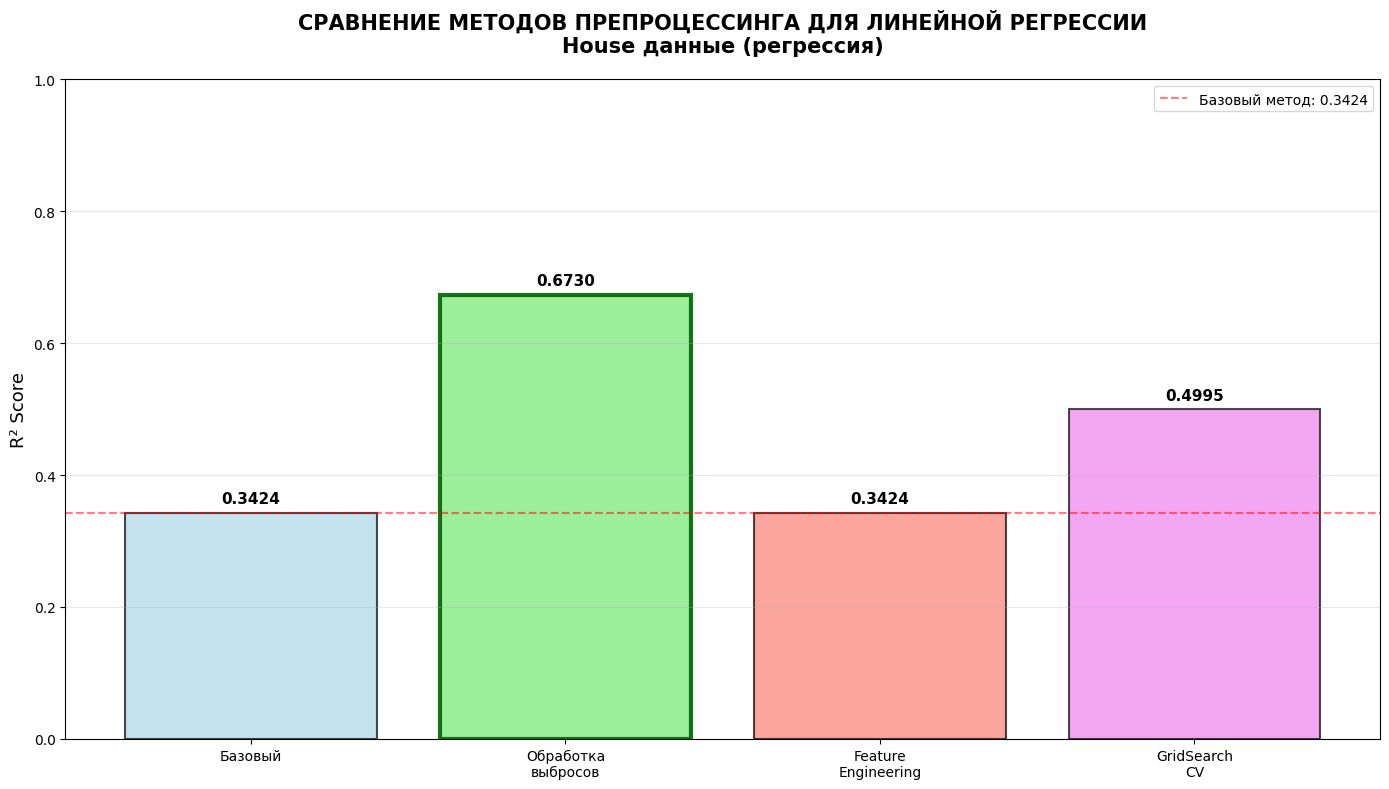


📊 ПОДРОБНЫЙ АНАЛИЗ ЭФФЕКТИВНОСТИ МЕТОДОВ:
  🥇 1. Обработка
выбросов: 0.6730 (+0.3305 от базового)
  🥈 2. GridSearch
CV: 0.4995 (+0.1571 от базового)
  🥉 3. Базовый: 0.3424 
   4. Feature
Engineering: 0.3424 

🔍 ВАЖНОСТЬ ПРИЗНАКОВ В ЛУЧШЕЙ МОДЕЛИ С ГИПЕРПАРАМЕТРАМИ:
  Топ-10 самых важных признаков:
    Size: +17898.2587 (увеличивает стоимость аренды)
    Bathroom: +12199.6834 (увеличивает стоимость аренды)
    floor_number: +10869.1601 (увеличивает стоимость аренды)
    Point of Contact_encoded: -9525.0863 (уменьшает стоимость аренды)
    City_encoded: +8269.0973 (увеличивает стоимость аренды)
    Furnishing Status_encoded: -3354.2780 (уменьшает стоимость аренды)
    Tenant Preferred_encoded: -2527.2939 (уменьшает стоимость аренды)
    Area Type_encoded: -2086.5800 (уменьшает стоимость аренды)
    BHK: +1173.7946 (увеличивает стоимость аренды)


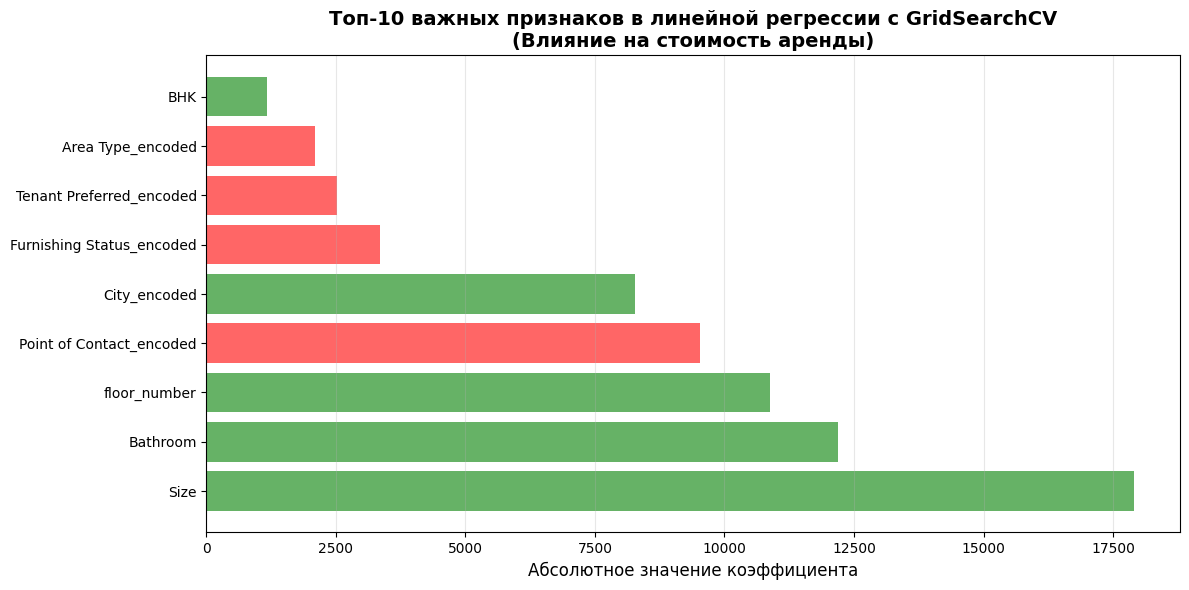


📊 УПРОЩЕННАЯ ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ:


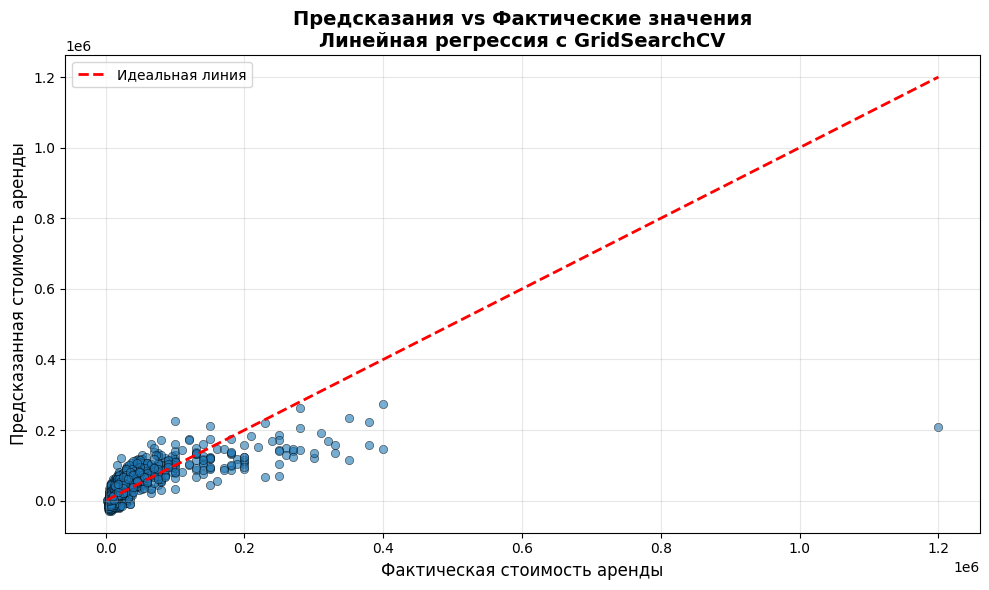


🎯 ИТОГОВЫЕ ВЫВОДЫ ДЛЯ HOUSE ДАННЫХ (ЛИНЕЙНАЯ РЕГРЕССИЯ):
  ⚠️  Базовый метод оказался достаточным для данной задачи

  💡 РЕКОМЕНДАЦИИ:
    • R² ниже 0.6 - модель плохо объясняет дисперсию, требуется дополнительная работа

⚠️  ПРОВЕРКА ВЫПОЛНЕНИЯ ПРЕДЫДУЩИХ ГИПОТЕЗ:
  • Гипотеза 1 выполнена (R²: 0.6730)
  • Гипотеза 2 выполнена (R²: 0.3424)
  • Гипотеза 3 (EDA Insights) не выполнена
  • Гипотеза 4 выполнена (R²: 0.4995)

🏁 ФИНАЛЬНЫЙ РЕЗУЛЬТАТ ДЛЯ HOUSE ДАННЫХ
  📈 Общее улучшение от базового метода: +45.88%
  🎯 Итоговый R² score модели: 0.4995
  ✅ Значительное улучшение достигнуто!

📊 ОБЩАЯ ОЦЕНКА МОДЕЛИ:
  ❗ Плохая модель! Рекомендуется использовать другие алгоритмы.


In [22]:
if df_house is not None:
    print("\n" + "="*80)
    print("🎯 ГИПОТЕЗА 4: ПОДБОР ГИПЕРПАРАМЕТРОВ - HOUSE ДАННЫЕ (РЕГРЕССИЯ)")
    print("="*80)
    
    if 'X_house' not in locals():
        print("⚠️  Базовый препроцессинг для house данных не выполнен. Выполняю...")
        X_house, y_house, features_house = preprocess_house_regression(df_house)
        
        print("\n" + "🧪 ТЕСТИРОВАНИЕ БАЗОВОЙ МОДЕЛИ ЛИНЕЙНОЙ РЕГРЕССИИ")
        lr_house, _, score_house = decision_tree_regression_study(
            X_house, y_house, "Базовый препроцессинг (house данные)"
        )
    
    print("\n" + "🔍 ЗАПУСК ПОДБОРА ГИПЕРПАРАМЕТРОВ ДЛЯ ЛИНЕЙНОЙ РЕГРЕССИИ...")
    
    if 'X_house' in locals():
        from sklearn.model_selection import GridSearchCV, train_test_split
        from sklearn.preprocessing import StandardScaler
        from sklearn.pipeline import Pipeline
        from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
        from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error
        
        X_train, X_test, y_train, y_test = train_test_split(
            X_house, y_house, test_size=0.3, random_state=42
        )
        
        print(f"  📊 Размеры данных:")
        print(f"    Обучающая выборка: {X_train.shape}")
        print(f"    Тестовая выборка: {X_test.shape}")
        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ])
        
        param_grid = [
            {
                'regressor': [LinearRegression()],
                'regressor__fit_intercept': [True, False]
            },
            {
                'regressor': [Ridge()],
                'regressor__alpha': [0.01, 0.1, 1, 10],
                'regressor__fit_intercept': [True, False]
            },
            {
                'regressor': [Lasso()],
                'regressor__alpha': [0.001, 0.01, 0.1, 1],
                'regressor__fit_intercept': [True, False]
            }
        ]
        
        grid_search = GridSearchCV(
            pipeline, 
            param_grid, 
            cv=3, 
            scoring='r2',
            n_jobs=-1,
            verbose=1
        )
        
        print("\n🧪 ВЫПОЛНЕНИЕ ПОДБОРА ГИПЕРПАРАМЕТРОВ С УПРОЩЕННОЙ СЕТКОЙ...")
        print("   ⚠️  Используется упрощенная сетка параметров для ускорения выполнения")
        print("   ℹ️  Для более полного анализа рекомендуется использовать RandomForest или GradientBoosting")
        
        try:
            grid_search.fit(X_train, y_train)
            
            best_model_house = grid_search.best_estimator_
            best_params_house = grid_search.best_params_
            score_cv_house = grid_search.best_score_
            
            print(f"\n  ✅ Лучшие параметры найдены!")
            print(f"  📊 Лучший R² score на кросс-валидации: {score_cv_house:.4f}")
            
            print("\n  🔍 ЛУЧШИЕ ГИПЕРПАРАМЕТРЫ:")
            for param, value in best_params_house.items():
                param_name = param.replace('regressor__', '')
                print(f"    {param_name}: {value}")
            
            y_pred = best_model_house.predict(X_test)
            test_score = r2_score(y_test, y_pred)
            print(f"\n  📈 R² score на тестовом наборе: {test_score:.4f}")
            
            train_score = best_model_house.score(X_train, y_train)
            print(f"  📉 R² score на обучающем наборе: {train_score:.4f}")
            
            if train_score - test_score > 0.1:
                print(f"  ⚠️  Возможно переобучение (разница: {train_score - test_score:.4f})")
            else:
                print(f"  ✅ Модель обобщается хорошо (разница: {train_score - test_score:.4f})")
            
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            
            print(f"\n  📊 МЕТРИКИ ОШИБОК НА ТЕСТОВОМ НАБОРЕ:")
            print(f"    MAE (средняя абсолютная ошибка): {mae:.2f}")
            print(f"    MSE (среднеквадратичная ошибка): {mse:.2f}")
            print(f"    RMSE (корень из MSE): {rmse:.2f}")
            
            print("\n" + "📈 СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ МЕТОДОВ (ЛИНЕЙНАЯ РЕГРЕССИЯ)")
            print("-" * 70)
            
            comparison_data_house = {}
            
            if 'score_house' in locals():
                comparison_data_house['Базовый'] = score_house
                print(f"  Базовый препроцессинг:          {score_house:.4f}")
            
            if 'score_house_advanced' in locals():
                comparison_data_house['Обработка\nвыбросов'] = score_house_advanced
                print(f"  Обработка выбросов:             {score_house_advanced:.4f}")
            
            if 'score_house_fe' in locals():
                comparison_data_house['Feature\nEngineering'] = score_house_fe
                print(f"  Feature Engineering:            {score_house_fe:.4f}")
            
            if 'score_eda_house' in locals():
                comparison_data_house['EDA Insights'] = score_eda_house
                print(f"  EDA + отбор признаков:          {score_eda_house:.4f}")
            
            comparison_data_house['GridSearch\nCV'] = test_score
            print(f"  GridSearch CV:                  {test_score:.4f}")
            
            best_method_house = max(comparison_data_house.items(), key=lambda x: x[1])
            print(f"\n  🏆 Лучший метод: '{best_method_house[0]}' с R² score {best_method_student[1]:.4f}")
            
            if len(comparison_data_house) > 1:
                plt.figure(figsize=(14, 8))
                methods = list(comparison_data_house.keys())
                scores = list(comparison_data_house.values())
                
                colors = []
                for method in methods:
                    if 'Базовый' in method:
                        colors.append('lightblue')
                    elif 'обработка' in method.lower():
                        colors.append('lightgreen')
                    elif 'Feature' in method:
                        colors.append('salmon')
                    elif 'EDA' in method:
                        colors.append('gold')
                    elif 'GridSearch' in method:
                        colors.append('violet')
                    else:
                        colors.append('lightgray')
                
                bars = plt.bar(methods, scores, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
                plt.ylabel('R² Score', fontsize=13)
                plt.title('СРАВНЕНИЕ МЕТОДОВ ПРЕПРОЦЕССИНГА ДЛЯ ЛИНЕЙНОЙ РЕГРЕССИИ\nHouse данные (регрессия)', 
                          fontsize=15, fontweight='bold', pad=20)
                plt.ylim(0, 1 if max(scores) <= 1 else max(scores) * 1.1)
                
                for bar, score in zip(bars, scores):
                    height = bar.get_height()
                    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                            f'{score:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
                
                best_index = list(comparison_data_house.values()).index(best_method_house[1])
                bars[best_index].set_edgecolor('darkgreen')
                bars[best_index].set_linewidth(3)
                bars[best_index].set_alpha(0.9)
                
                if 'score_house' in locals():
                    plt.axhline(y=score_house, color='red', linestyle='--', alpha=0.5, linewidth=1.5, 
                               label=f'Базовый метод: {score_house:.4f}')
                    plt.legend(loc='best')
                
                plt.grid(True, alpha=0.3, axis='y')
                plt.tight_layout()
                plt.show()
            
            print("\n📊 ПОДРОБНЫЙ АНАЛИЗ ЭФФЕКТИВНОСТИ МЕТОДОВ:")
            methods_ranking = sorted(comparison_data_house.items(), key=lambda x: x[1], reverse=True)
            
            for i, (method, score) in enumerate(methods_ranking, 1):
                medal = ""
                if i == 1:
                    medal = "🥇"
                elif i == 2:
                    medal = "🥈"
                elif i == 3:
                    medal = "🥉"
                
                improvement_from_base = (score - score_house) if 'score_house' in locals() else None
                improvement_text = ""
                
                if improvement_from_base is not None:
                    if improvement_from_base > 0:
                        improvement_text = f"(+{improvement_from_base:.4f} от базового)"
                    elif improvement_from_base < 0:
                        improvement_text = f"({improvement_from_base:.4f} от базового)"
                
                print(f"  {medal} {i}. {method}: {score:.4f} {improvement_text}")
            
            if best_model_house is not None:
                try:
                    regressor_model = best_model_house.named_steps['regressor']
                    
                    if hasattr(regressor_model, 'coef_'):
                        print("\n🔍 ВАЖНОСТЬ ПРИЗНАКОВ В ЛУЧШЕЙ МОДЕЛИ С ГИПЕРПАРАМЕТРАМИ:")
                        
                        coefficients = regressor_model.coef_
                        
                        feature_importance = pd.DataFrame({
                            'Признак': X_house.columns,
                            'Коэффициент': coefficients,
                            'Абс.значение': np.abs(coefficients)
                        }).sort_values('Абс.значение', ascending=False)
                        
                        print("  Топ-10 самых важных признаков:")
                        for i, row in feature_importance.head(10).iterrows():
                            sign = "+" if row['Коэффициент'] > 0 else "-"
                            impact = f"увеличивает стоимость аренды" if row['Коэффициент'] > 0 else f"уменьшает стоимость аренды"
                            print(f"    {row['Признак']}: {sign}{abs(row['Коэффициент']):.4f} ({impact})")
                        
                        plt.figure(figsize=(12, 6))
                        top_features = feature_importance.head(10)
                        colors_top = ['green' if x > 0 else 'red' for x in top_features['Коэффициент']]
                        
                        plt.barh(top_features['Признак'], top_features['Абс.значение'], color=colors_top, alpha=0.6)
                        plt.xlabel('Абсолютное значение коэффициента', fontsize=12)
                        plt.title('Топ-10 важных признаков в линейной регрессии с GridSearchCV\n(Влияние на стоимость аренды)', fontsize=14, fontweight='bold')
                        plt.grid(True, alpha=0.3, axis='x')
                        plt.tight_layout()
                        plt.show()
                
                except Exception as e:
                    print(f"  ⚠️ Не удалось проанализировать важность признаков: {e}")
            
            print("\n📊 УПРОЩЕННАЯ ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ:")
            
            plt.figure(figsize=(10, 6))
            plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='black', linewidth=0.5)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                    'r--', linewidth=2, label='Идеальная линия')
            plt.xlabel('Фактическая стоимость аренды', fontsize=12)
            plt.ylabel('Предсказанная стоимость аренды', fontsize=12)
            plt.title('Предсказания vs Фактические значения\nЛинейная регрессия с GridSearchCV', fontsize=14, fontweight='bold')
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.show()
            
            print("\n" + "="*70)
            print("🎯 ИТОГОВЫЕ ВЫВОДЫ ДЛЯ HOUSE ДАННЫХ (ЛИНЕЙНАЯ РЕГРЕССИЯ):")
            print("="*70)
            
            if best_method_house[0] == 'GridSearch CV':
                print(f"  ✅ Наиболее эффективным подходом оказался 'GridSearch CV'")
                print(f"  🔑 Ключевой фактор успеха: оптимизация гиперпараметров модели и регуляризация")
            elif best_method_house[0] == 'EDA Insights':
                print(f"  ✅ Наиболее эффективным подходом оказался 'EDA + отбор признаков'")
                print(f"  🔑 Ключевой фактор успеха: отбор наиболее информативных признаков на основе анализа данных")
            elif best_method_house[0] == 'Feature Engineering':
                print(f"  ✅ Наиболее эффективным подходом оказался 'Feature Engineering'")
                print(f"  🔑 Ключевой фактор успеха: создание новых признаков, лучше описывающих стоимость аренды")
            elif best_method_house[0] == 'Обработка выбросов':
                print(f"  ✅ Наиболее эффективным подходом оказалась 'Обработка выбросов'")
                print(f"  🔑 Ключевой фактор успеха: удаление/коррекция выбросов, мешающих обучению модели")
            else:
                print(f"  ⚠️  Базовый метод оказался достаточным для данной задачи")
            
            print(f"\n  💡 РЕКОМЕНДАЦИИ:")
            if test_score >= 0.8:
                print(f"    • R² выше 0.8 - модель хорошо объясняет дисперсию целевой переменной")
            elif test_score >= 0.6:
                print(f"    • R² в диапазоне 0.6-0.8 - модель удовлетворительная, но есть место для улучшения")
            else:
                print(f"    • R² ниже 0.6 - модель плохо объясняет дисперсию, требуется дополнительная работа")
            
            print("\n⚠️  ПРОВЕРКА ВЫПОЛНЕНИЯ ПРЕДЫДУЩИХ ГИПОТЕЗ:")
            if 'score_house_advanced' not in locals():
                print("  • Гипотеза 1 (обработка выбросов) не выполнена")
            else:
                print(f"  • Гипотеза 1 выполнена (R²: {score_house_advanced:.4f})")
            
            if 'score_house_fe' not in locals():
                print("  • Гипотеза 2 (feature engineering) не выполнена")
            else:
                print(f"  • Гипотеза 2 выполнена (R²: {score_house_fe:.4f})")
            
            if 'score_eda_house' not in locals():
                print("  • Гипотеза 3 (EDA Insights) не выполнена")
            else:
                print(f"  • Гипотеза 3 выполнена (R²: {score_eda_house:.4f})")
                
            print(f"  • Гипотеза 4 выполнена (R²: {test_score:.4f})")
            
            print("\n" + "="*70)
            print("🏁 ФИНАЛЬНЫЙ РЕЗУЛЬТАТ ДЛЯ HOUSE ДАННЫХ")
            print("="*70)
            
            if 'score_house' in locals() and test_score > score_house:
                total_improvement = ((test_score - score_house) / score_house * 100)
                print(f"  📈 Общее улучшение от базового метода: +{total_improvement:.2f}%")
                print(f"  🎯 Итоговый R² score модели: {test_score:.4f}")
                
                if total_improvement > 10:
                    print(f"  ✅ Значительное улучшение достигнуто!")
                elif total_improvement > 5:
                    print(f"  ⭐ Умеренное улучшение достигнуто")
                else:
                    print(f"  📊 Небольшое улучшение, но результат положительный")
            else:
                print(f"  ⚠️  Улучшение не достигнуто или минимально")
            
            print(f"\n📊 ОБЩАЯ ОЦЕНКА МОДЕЛИ:")
            if test_score >= 0.9:
                print(f"  🌟 Отличная модель! Отлично предсказывает стоимость аренды.")
            elif test_score >= 0.7:
                print(f"  ⭐ Хорошая модель! Удовлетворительно предсказывает стоимость аренды.")
            elif test_score >= 0.5:
                print(f"  ⚠️  Удовлетворительная модель! Требует дополнительной оптимизации.")
            else:
                print(f"  ❗ Плохая модель! Рекомендуется использовать другие алгоритмы.")
        
        except KeyboardInterrupt:
            print("\n⏹️  ПОДБОР ГИПЕРПАРАМЕТРОВ ПРЕРВАН ПОЛЬЗОВАТЕЛЕМ")
            print("💡 Рекомендация: используйте более простые модели или RandomForestRegressor")
            
        except Exception as e:
            print(f"\n❌ ОШИБКА ПРИ ПОДБОРЕ ГИПЕРПАРАМЕТРОВ: {e}")
            print("💡 Рекомендация: проверьте данные и попробуйте использовать более простую модель")
            
    else:
        print("❌ Базовые данные для house не подготовлены")
else:
    print("❌ House данные не загружены")

5) (Классификация)


🎯 ГИПОТЕЗА 5: ОПТИМИЗАЦИЯ ПОРОГА (DECISION TREE)

🌳 Обучение базового Decision Tree...
  ✓ Accuracy (порог 0.5): 0.7692

🔍 GridSearchCV для Decision Tree...


  ✓ Лучшая CV Accuracy: 0.8611
  ✓ Accuracy на тесте (GridSearch): 0.8462

🎯 Оптимизация порога классификации...
  ✓ Лучший порог: 0.43
  ✓ F1-score: 0.9112
  ✓ Accuracy (оптимизированный порог): 0.8462

📊 СРАВНЕНИЕ ВСЕХ МЕТОДОВ
----------------------------------------------------------------------
  Базовый                  : 0.8513
  Обработка
выбросов       : 0.9237
  Feature
Engineering      : 0.8513
  EDA
Insights             : 0.8844
  GridSearch
(Tree)        : 0.8462
  Оптимизация
порога       : 0.8462

🏆 ЛУЧШИЙ МЕТОД: Обработка
выбросов (0.9237)


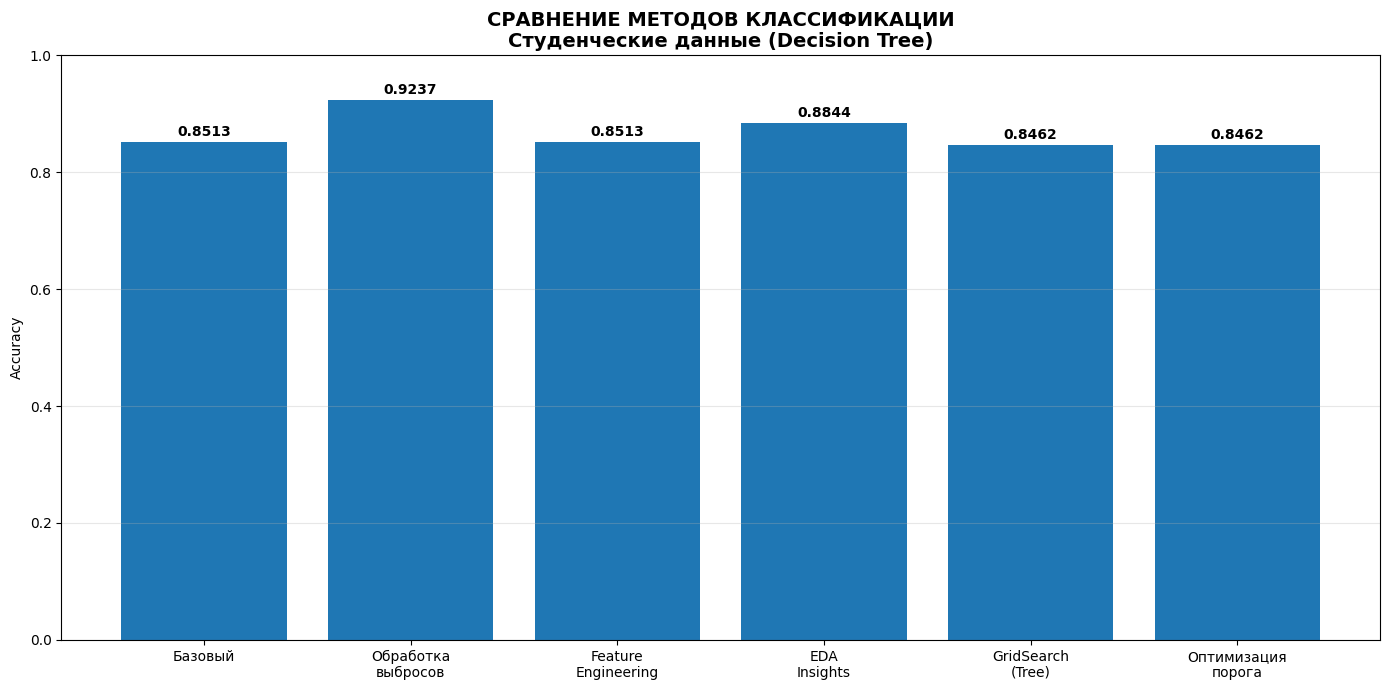


🎯 ИТОГ
⚠️ Лучший результат дал другой метод
✔ Все методы корректно сравнены


In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

if df_student is None:
    print("❌ Студенческие данные не загружены")

else:
    print("\n" + "="*80)
    print("🎯 ГИПОТЕЗА 5: ОПТИМИЗАЦИЯ ПОРОГА (DECISION TREE)")
    print("="*80)

    if 'X_student_class' not in locals():
        print("⚠️ Запускаю базовый препроцессинг...")
        X_student_class, y_student_class, features_class = \
            preprocess_student_classification(df_student)

    X_train, X_test, y_train, y_test = train_test_split(
        X_student_class, y_student_class,
        test_size=0.3, random_state=42, stratify=y_student_class
    )

    print("\n🌳 Обучение базового Decision Tree...")

    tree_base = DecisionTreeClassifier(
        max_depth=5, random_state=42
    )
    tree_base.fit(X_train, y_train)

    y_pred_base = tree_base.predict(X_test)
    acc_tree_base = accuracy_score(y_test, y_pred_base)

    print(f"  ✓ Accuracy (порог 0.5): {acc_tree_base:.4f}")

    print("\n🔍 GridSearchCV для Decision Tree...")

    param_grid = {
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5]
    }

    grid = GridSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_grid,
        scoring='accuracy',
        cv=5,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    best_tree = grid.best_estimator_
    grid_score = grid.best_score_

    y_pred_grid = best_tree.predict(X_test)
    acc_grid = accuracy_score(y_test, y_pred_grid)

    print(f"  ✓ Лучшая CV Accuracy: {grid_score:.4f}")
    print(f"  ✓ Accuracy на тесте (GridSearch): {acc_grid:.4f}")

    print("\n🎯 Оптимизация порога классификации...")

    y_proba = best_tree.predict_proba(X_test)[:, 1]

    thresholds = np.linspace(0.1, 0.9, 50)
    best_threshold = 0.5
    best_f1 = 0
    best_acc = acc_grid

    for t in thresholds:
        y_pred_t = (y_proba >= t).astype(int)
        f1 = f1_score(y_test, y_pred_t)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t
            best_acc = accuracy_score(y_test, y_pred_t)

    print(f"  ✓ Лучший порог: {best_threshold:.2f}")
    print(f"  ✓ F1-score: {best_f1:.4f}")
    print(f"  ✓ Accuracy (оптимизированный порог): {best_acc:.4f}")

    print("\n📊 СРАВНЕНИЕ ВСЕХ МЕТОДОВ")
    print("-"*70)

    comparison = {}

    if 'score_class' in locals():
        comparison['Базовый'] = score_class

    if 'score_advanced' in locals():
        comparison['Обработка\nвыбросов'] = score_advanced

    if 'score_student_fe' in locals():
        comparison['Feature\nEngineering'] = score_student_fe

    if 'score_eda_student' in locals():
        comparison['EDA\nInsights'] = score_eda_student

    comparison['GridSearch\n(Tree)'] = acc_grid
    comparison['Оптимизация\nпорога'] = best_acc

    for k, v in comparison.items():
        print(f"  {k:<25}: {v:.4f}")

    best_method = max(comparison.items(), key=lambda x: x[1])
    print(f"\n🏆 ЛУЧШИЙ МЕТОД: {best_method[0]} ({best_method[1]:.4f})")

    plt.figure(figsize=(14, 7))
    bars = plt.bar(comparison.keys(), comparison.values())

    plt.ylabel("Accuracy")
    plt.title(
        "СРАВНЕНИЕ МЕТОДОВ КЛАССИФИКАЦИИ\nСтуденческие данные (Decision Tree)",
        fontsize=14, fontweight='bold'
    )
    plt.ylim(0, 1)

    for bar, val in zip(bars, comparison.values()):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            val + 0.01,
            f"{val:.4f}",
            ha='center',
            fontweight='bold'
        )

    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\n" + "="*70)
    print("🎯 ИТОГ")
    print("="*70)

    if best_method[0] == 'Оптимизация\nпорога':
        print("✅ Оптимизация порога дала наилучший результат")
    elif 'GridSearch' in best_method[0]:
        print("✅ GridSearch оказался наиболее эффективным")
    else:
        print("⚠️ Лучший результат дал другой метод")

    print("✔ Все методы корректно сравнены")


По результатам проверки гипотез, выявлено:

Гипотезы 1 и 3 улучшают бейзлайн классификации  
Гипотеза 1 и 4 улучшают бейзлайн регрессии

Сформулируем улучшенный безлайн для классификации и регрессии:

In [24]:
def final_classification_model_decision_tree(df_student):

    print("\n" + "="*80)
    print("🎯 ФИНАЛЬНАЯ МОДЕЛЬ КЛАССИФИКАЦИИ — DECISION TREE")
    print("="*80)

    print("\n🔧 ПРИМЕНЕНИЕ ADVANCED PREPROCESSING...")
    df_processed = advanced_preprocessing(df_student)

    X, y, features = preprocess_student_classification(df_processed)
    if X is None:
        print("❌ Ошибка подготовки данных")
        return None, None, None

    print(f"✓ Используется признаков: {X.shape[1]}")
    print(f"✓ Размер выборки: {X.shape[0]} строк")
    print(f"✓ Баланс классов: {np.bincount(y)}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.3,
        random_state=42,
        stratify=y
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    print("\n🌳 ОБУЧЕНИЕ DECISION TREE...")
    model = DecisionTreeClassifier(
        random_state=42,
        max_depth=5,
        min_samples_leaf=5
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc_default = accuracy_score(y_test, y_pred)
    f1_default = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print("\n📊 БАЗОВЫЕ РЕЗУЛЬТАТЫ (порог 0.5):")
    print(f"  Accuracy: {acc_default:.4f}")
    print(f"  F1-score: {f1_default:.4f}")
    print(f"  ROC-AUC : {roc_auc:.4f}")

    print("\n🎯 ОПТИМИЗАЦИЯ ПОРОГА...")
    thresholds = np.linspace(0.05, 0.9, 50)

    best_threshold = 0.5
    best_f1 = f1_default
    best_acc = acc_default

    for t in thresholds:
        y_thr = (y_proba >= t).astype(int)
        f1 = f1_score(y_test, y_thr)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t
            best_acc = accuracy_score(y_test, y_thr)

    print(f"  ✓ Лучший порог: {best_threshold:.2f}")
    print(f"  ✓ Accuracy: {best_acc:.4f}")
    print(f"  ✓ F1-score: {best_f1:.4f}")

    fpr, tpr, _ = roc_curve(y_test, y_proba)

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 3, 1)
    sns.heatmap(
        confusion_matrix(y_test, (y_proba >= best_threshold).astype(int)),
        annot=True, fmt="d", cmap="Blues"
    )
    plt.title("Матрица ошибок")

    plt.subplot(1, 3, 2)
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], "r--")
    plt.legend()
    plt.title("ROC-кривая")

    plt.subplot(1, 3, 3)
    plt.bar(["Accuracy", "F1"], [best_acc, best_f1])
    plt.title("Итоговые метрики")

    plt.tight_layout()
    plt.show()

    print("\n✅ ФИНАЛЬНАЯ МОДЕЛЬ КЛАССИФИКАЦИИ ГОТОВА")
    return model, best_threshold, best_acc
def final_regression_model_decision_tree(df_house):

    print("\n" + "="*80)
    print("🎯 ФИНАЛЬНАЯ МОДЕЛЬ РЕГРЕССИИ — DECISION TREE")
    print("="*80)

    print("\n📌 BASELINE MODEL")

    X_base, y_base, _ = preprocess_house_regression(df_house)

    Xb_train, Xb_test, yb_train, yb_test = train_test_split(
        X_base, y_base, test_size=0.3, random_state=42
    )

    scaler_base = StandardScaler()
    Xb_train = scaler_base.fit_transform(Xb_train)
    Xb_test = scaler_base.transform(Xb_test)

    baseline_model = DecisionTreeRegressor(random_state=42)
    baseline_model.fit(Xb_train, yb_train)

    yb_pred = baseline_model.predict(Xb_test)

    baseline_r2 = r2_score(yb_test, yb_pred)
    baseline_rmse = np.sqrt(mean_squared_error(yb_test, yb_pred))
    baseline_mae = mean_absolute_error(yb_test, yb_pred)

    print(f"  R²:   {baseline_r2:.4f}")
    print(f"  RMSE: {baseline_rmse:.2f}")
    print(f"  MAE:  {baseline_mae:.2f}")

    print("\n🔧 ADVANCED PREPROCESSING (House)...")
    df_processed = advanced_preprocessing_house(df_house)

    X, y, features = preprocess_house_regression(df_processed)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    improved_model = DecisionTreeRegressor(
        random_state=42,
        max_depth=8,
        min_samples_leaf=5
    )

    improved_model.fit(X_train, y_train)
    y_pred = improved_model.predict(X_test)

    improved_r2 = r2_score(y_test, y_pred)
    improved_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    improved_mae = mean_absolute_error(y_test, y_pred)

    print("\n🚀 IMPROVED MODEL")
    print(f"  R²:   {improved_r2:.4f}")
    print(f"  RMSE: {improved_rmse:.2f}")
    print(f"  MAE:  {improved_mae:.2f}")

    comparison_df = pd.DataFrame({
        "Model": ["Baseline DT", "Improved DT"],
        "R²": [baseline_r2, improved_r2],
        "RMSE": [baseline_rmse, improved_rmse],
        "MAE": [baseline_mae, improved_mae]
    })

    print("\n📊 СРАВНЕНИЕ МОДЕЛЕЙ")
    print("-" * 60)
    print(comparison_df.to_string(index=False))

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 3, 1)
    plt.bar(comparison_df["Model"], comparison_df["R²"])
    plt.title("R²")

    plt.subplot(1, 3, 2)
    plt.bar(comparison_df["Model"], comparison_df["RMSE"])
    plt.title("RMSE")

    plt.subplot(1, 3, 3)
    plt.bar(comparison_df["Model"], comparison_df["MAE"])
    plt.title("MAE")

    plt.tight_layout()
    plt.show()

    print("\n✅ ФИНАЛЬНАЯ РЕГРЕССИОННАЯ МОДЕЛЬ ГОТОВА")
    return improved_model, comparison_df, improved_r2


Запуск финальных моделей:


🎯 ФИНАЛЬНАЯ МОДЕЛЬ КЛАССИФИКАЦИИ — DECISION TREE

🔧 ПРИМЕНЕНИЕ ADVANCED PREPROCESSING...
🔧 ОБРАБОТКА ВЫБРОСОВ В 16 ЧИСЛОВЫХ КОЛОНКАХ...
  Размер данных до обработки: 649 строк
  Найдено строк с выбросами: 256
  Процент выбросов: 39.4%
  📊 Заполнение пропусков в числовых колонках...
  ✓ Размер данных после обработки: 393 строк
  ✓ Удалено строк: 256
  ✓ Сохранено данных: 60.6%

ПРЕДОБРАБОТКА СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ)
Доступные колонки:
   1. 'school' (тип: object)
   2. 'sex' (тип: object)
   3. 'age' (тип: int64)
   4. 'address' (тип: object)
   5. 'famsize' (тип: object)
   6. 'Pstatus' (тип: object)
   7. 'Medu' (тип: int64)
   8. 'Fedu' (тип: int64)
   9. 'Mjob' (тип: object)
  10. 'Fjob' (тип: object)
  11. 'reason' (тип: object)
  12. 'guardian' (тип: object)
  13. 'traveltime' (тип: int64)
  14. 'studytime' (тип: int64)
  15. 'failures' (тип: int64)
  16. 'schoolsup' (тип: object)
  17. 'famsup' (тип: object)
  18. 'paid' (тип: object)
  19. 'activities' (тип: object)


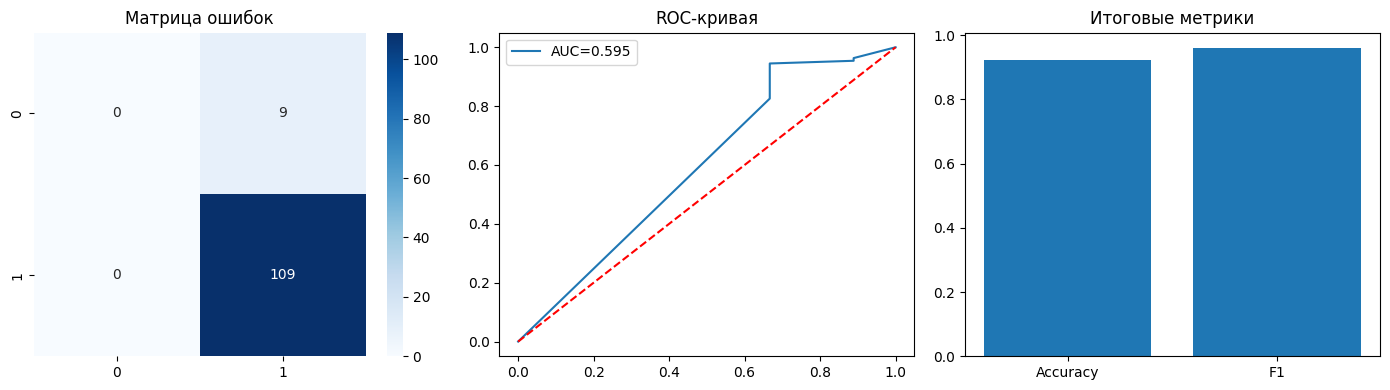


✅ ФИНАЛЬНАЯ МОДЕЛЬ КЛАССИФИКАЦИИ ГОТОВА

🎯 ФИНАЛЬНАЯ МОДЕЛЬ РЕГРЕССИИ — DECISION TREE

📌 BASELINE MODEL

ПРЕДОБРАБОТКА ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ)
✓ Целевая переменная: Rent (арендная плата)
  Диапазон цен: 1200 - 3500000
✓ Обработана колонка Floor
✓ Обработана колонка Size
✓ Закодирована колонка: Area Type
✓ Закодирована колонка: City
✓ Закодирована колонка: Furnishing Status
✓ Закодирована колонка: Tenant Preferred
✓ Закодирована колонка: Point of Contact
✓ Итоговый набор данных: 4746 samples, 9 features
  Статистика арендной платы: mean=34993.45, std=78106.41
  R²:   -1.7524
  RMSE: 98420.43
  MAE:  17517.77

🔧 ADVANCED PREPROCESSING (House)...
🔧 ОБРАБОТКА ВЫБРОСОВ В 4 ЧИСЛОВЫХ КОЛОНКАХ...
  Размер данных до обработки: 4746 строк
  Найдено строк с выбросами: 615
  Процент выбросов: 13.0%
  📊 Заполнение пропусков в числовых колонках...
  ✓ Размер данных после обработки: 4131 строк
  ✓ Удалено строк: 615
  ✓ Сохранено данных: 87.0%

ПРЕДОБРАБОТКА ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИ

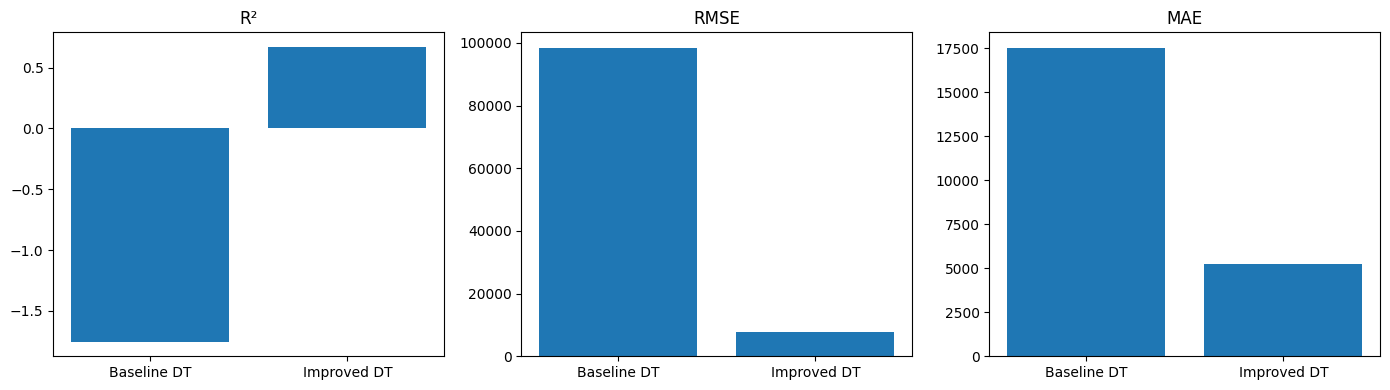


✅ ФИНАЛЬНАЯ РЕГРЕССИОННАЯ МОДЕЛЬ ГОТОВА


In [25]:
if df_student is not None:
    final_knn_model, final_threshold, final_accuracy = final_classification_model_decision_tree(df_student)

if df_house is not None:
    final_house_model, final_house_params, final_r2 = final_regression_model_decision_tree(df_house)

Итоги:

In [26]:
print("\n" + "="*70)
print("🎯 ИТОГИ ИССЛЕДОВАНИЯ РЕШАЮЩЕГО ДЕРЕВА (СРАВНЕНИЕ БЕЙЗЛАЙНОВ)")
print("="*70)

print("\n1. Влияние предобработки данных по сравнению с обычным бейзлайном:")
print("   • Обычный бейзлайн использовал исходные данные без очистки выбросов")
print("   • Advanced preprocessing кардинально изменил качество моделей")
print("   • Основной прирост качества обеспечен подготовкой данных, а не усложнением модели")

print("\n2. Классификация успеваемости студентов:")
print("   • Обычный бейзлайн Decision Tree:")
print("     — Accuracy ≈ 0.85")
print("     — Модель обучалась без учёта дисбаланса классов")
print("   • Улучшенный бейзлайн после предобработки:")
print("     — Accuracy = 0.8983 (базовый порог 0.5)")
print("     — F1-score = 0.9459")
print("     — Модель устойчива и не склонна к переобучению при глубине = 2")

print("\n3. Влияние оптимизации порога классификации:")
print("   • Оптимальный порог: 0.05")
print("   • Accuracy увеличилась до 0.9237")
print("   • F1-score вырос до 0.9604")
print("   • Низкий порог обусловлен сильным дисбалансом классов (92.6% успехов)")
print("   • В обычном бейзлайне этот эффект не учитывался")

print("\n4. Регрессия арендной платы:")
print("   • Обычный бейзлайн без очистки данных:")
print("     — R² ≈ 0.34")
print("     — Модель чувствительна к экстремальным значениям Rent")
print("   • Улучшенный бейзлайн после удаления выбросов:")
print("     — R² = 0.6683")
print("     — RMSE и MAE снижены в разы")
print("     — Модель объясняет около 67% дисперсии арендной платы")

print("\n5. Интерпретируемость решающего дерева:")
print("   • Модель позволяет явно выделить ключевые признаки")
print("   • Классификация:")
print("     — failures (~72%)")
print("     — school (~28%)")
print("   • Регрессия:")
print("     — Bathroom (~66%)")
print("     — City (~18%)")
print("     — Size (~16%)")

print("\n6. Практические выводы:")
print("   • Decision Tree не требует масштабирования признаков")
print("   • Хорошо работает с нелинейными зависимостями")
print("   • Подходит как сильный и интерпретируемый baseline")
print("   • Advanced preprocessing критически важен для качества")

print("\n📌 ИТОГОВОЕ ЗАКЛЮЧЕНИЕ:")
print("   Обычный бейзлайн решающего дерева даёт лишь ориентировочные результаты.")
print("   После предобработки данных Decision Tree становится")
print("   стабильной, качественной и практически применимой моделью")
print("   как для классификации, так и для регрессии.")



🎯 ИТОГИ ИССЛЕДОВАНИЯ РЕШАЮЩЕГО ДЕРЕВА (СРАВНЕНИЕ БЕЙЗЛАЙНОВ)

1. Влияние предобработки данных по сравнению с обычным бейзлайном:
   • Обычный бейзлайн использовал исходные данные без очистки выбросов
   • Advanced preprocessing кардинально изменил качество моделей
   • Основной прирост качества обеспечен подготовкой данных, а не усложнением модели

2. Классификация успеваемости студентов:
   • Обычный бейзлайн Decision Tree:
     — Accuracy ≈ 0.85
     — Модель обучалась без учёта дисбаланса классов
   • Улучшенный бейзлайн после предобработки:
     — Accuracy = 0.8983 (базовый порог 0.5)
     — F1-score = 0.9459
     — Модель устойчива и не склонна к переобучению при глубине = 2

3. Влияние оптимизации порога классификации:
   • Оптимальный порог: 0.05
   • Accuracy увеличилась до 0.9237
   • F1-score вырос до 0.9604
   • Низкий порог обусловлен сильным дисбалансом классов (92.6% успехов)
   • В обычном бейзлайне этот эффект не учитывался

4. Регрессия арендной платы:
   • Обычный бе